In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sys
import os
import traceback
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from plotnine import *
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import pathlib

In [2]:
icd_map_descrip = {}

In [3]:
# class for error handling
class ErrorHandler(object):
    def handle_error(self, err):
        tb = sys.exc_info()[-1]
        stack_trace = traceback.extract_tb(tb, 1)
        fn_name = stack_trace[0][2]
        # print(fn_name)
        return fn_name + ":" + err


# Class to read file and pre-processing
class PreProcessor:
    def __init__(self, file_name, missing_values, target_flag, parent=None):
        try:
            self.file_name = file_name
            self.error_object = ErrorHandler()
            current_path = pathlib.Path().absolute()
            self.file_name = os.path.join(current_path, self.file_name)
            self.data = pd.read_csv(self.file_name, na_values=missing_values, skipinitialspace=True, index_col=False)
            self.data_numeric_cols = get_numeric_columns(self.data)
            self.remove_trailing_spaces()
            self.print_basic_data_insights()
            self.icd_mapping()
            self.preprocess_categorical_features()
            if target_flag:
                self.target_binary_conversion()
            else:
                self.target_balanced_conersion()

        except Exception as exception:
            err = self.error_object.handle_error(str(exception))
            print("The Exception ", str(exception), " occurred")

    # Function for counting number of numeric columns
    def count_numeric_columns(self):
        return len(self.data_numeric_cols.columns)

    # Getter Function to get data when called from outside class
    def get_data(self):
        return self.data

    # Replacing trailing spaces in column values using strip
    def remove_trailing_spaces(self):
        print("\nReplacing any trailing spaces with NaN for all columns\n")
        for column in self.data.select_dtypes([np.object]).columns:
            self.data[column] = self.data[column].str.strip()

    # Printing basic data insights
    def print_basic_data_insights(self):
        print("Printing the head of the data: \n", self.data.head())
        print("\nShape of data set given is ", self.data.shape)
        print("\nStatistical analysis of data set given is \n", self.data_numeric_cols.describe())
        print("Number of numerical datatype columns is: ", self.count_numeric_columns())

    def icd_mapping(self):
        file_icd = open("ICD Mapping.txt")
        rows = file_icd.readlines()
        for line in rows[1:]:
            line = line.split('\t')
            icd_map_descrip[tuple(line[1].split('-'))] = line[4].strip()
        print("ICD Mapping is now \n", icd_map_descrip)
        self.data['diag_1'] = self.data['diag_1'].fillna('?')
        self.data['diag_2'] = self.data['diag_2'].fillna('?')
        self.data['diag_3'] = self.data['diag_3'].fillna('?')
        self.data['diag_1'] = self.data['diag_1'].apply(self.condition)
        self.data['diag_2'] = self.data['diag_2'].apply(self.condition)
        self.data['diag_3'] = self.data['diag_3'].apply(self.condition)
        print(self.data[{'diag_1', 'diag_2', 'diag_3'}])

    def condition(self, value):
        for key in icd_map_descrip:
            if key[0] == 'E' and key[0] in value or key[1] in value:
                return icd_map_descrip[key]
            if key[0] <= value <= key[1]:
                return icd_map_descrip[key]

    def target_binary_conversion(self):
        self.data['readmitted'] = self.data['readmitted'].map({'>30': 'No', '<30': 'Yes', 'NO' : 'No'})
        print(self.data.head())
        
    def target_balanced_conersion(self):
        self.data['readmitted'] = self.data['readmitted'].map({'>30': 'Yes', '<30': 'Yes', 'NO' : 'No'})
        print(self.data.head())

    def preprocess_categorical_features(self):
        keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
        for column in self.data.columns:
            if self.data[column].dtype == 'object' or self.data[column].dtype.name == 'category':
                print(column, " has data type ", self.data[column].dtype, " has ", len(self.data[column].unique()), " unique values")
                group_counts = self.data.groupby([column]).size().reset_index(name='counts')
                graph_title = 'Barplot for categorical feature ' + column
                x_axis, y_axis = column, 'Number of readmitted patients'
                bar_graph(group_counts[column], group_counts['counts'], graph_title, x_axis, y_axis)
                if column in keys:
                    self.data[column] = self.data[column].apply(lambda x: 'No' if (x == 'No') else 'Yes')

# class to visualize correlation
class VisualizeCorrelation:
    def __init__(self, data, parent=None):
        try:
            self.error_object = ErrorHandler()
            self.data = get_numeric_columns(data)
            self.print_data_correlation()
        except Exception as exception:
            error = self.error_object.handle_error(str(exception))
            print(str(error))

    # Print data correlation
    def print_data_correlation(self):
        print("Printing the correlation of the data: \n", self.data.corr())


# Class to handle missing values and corresponding operations
class MissingValueHandler:
    def __init__(self, data, parent=None):
        try:
            self.errObj = ErrorHandler()
            self.data = data
            missing_vals, missing_cols = self.print_missing_values_columns_wise()
            self.graph_for_missing_values(missing_cols, missing_vals)
            self.dropping_high_no_missing_val_cols()
        except Exception as exp:
            err = self.errObj.handle_error(str(exp))
            print(str(err))

    def dropping_high_no_missing_val_cols(self):
        # Calculating dataset size
        dataset_size = len(self.data.index)
        print("\nDataset size is ", dataset_size)
        print("Percentage of missing values in data :\n", self.data.isna().mean().round(4) * 100)

        # setting limit of missing values to 30% of dataset size
        missing_values_limit = 0.3 * dataset_size
        print("\n \nLimit on number of missing values is ", missing_values_limit)

        # Dropping columns with more missing values
        for column in self.data.columns:
            number_of_missing_values_column = self.data[column].isnull().sum()
            if number_of_missing_values_column > missing_values_limit and column != 'medical_specialty':
                self.data.drop(column, axis=1, inplace=True)
                print(column.strip(), " column is dropped with missing values count", number_of_missing_values_column)
        print("\n")

    def get_data(self):
        return self.data

    def print_missing_values_columns_wise(self):
        missing_values = self.data.isnull().sum()
        cols = self.data.columns
        missing_cols = []
        missing_vals = []
        print("\nSo the columns which have missing values are: ")
        for i in range(len(missing_values)):
            if missing_values[i] != 0:
                print(cols[i] + " " + str(missing_values[i]))
                missing_cols.append(cols[i])
                missing_vals.append(missing_values[i])
        return missing_vals, missing_cols

    def graph_for_missing_values(self, missing_cols, missing_vals):
        graph_title = 'Missing Values Barplot'
        x_axis = 'Columns with missing values'
        y_axis = 'Number of missing values'
        bar_graph(missing_cols, missing_vals, graph_title, x_axis, y_axis)


# Class to handle encoding categorical features
class Encoder:
    def __init__(self, data, parent=None):
        try:
            self.errObj = ErrorHandler()
            self.data = data
            for column in data.columns:
                print(column, " has data type ", data[column].dtype, " has ", len(data[column].unique()), " unique values")
                if data[column].dtype == 'object' or data[column].dtype.name == 'category':                      
                    if len(data[column].unique()) < 5 and column != 'age':
                        # Performing label encoding
                        data = self.cat_to_numeric_encoding(column, data)
                    elif column != 'age':
                        # performing one hot encoding
                        data = pd.get_dummies(data, columns=[column])
                    else:
                        # for age we do frequency based encoding
                        print(data[column].value_counts())
                        count = len(data[column].value_counts())
                        for key in data[column].value_counts().keys().tolist():
                            print(key, " ", "is ", count)
                            data.replace({'age': {key: count}}, inplace=True)
                            count = count-1
            self.data = data
        except Exception as exp:
            err = self.errObj.handle_error(str(exp))
            print(str(err))

    def get_data(self):
        return self.data

    def cat_to_numeric_encoding(self, column, data):
        data[column] = data[column].astype('category')
        data[column] = data[column].cat.codes
        return data


# class for handling feature engineering and adding additional columns
class FeatureEngineering:
    def __init__(self, data, parent=None):
        try:
            self.errObj = ErrorHandler()
            self.data = data
            df = pd.DataFrame(data)
            race_categories = []
            for value in df['race']:
                if value == 'Caucasian':
                    race_categories.append('Caucasian')
                elif value == 'AfricanAmerican':
                    race_categories.append('AfricanAmerican')
                else:
                    race_categories.append('Other')
            df['race_categories'] = race_categories
            print(data['race_categories'].value_counts())
            # df = pd.get_dummies(df, columns=['gender'], prefix='G', drop_first=True)
            self.data = df

        except Exception as exp:
            err = self.errObj.handle_error(str(exp))
            print(str(err))

    def get_data(self):
        return self.data

    def add_columns(self, data):
        try:
            data['no_of_revisits'] = data.patient_nbr.groupby(data.patient_nbr).transform('count')
            data.drop('encounter_id', axis=1, inplace=True)
            data.drop('patient_nbr', axis=1, inplace=True)
            print(ggplot(data, aes(x='no_of_revisits')) + geom_bar(stat='count') +
                  theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(14, 8)) +
                  xlab('no_of_revisits') + \
                  ylab('Count') + ggtitle("ggPlot for no_of_revisits"))

            self.data = data
            return self.data

        except Exception as exp:
            err = self.errObj.handle_error(str(exp))
            print(str(err))

    def join_columns(self, data):
        try:
            data['race_gender'] = data['race_categories'].astype(str) + ' - ' + data['gender'].astype(str)
            pd.crosstab(data.readmitted, data.race_gender).plot(kind='bar')
            plt.title('Frequency of race_gender Category for Readmitted')
            plt.xlabel('Readmitted')
            plt.ylabel('Frequency of race_gender')
            plt.show()
            data['age_gender'] = data['age'].astype(str) + ' - ' + data['gender'].astype(str)
            pd.crosstab(data.readmitted, data.age_gender).plot(kind='bar')
            plt.title('Frequency of age_gender Category for Readmitted')
            plt.xlabel('Readmitted')
            plt.ylabel('Frequency of age_gender')
            plt.show()
            print(data.groupby(['age_gender', 'readmitted']).mean())
            pd.crosstab(data.readmitted, data.age_gender).plot(kind='bar')
            plt.title('Frequency of Mean of age_gender Category for Readmitted')
            plt.xlabel('Readmitted')
            plt.ylabel('Frequency of Mean of age_gender')
            plt.show()
            print(data.groupby(['race_gender', 'readmitted']).mean())
            pd.crosstab(data.readmitted, data.race_gender).plot(kind='bar')
            plt.title('Frequency of Mean of race_gender Category for Readmitted')
            plt.xlabel('Readmitted')
            plt.ylabel('Frequency of Mean of race_gender')
            plt.show()
            self.data = data
            return self.data

        except Exception as exp:
            err = self.errObj.handle_error(str(exp))
            print(str(err))

    def binning_numeric_cols(self, data):
        try:
            data_num = get_numeric_columns(data)
            for i in data_num[1:len(data_num)]:
                print("\nFor column ", i, " Min value is ", data_num[i].min(), " Max value is ", data_num[i].max())
                bins = np.linspace(data_num[i].min(), data_num[i].max(), 4)
                data[i + "Bin"] = pd.cut(data_num[i], bins, include_lowest=True, right=True, precision=1)
                print("Column created by Binning: \n", data[i + "Bin"])
            self.data = data
            return self.data

        except Exception as exp:
            err = self.errObj.handle_error(str(exp))
            print(str(err))

    def create_category_pct(self, data):
        try:
            categorical_cols = get_category_columns(data)
            number_of_records = len(data)
            for i in categorical_cols[1:len(categorical_cols)]:
                print(i)
                if i != 'readmitted':
                    data[i + 'Pct'] = (data[i].groupby(data[i]).transform('count'))*100/number_of_records
            self.data = data
            return self.data

        except Exception as exp:
            err = self.errObj.handle_error(str(exp))
            print(str(err))

    def convert_numeric_to_category(self, data):
        try:
            self.data = data
            numeric_cols = get_numeric_columns(data).columns
            total_no_of_rows = len(data)
            for i in numeric_cols:
                if len(data[i].unique()) / total_no_of_rows < 0.01:
                    print(i, " column has ", len(data[i].unique()), " values")
                    data[i] = data[i].astype('category')
            self.data = data
            return self.data
        except Exception as exp:
            err = self.errObj.handle_error(str(exp))
            print(str(err))


# class for scaling the data
class Scaling:
    def __init__(self, data, parent=None):
        try:
            self.errObj = ErrorHandler()
            self.data = data
            # Scaling/Normalization
            # numData = get_numeric_columns(data)
            scaler = MinMaxScaler()
            d2 = scaler.fit_transform(data)
            scaledData = pd.DataFrame(d2, columns=data.columns)
            ax = sns.boxplot(data=scaledData.iloc[:, 0:12])
            ax.set_title("Data after Scaling")
            ax.set_xlabel("Column names")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            self.data = scaledData
        except Exception as exp:
            err = self.errObj.handle_error(str(exp))
            print(str(err))

    def get_data(self):
        return self.data


# class for handling outliers
class Outlier:
    def __init__(self, data, parent=None):
        try:
            self.errObj = ErrorHandler()
            self.data = data
            list_of_cat_cols = get_category_columns(self.data)
            # self.data_numeric_only = pd.get_dummies(data=self.data, columns=list_of_cat_cols.columns)
            # self.data_numeric_only = get_numeric_columns(self.data)
            self.data_numeric_only = self.data
            print("\nNumeric columns for visualizing outliers: ", self.data_numeric_only.columns)
            # self.data_numeric_only.drop("encounter_id", axis=1, inplace=True)
            # self.data_numeric_only.drop("patient_nbr", axis=1, inplace=True)
        except Exception as exp:
            err = self.errObj.handle_error(str(exp))
            print(str(err))

    def visualize_outlier(self):
        try:
            ax = sns.boxplot(data=self.data_numeric_only.iloc[:, 0:12])
            ax.set_title("Visualizing Outliers")
            ax.set_xlabel("Column names")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig("Outliers.png")
            plt.show()
        except Exception as exception:
            err = self.errObj.handle_error(str(exception))
            print(str(err))

    def z_score_outlier(self):
        try:
            z_score = np.abs(stats.zscore(self.data_numeric_only))
            print("z_score value is ", len(z_score), len(z_score[0]), "\n", z_score);
            print("Entries which are outliers are ", np.where(z_score > 3))
            # First array list of row numbers
            # second array with list of respective column numbers
            data_without_outliers = self.data_numeric_only[(z_score < 3).all(axis=1)]
            print("Original shape of data is ", self.data_numeric_only.shape)
            print("Final shape of data without outliers(Z Score based) is ", data_without_outliers.shape)
            print("Hence from z score based outlier detection we got ",
                  self.data_numeric_only.shape[0]-data_without_outliers.shape[0], " outliers")
            return data_without_outliers
        except Exception as exception:
            err = self.errObj.handle_error(str(exception))
            print(str(err))

    def iqr_outlier(self):
        try:
            quantile_one = self.data_numeric_only.quantile(0.25)
            quantile_three = self.data_numeric_only.quantile(0.75)
            iqr = quantile_three - quantile_one
            print("IQR is \n", iqr)
            print(self.data_numeric_only[((self.data_numeric_only < (quantile_one-1.5*iqr)) |
                                          (self.data_numeric_only > (quantile_three+1.5*iqr)))])
            data_without_outliers = self.data_numeric_only[~((self.data_numeric_only < (quantile_one-1.5*iqr))
                                                    | (self.data_numeric_only > (quantile_three+1.5*iqr))).any(axis=1)]
            print("Original shape of data is ", self.data_numeric_only.shape)
            print("Final shape of data without outliers(IQR based) is ", data_without_outliers.shape)
            print("Hence from IQR based outlier detection we got ",
                  self.data_numeric_only.shape[0] - data_without_outliers.shape[0], " outliers")
            return data_without_outliers
        except Exception as exception:
            err = self.errObj.handle_error(str(exception))
            print(str(err))

    def db_scan_outlier(self):
        try:
            # data_one = pd.get_dummies(self.data_numeric_only)
            scaler = MinMaxScaler()
            data_one = scaler.fit_transform(self.data_numeric_only)
            data_two = pd.DataFrame(data_one, columns=self.data_numeric_only.columns)
            self.find_eps(data_two)
            outlier_detection = DBSCAN(eps=3.0, min_samples=25, metric='euclidean', n_jobs=-1)
            data_clusters = outlier_detection.fit_predict(data_two)
            cmap = cm.get_cmap('Accent')
            data_two.plot.scatter(x="num_lab_procedures", y="number_emergency", c=data_clusters, cmap=cmap, colorbar=False)
            plt.title("Visualize outliers in DB Scan")
            plt.savefig("DBScanOutliers.png")
            plt.show()
            print("DBScan based Outlier Detection has ", len(np.where(data_clusters == -1)[0]), " outliers")
            for row in np.where(data_clusters == -1)[0]:
                print("row ", row, " is an outlier")
            return data_clusters
        except Exception as exception:
            err = self.errObj.handle_error(str(exception))
            print(str(err))

    def find_eps(self, data):
        neigh = NearestNeighbors(n_neighbors=2)
        nbrs = neigh.fit(data)
        distances, indices = nbrs.kneighbors(data)
        distances = np.sort(distances, axis=0)
        distances = distances[:, 1]
        plt.plot(distances)
        plt.ylabel('eps')
        plt.savefig("DBScanEpsValue.png")
        plt.show()

    def k_means_outlier(self):
        try:
            wcss = []
            for i in range(1, 15):
                kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
                kmeans.fit(self.data_numeric_only)
                wcss.append(kmeans.inertia_)
            print(wcss)
            plt.plot(range(1, 11), wcss, marker='o', color='b')
            plt.title('Elbow Method')
            plt.xlabel('Number of clusters')
            plt.xticks(range(1, 11, 1))
            plt.ylabel('WCSS')
            plt.savefig("KMeansElbowMethod.png")
            plt.show()
            k_means = KMeans(n_clusters=3)
            k_means.fit(self.data_numeric_only)
            self.data_numeric_only.plot.scatter(x="num_lab_procedures", y="number_emergency", c=kmeans.labels_, cmap='rainbow')
            # plt.scatter(kmeans.cluster_centers_['time_in_hospital'], kmeans.cluster_centers_['number_emergency'],
            # s=300, c='yellow', marker="*")
            plt.title("Numeric columns with clustering")
            plt.xlabel("num_lab_procedures")
            plt.ylabel("number_emergency")
            plt.savefig("KMeansClusters.png")
            plt.show()
        except Exception as exception:
            err = self.errObj.handle_error(str(exception))
            print(str(err))


# class for PCA
class PCA_DATA:
    def __init__(self, data, parent=None):
        try:
            self.errObj = ErrorHandler()
            self.data = data
            X = data.drop(columns=['readmitted'])  # removing the Target column
            Y = data['readmitted']  # Assigning the Target column
            print("The number of samples and dimensions in the dataset", X.shape)
            print(X.columns)

            scalar = Scaling(data)
            X_scaled = scalar.get_data()
            print("Scaling completed", X_scaled)

            print("Entering PCA block")
            pca = PCA()
            print("After step1")
            pca_full = pca.fit(X_scaled)
            print("PCA completed")
            pcaTransformed = pd.DataFrame(pca_full.transform(data), columns=range(data.shape[1]))
            for i in range(len(pcaTransformed.columns)):
                pcaTransformed.rename(columns={i: 'PCA' + str(i)}, inplace=True)
            print(pcaTransformed.head(100))
            comp = pd.DataFrame(pca_full.components_, columns=data.columns)
            print(comp)

            self.drawScreePlot(pca, pcaTransformed.columns)
            self.showVariance(pca_full, pca)

            # self.print_pca_graph1(pca_full)

            print('Rerun PCA with reduced number of components')
            pca = PCA(n_components=60)
            pca = pca.fit_transform(X_scaled)

            self.print_pca_graph2(pca, Y)

        except Exception as exception:
            err = self.errObj.handle_error(str(exception))
            print(str(err))

    def print_pca_graph1(self, pca_full):
        print("Graph 1")
        plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative explained variance')
        plt.title("No. Of Components Vs Cumulative explained variance")
        plt.show()

    def print_pca_graph2(self, pca, Y):
        print('Graph 2,3,4')
        ax = plt.figure(figsize=(16, 12)).gca(projection='3d')
        ax.scatter(
            xs=pca[:, 0],
            ys=pca[:, 1],
            zs=pca[:, 2],
            c=Y,
            cmap='tab10'
        )
        ax.set_xlabel('pca one')
        ax.set_ylabel('pca two')
        ax.set_zlabel('pca three')
        plt.title("3D Scatter Plot for top 3 principal components")
        plt.savefig('3DScatter_Plot_Top3_PCA.png')
        plt.show()

        # plot 2D plot among PCA1 & PCA2
        plt.figure(figsize=(15, 10))
        plt.scatter(pca[:, 0], pca[:, 1], c=Y, edgecolor='none', alpha=0.7,
                    cmap=plt.get_cmap('jet', 10), s=20)
        plt.colorbar()
        plt.title("2D Plot among PCA0 and PCA1")
        plt.savefig('PCA0-1.png')
        plt.show()

        # plot 2D plot among PCA1 & PCA3
        plt.figure(figsize=(15, 10))
        plt.scatter(pca[:, 0], pca[:, 2], c=Y, edgecolor='none', alpha=0.7,
                    cmap=plt.get_cmap('jet', 10), s=20)
        plt.colorbar()
        plt.title("2D Plot among PCA0 and PCA2")
        plt.savefig('PCA0-2.png')
        plt.show()

    def drawScreePlot(self, pca, columns):
        try:
            percent_variance = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
            plt.figure(figsize=(15, 8))
            plt.bar(x=range(1, len(columns) + 1), height=percent_variance, tick_label=columns)
            plt.ylabel('Percentate of Variance Explained')
            plt.xticks(rotation=45)
            plt.xlabel('Principal Component')
            plt.title('PCA Scree Plot')
            plt.savefig('PCAScreePlot.png')
            plt.show()
        except Exception as exp:
            self.errObj = ErrorHandler()
            err = self.errObj.handleErr(str(exp))
            print(str(err))

    def showVariance(self, pcaModel, pca):
        try:
            print(pcaModel.explained_variance_ratio_)
            print(np.cumsum(pcaModel.explained_variance_ratio_))
            plt.figure(figsize=(15, 8))
            plt.plot(list(range(1, len(pca.explained_variance_ratio_) + 1)), pca.explained_variance_ratio_)
            plt.axis([0, len(pca.explained_variance_ratio_) + 1, 0, max(pca.explained_variance_ratio_) + 0.05])
            plt.xlabel('Principal Components')
            plt.ylabel('Variance Explained')
            plt.xticks(rotation=45)
            plt.savefig('PCAVariance.png')
            plt.show()

            plt.figure(figsize=(15, 8))
            plt.plot(list(range(1, len(pca.explained_variance_ratio_) + 1)), np.cumsum(pca.explained_variance_ratio_))
            plt.axis([0, len(pca.explained_variance_ratio_) + 1, 0, 1.1])
            plt.axhline(y=0.9, color='r', linestyle='--', linewidth=1)
            plt.xlabel('# of Principal Components')
            plt.ylabel('Cumulative Variance Explained')
            plt.xticks(rotation=45)
            plt.savefig('PCACumVariance.png')
            plt.show()

        except Exception as exp:
            self.errObj = ErrorHandler()
            err = self.errObj.handleErr(str(exp))
            print(str(err))


In [4]:
def main(target_flag):
    # Passing '?' as missing value because we can observe there are many cells which have this value
    missing_values = ['?', '']

    # To display all columns we can set the below option
    # pd.set_option('display.max_columns', None)

    # Reading csv file and basic analysis of data
    pre_processor_object = PreProcessor("dataset_diabetes_diabetic_data.csv", missing_values, target_flag)

    # Loading csv data into data variable
    pre_processed_data = pre_processor_object.get_data()

    # Dropping only ID type columns
    # print("Dropping encounter_id and patient_nbr because they are just ID type data")
    # pre_processed_data.drop("encounter_id", axis=1, inplace=True)
    # pre_processed_data.drop("patient_nbr", axis=1, inplace=True)

    # Print correlation
    VisualizeCorrelation(pre_processed_data)

    # race column plot against readmitted column
    draw_frequency_graph(pre_processed_data, 'race')

    # number_diagnoses plot against readmitted column
    draw_frequency_graph(pre_processed_data, 'number_diagnoses')

    # readmitted column classes
    draw_frequency_graph(pre_processed_data, 'readmitted')

    # print("\nMissing values column wise are as follows: \n", pre_processed_data.isnull().sum())
    # msno.bar(pre_processed_data)

    # Handling missing values and corresponding operations
    data_after_dropping_columns = MissingValueHandler(pre_processed_data).get_data()
    data_after_dropping_columns.replace(np.nan, 'UNK', inplace=True)
    
    # Dropping examide and citoglipton columns as they have one unique value
    print("Dropping examide and citoglipton columns because they take only one value 'No'")
    data_after_dropping_columns.drop("examide", axis=1, inplace=True)
    data_after_dropping_columns.drop("citoglipton", axis=1, inplace=True)
    
    data_for_outliers = data_after_dropping_columns.copy()

    # Feature Engineering
    fe_object = FeatureEngineering(data_after_dropping_columns)
    # print("New data after re-arranging race is \n", data_after_dropping_columns['race_categories'].unique())
    data_after_adding_cols = fe_object.add_columns(data_after_dropping_columns)
    data_after_joining_cols = fe_object.join_columns(data_after_adding_cols)
    data_after_joining_cols.to_csv("data_before_binning.csv", index=False)
    data_after_binning_cols = fe_object.binning_numeric_cols(data_after_joining_cols)
    data_after_binning_cols.drop("race", axis=1, inplace=True)
    data_after_cat_to_pct = fe_object.create_category_pct(data_after_binning_cols)
    data_after_num_to_cat = fe_object.convert_numeric_to_category(data_after_cat_to_pct)

    print("New data after FE is \n", data_after_num_to_cat.head())
    print(get_numeric_columns(data_after_num_to_cat).columns)

    # Converting back few numeric columns before encoding
    data_after_num_to_cat["time_in_hospital"] = data_after_num_to_cat["time_in_hospital"].astype('int64')
    data_after_num_to_cat["num_lab_procedures"] = data_after_num_to_cat["num_lab_procedures"].astype('int64')
    data_after_num_to_cat["num_procedures"] = data_after_num_to_cat["num_procedures"].astype('int64')
    data_after_num_to_cat["num_medications"] = data_after_num_to_cat["num_medications"].astype('int64')
    data_after_num_to_cat["number_outpatient"] = data_after_num_to_cat["number_outpatient"].astype('int64')
    data_after_num_to_cat["number_emergency"] = data_after_num_to_cat["number_emergency"].astype('int64')
    data_after_num_to_cat["number_inpatient"] = data_after_num_to_cat["number_inpatient"].astype('int64')
    data_after_num_to_cat["number_diagnoses"] = data_after_num_to_cat["number_diagnoses"].astype('int64')

    # Encoding categorical features
    new_data_with_encoded_values = Encoder(data_after_num_to_cat).get_data()
    print("New Encoded data is \n", new_data_with_encoded_values.head())

    # Scaling the data
    new_data_after_scaling = Scaling(new_data_with_encoded_values).get_data()
    print("New data after Scaling is \n", new_data_after_scaling.head())

    print("Dataset now is \n", new_data_after_scaling.head())
    print("\nShape of data set given is ", new_data_after_scaling.shape)
    
    if target_flag:
        new_data_after_scaling.to_csv("final_data_before_modelling_unbalanced_target.csv", index=False)
    else:
        new_data_after_scaling.to_csv("final_data_before_modelling_balanced_target.csv", index=False)

    # Handling outliers
    outlier_object = Outlier(new_data_after_scaling)
    outlier_object.visualize_outlier()
    print("\nZ score based Outliers removed data is \n", outlier_object.z_score_outlier())
    print("IQR based Outlier removed data is \n", outlier_object.iqr_outlier())
    print("DB Scan Outlier data is \n", outlier_object.db_scan_outlier())
    print("K means based outlier detection has new data \n", outlier_object.k_means_outlier())

    # PCA code
    pca_data = new_data_after_scaling
    PCA_DATA(pca_data)


def bar_graph(x_values, y_values, graph_title, x_axis, y_axis):
    try:
        error_object = ErrorHandler()
        plt.bar(x_values, y_values)
        plt.rcParams['figure.figsize'] = (14, 8)
        plt.title(graph_title)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as exp:
        err = error_object.handle_error(str(exp))
        print(str(err))


def get_numeric_columns(data):
    try:
        error_object = ErrorHandler()
        list_of_numeric_columns = list(data.select_dtypes(include=[np.number]).columns.values)
        list_of_numeric_columns.remove('admission_type_id')
        list_of_numeric_columns.remove('discharge_disposition_id')
        list_of_numeric_columns.remove('admission_source_id')
        print("List of numeric columns are ", list_of_numeric_columns)
        return data[list_of_numeric_columns]

    except Exception as exp:
        err = error_object.handle_error(str(exp))
        print(str(err))


def get_category_columns(data):
    try:
        error_object = ErrorHandler()
        categorical_cols_list = data[data.select_dtypes(include=["object"]).columns]
        print("Categorical columns list used is ", categorical_cols_list.columns)
        print("Number of categorical columns used are ", len(categorical_cols_list.columns))
        return categorical_cols_list

    except Exception as exp:
        err = error_object.handle_error(str(exp))
        print(str(err))


def drop_column(data, column_name):
    try:
        error_object = ErrorHandler()
        data_after_dropping = data.drop(column_name, axis=1, inplace=True)
        return data_after_dropping

    except Exception as exp:
        err = error_object.handle_error(str(exp))
        print(str(err))


def draw_frequency_graph(data, column_name):
    try:
        error_object = ErrorHandler()
        data[column_name].value_counts().plot(kind='bar', figsize=(14, 8), title="Bar graph on "
                                                                                 + column_name + " column")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(column_name+".png")
        plt.show()
    except Exception as exp:
        err = error_object.handle_error(str(exp))
        print(str(err))


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


List of numeric columns are  ['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Replacing any trailing spaces with NaN for all columns

Printing the head of the data: 
    encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                 

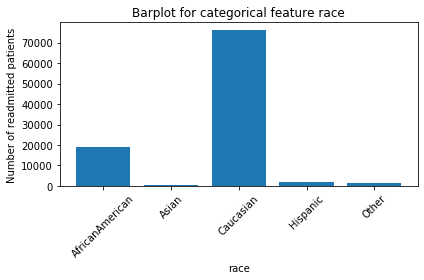

gender  has data type  object  has  3  unique values


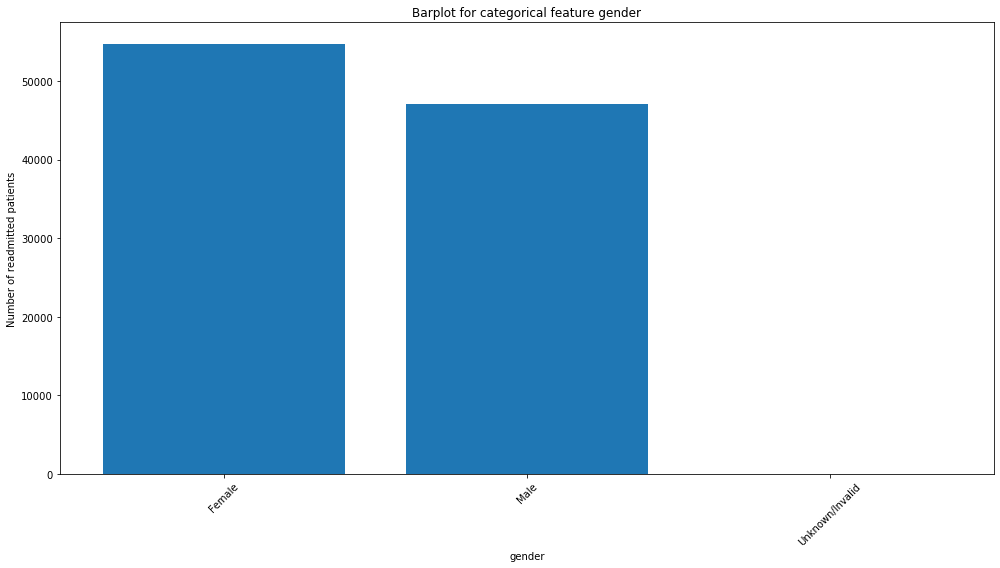

age  has data type  object  has  10  unique values


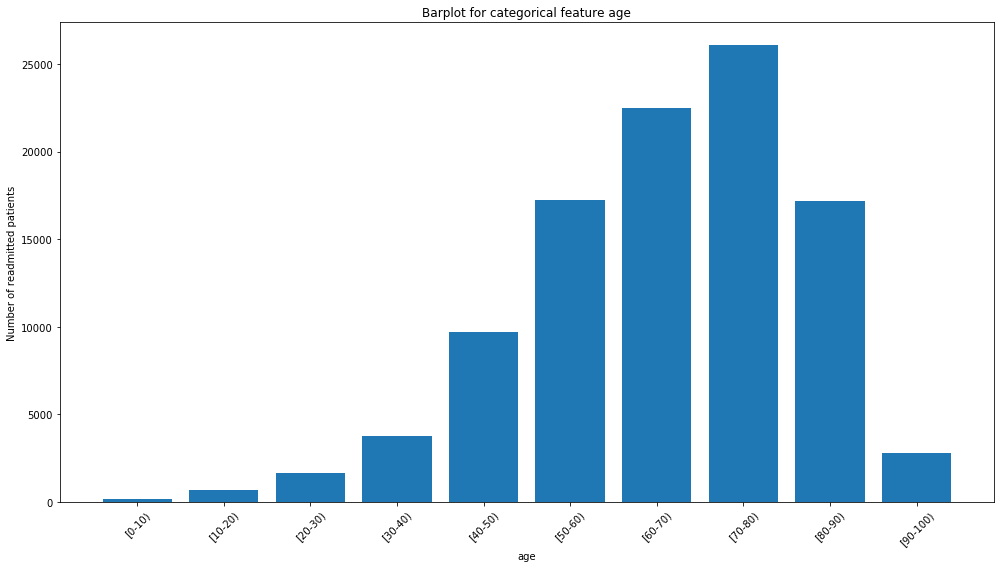

weight  has data type  object  has  10  unique values


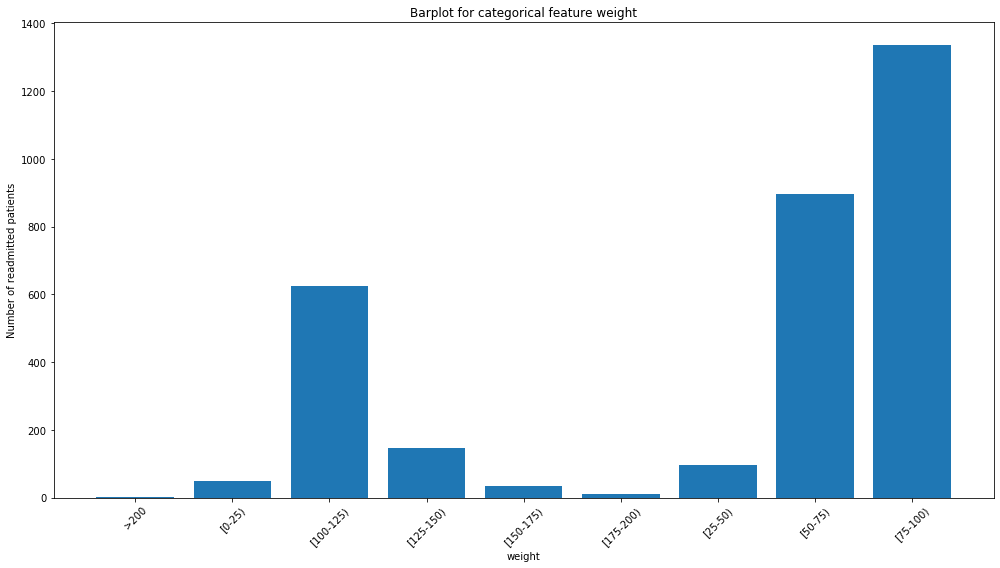

payer_code  has data type  object  has  18  unique values


medical_specialty  has data type  object  has  73  unique values


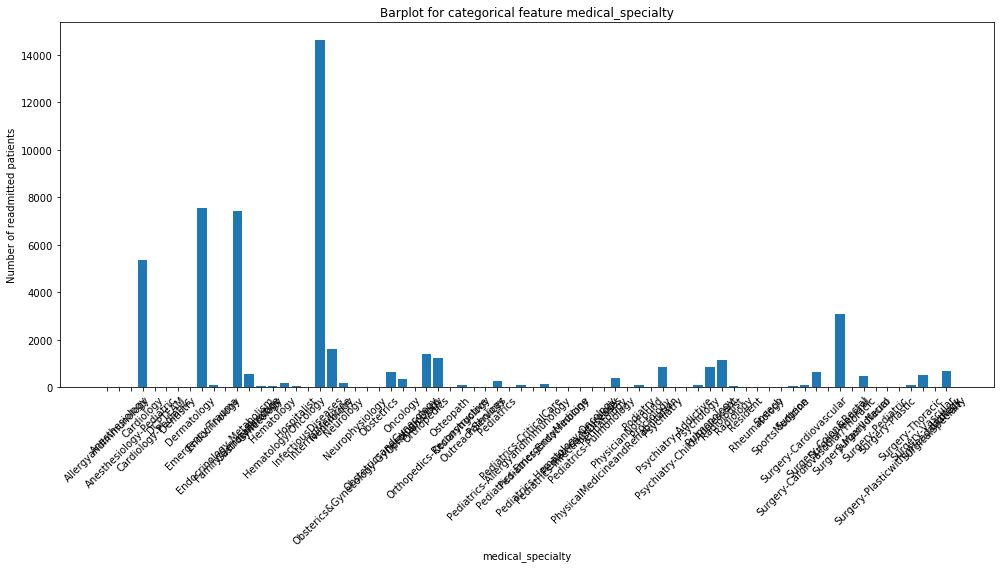

diag_1  has data type  object  has  20  unique values


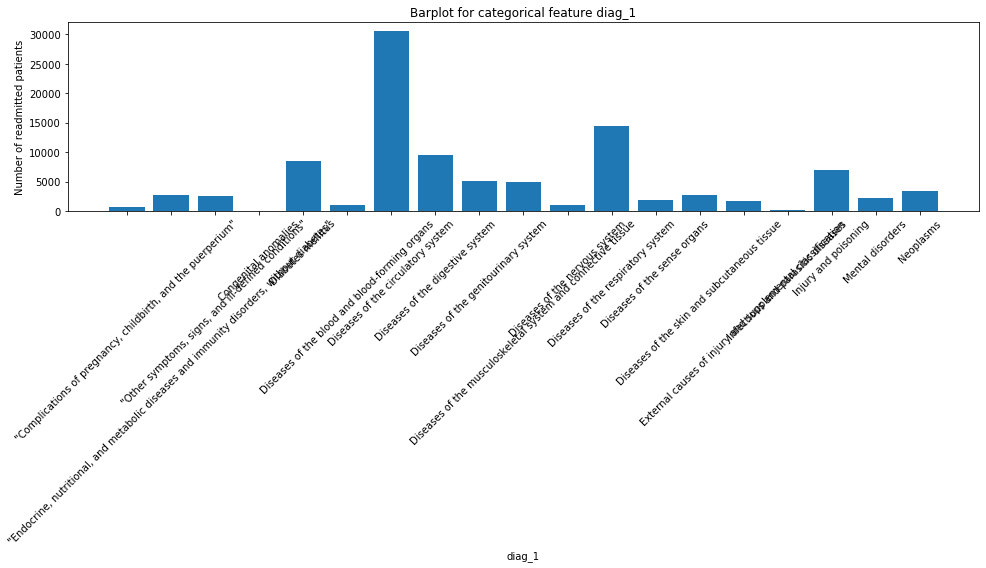

diag_2  has data type  object  has  20  unique values


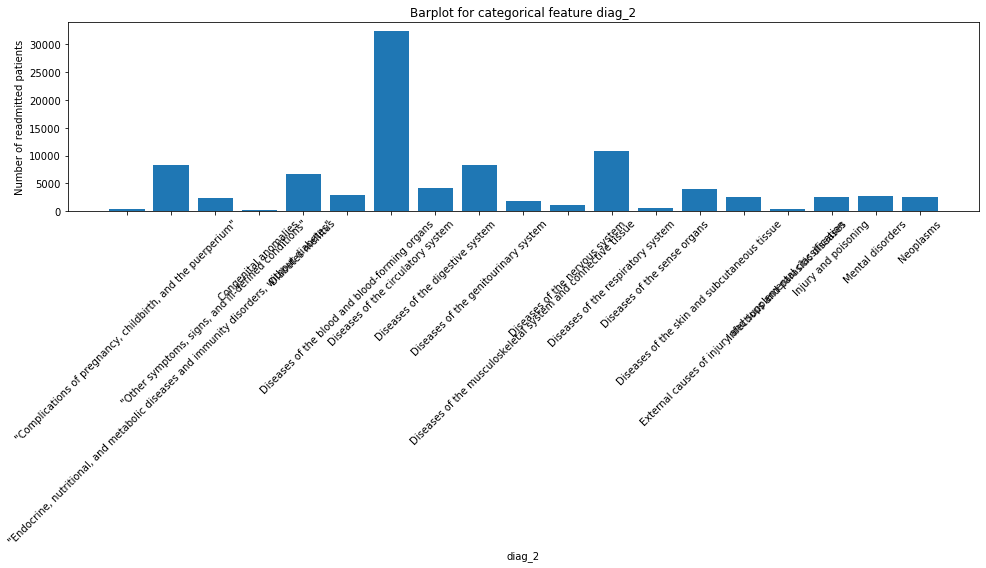

diag_3  has data type  object  has  20  unique values


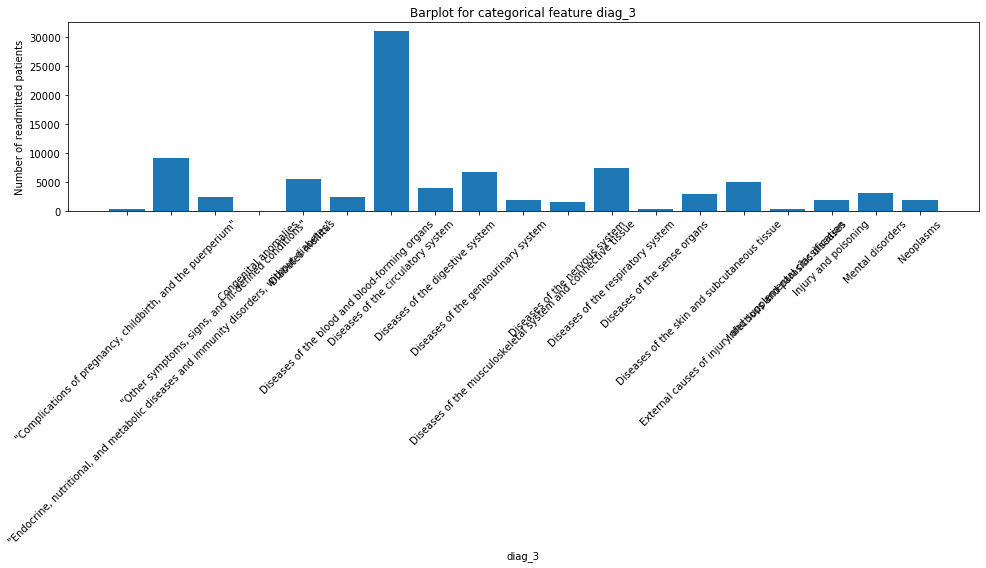

max_glu_serum  has data type  object  has  4  unique values


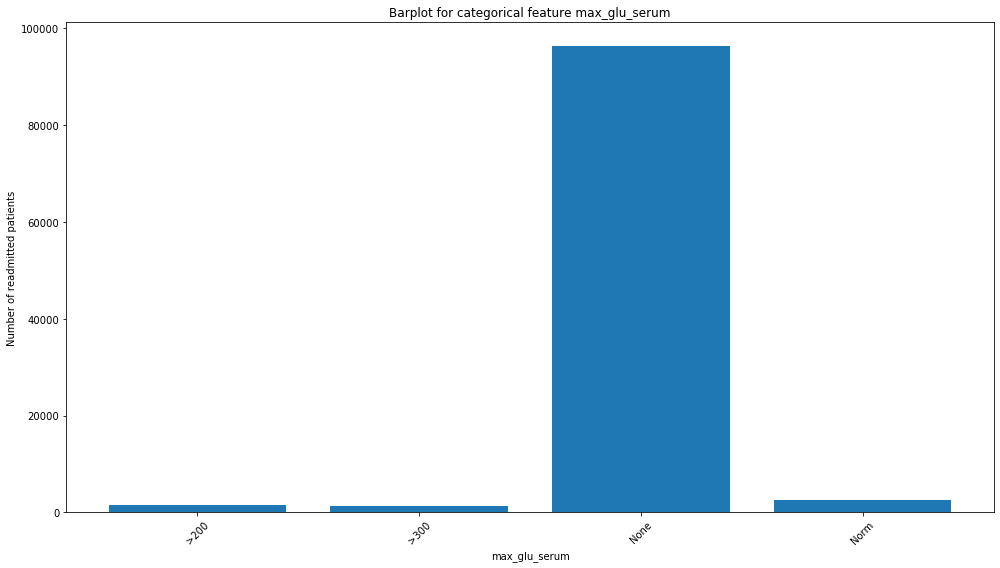

A1Cresult  has data type  object  has  4  unique values


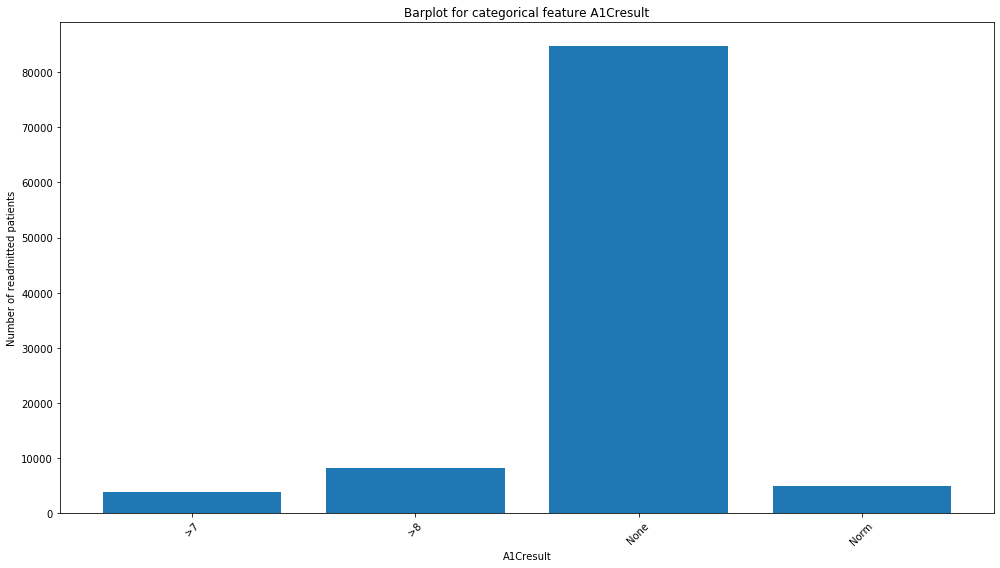

metformin  has data type  object  has  4  unique values


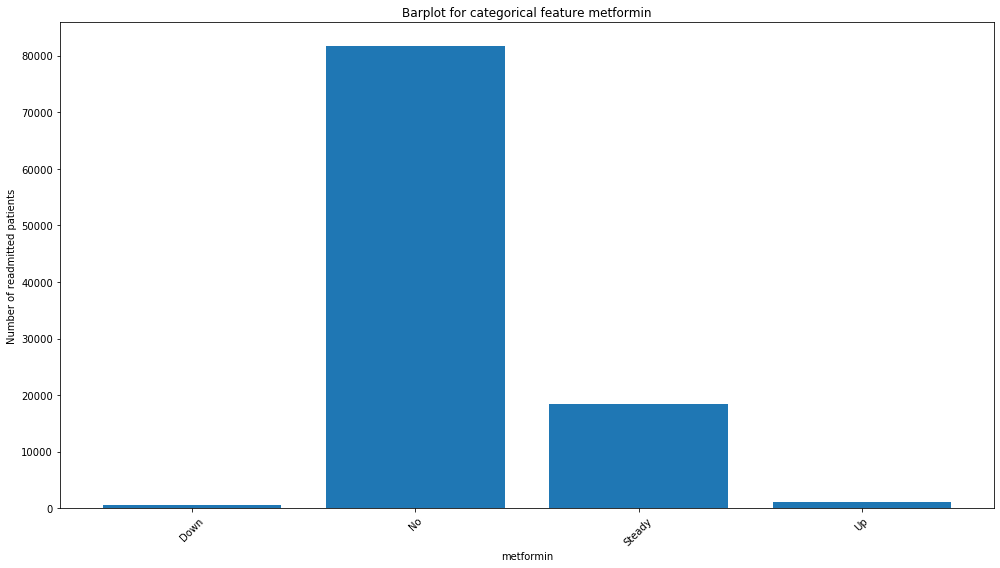

repaglinide  has data type  object  has  4  unique values


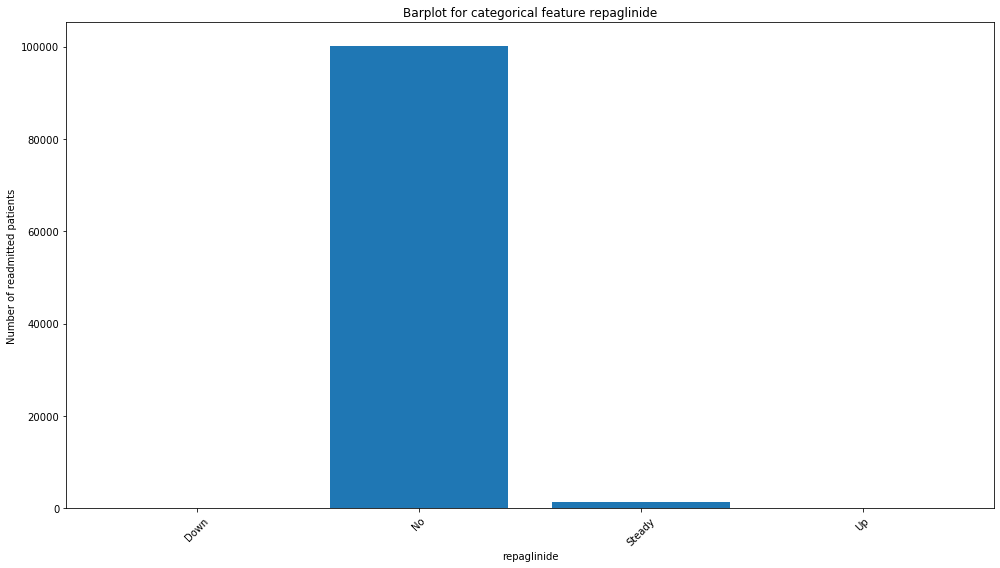

nateglinide  has data type  object  has  4  unique values


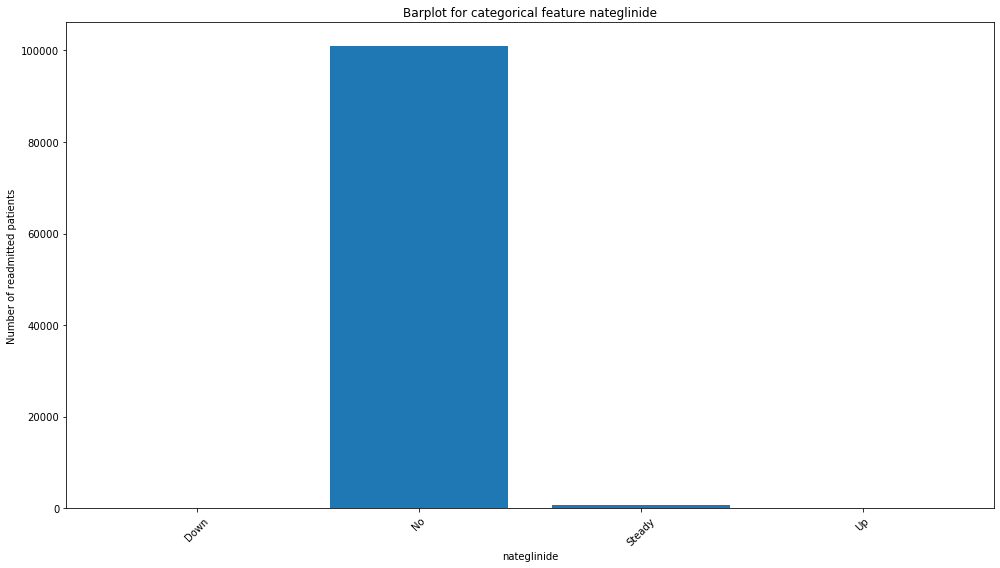

chlorpropamide  has data type  object  has  4  unique values


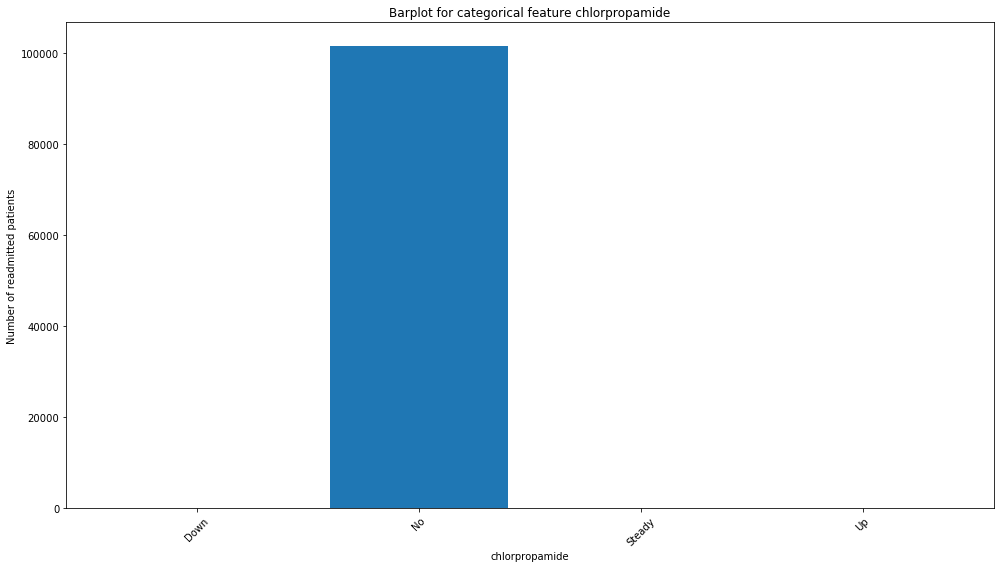

glimepiride  has data type  object  has  4  unique values


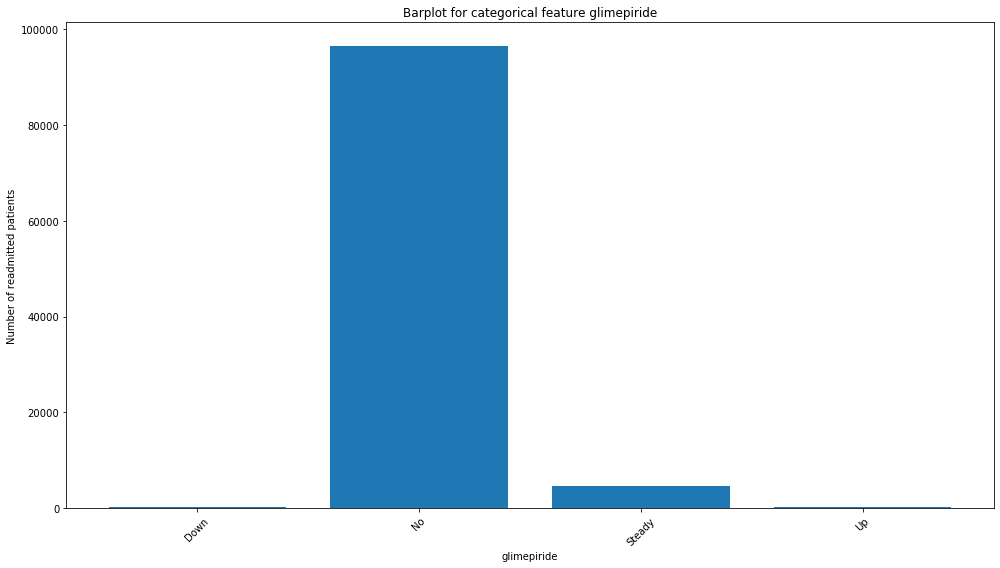

acetohexamide  has data type  object  has  2  unique values


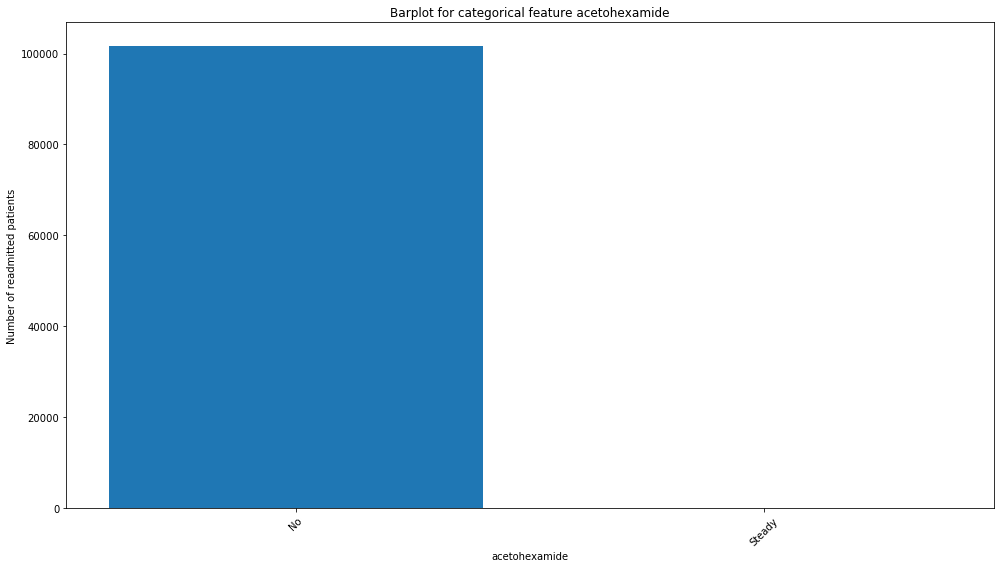

glipizide  has data type  object  has  4  unique values


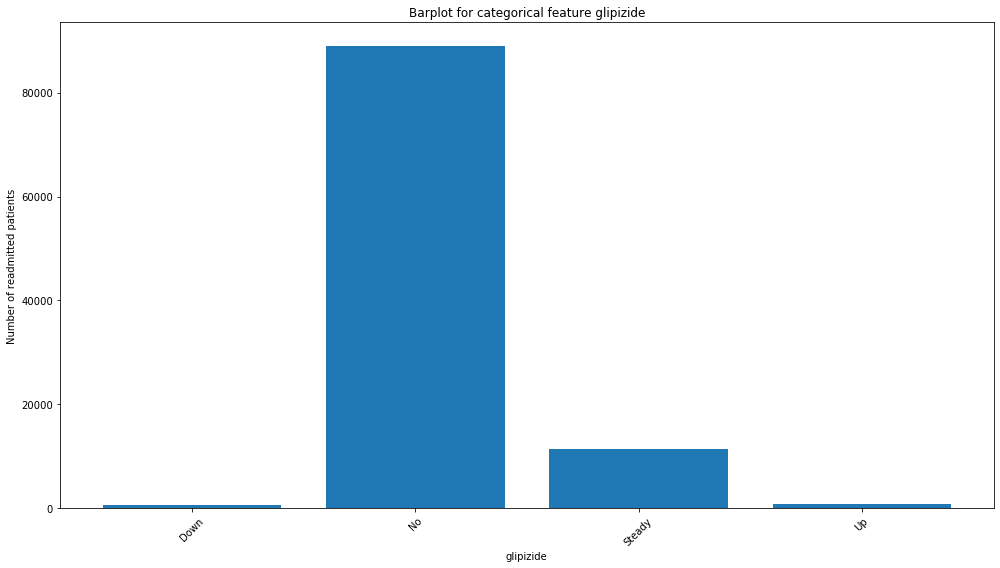

glyburide  has data type  object  has  4  unique values


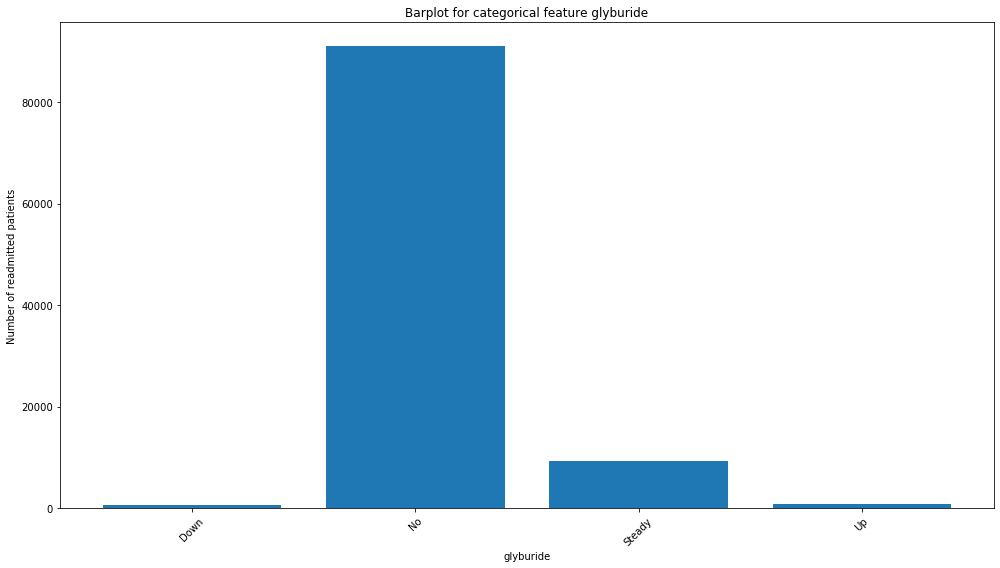

tolbutamide  has data type  object  has  2  unique values


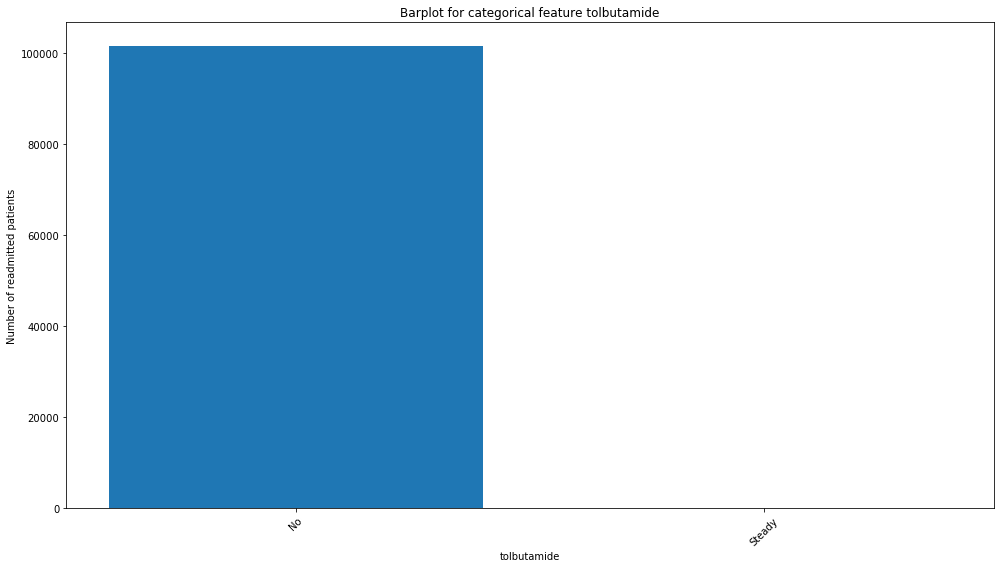

pioglitazone  has data type  object  has  4  unique values


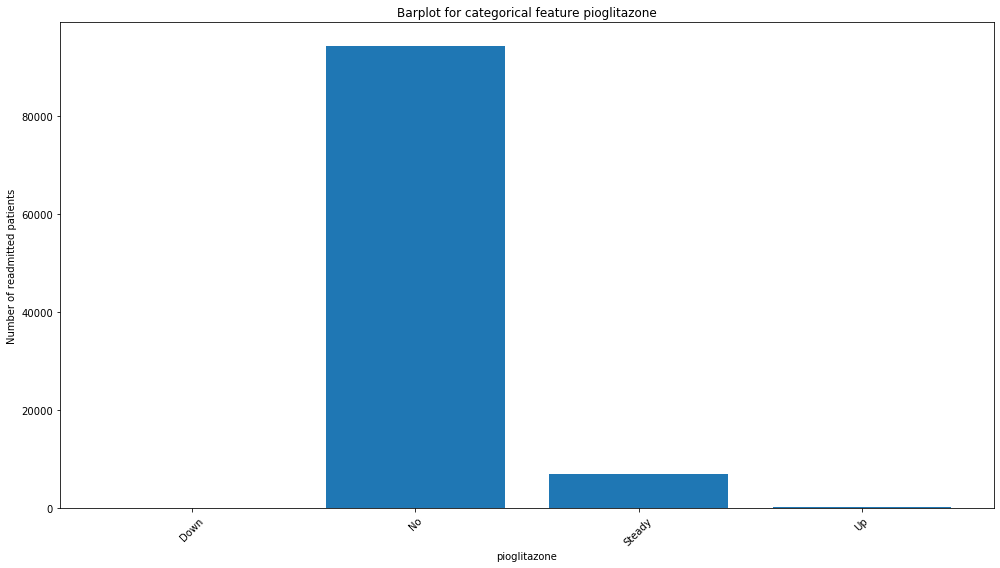

rosiglitazone  has data type  object  has  4  unique values


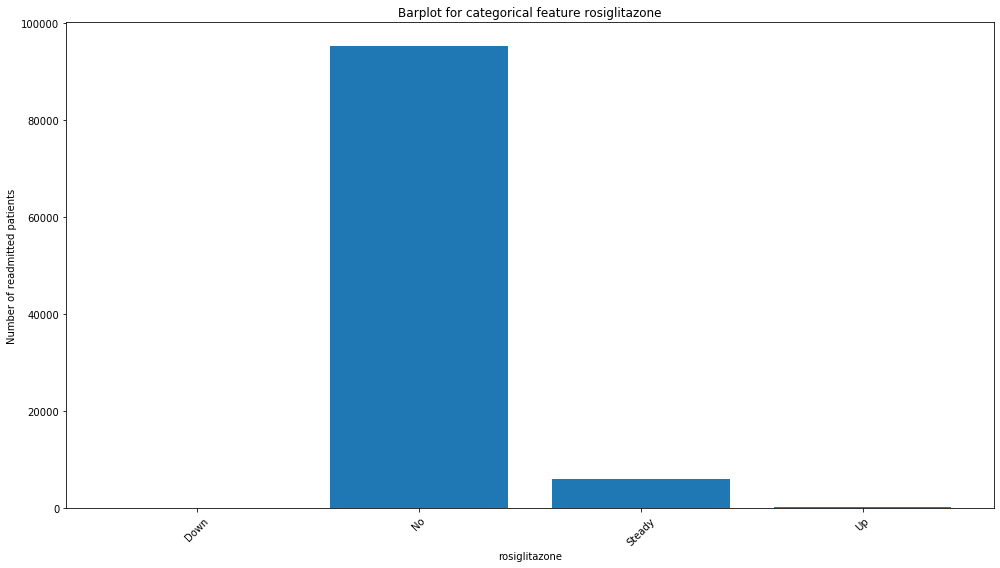

acarbose  has data type  object  has  4  unique values


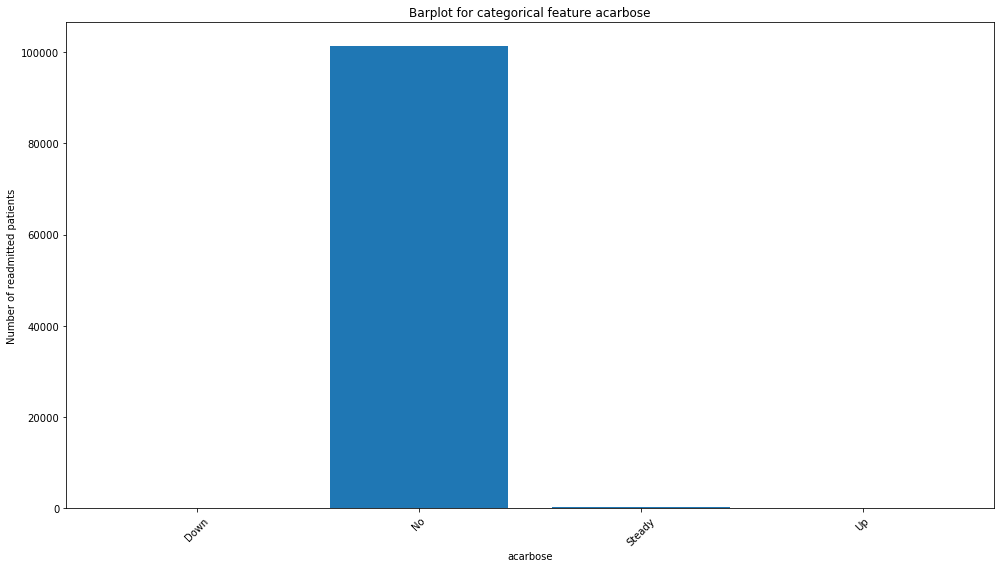

miglitol  has data type  object  has  4  unique values


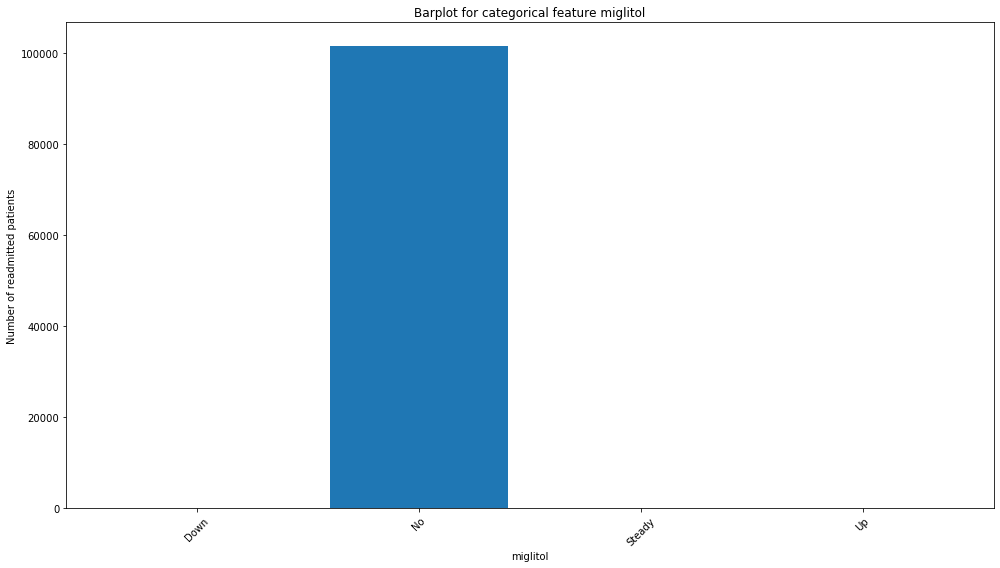

troglitazone  has data type  object  has  2  unique values


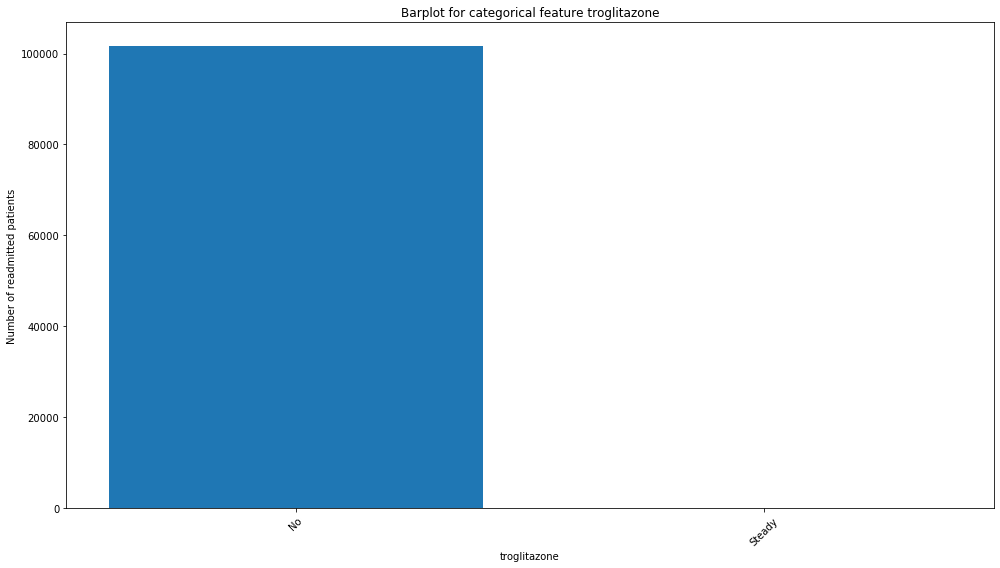

tolazamide  has data type  object  has  3  unique values


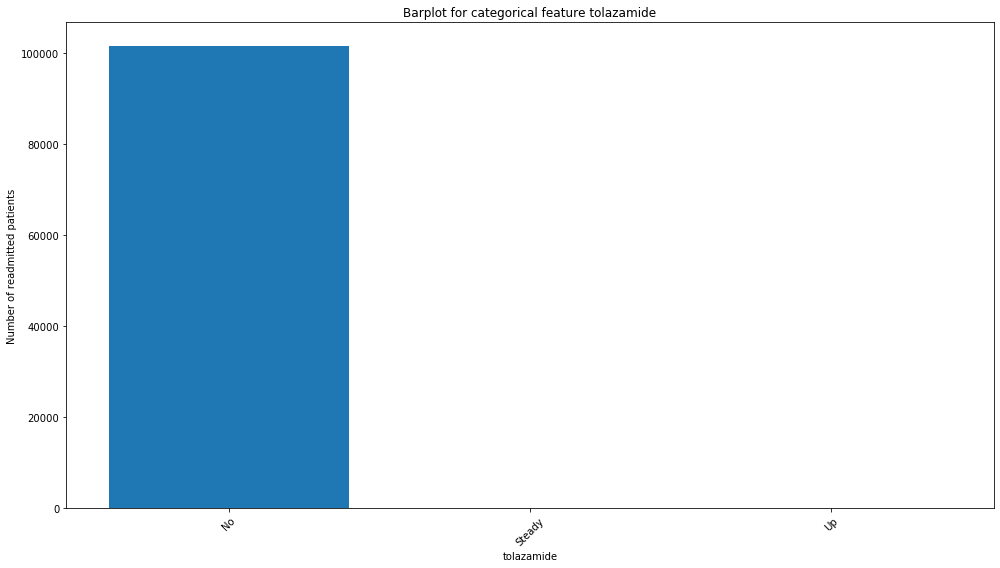

examide  has data type  object  has  1  unique values


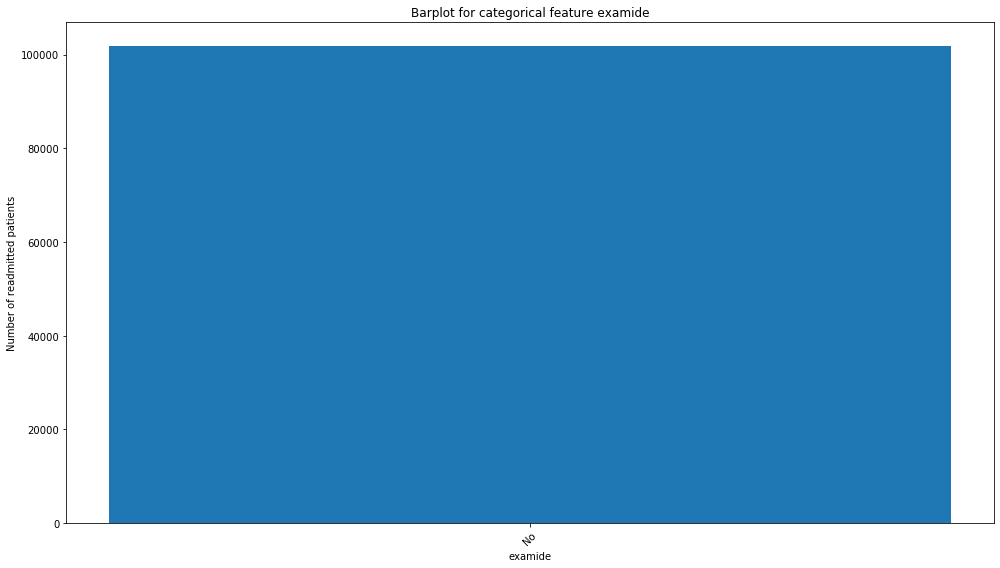

citoglipton  has data type  object  has  1  unique values


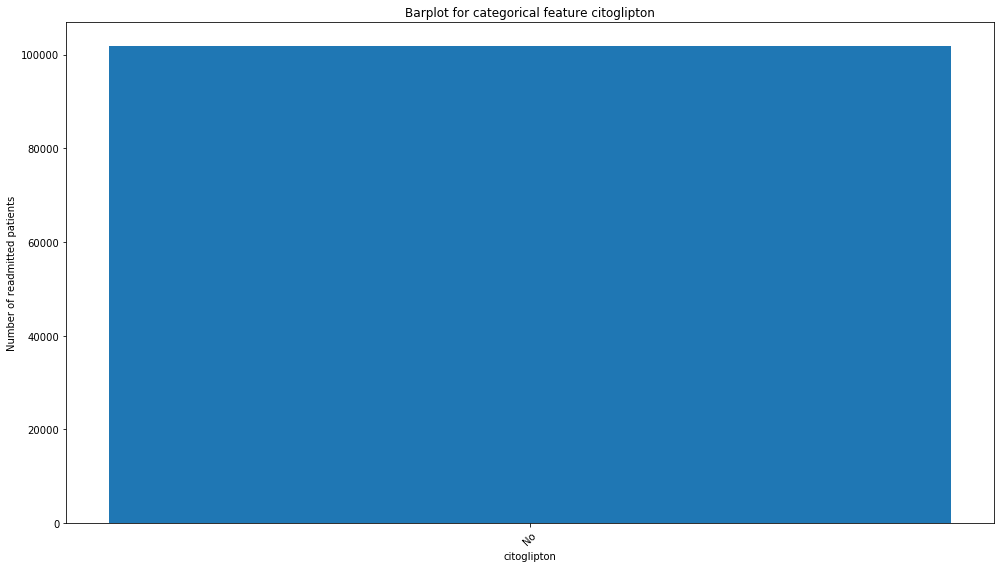

insulin  has data type  object  has  4  unique values


glyburide-metformin  has data type  object  has  4  unique values


glipizide-metformin  has data type  object  has  2  unique values


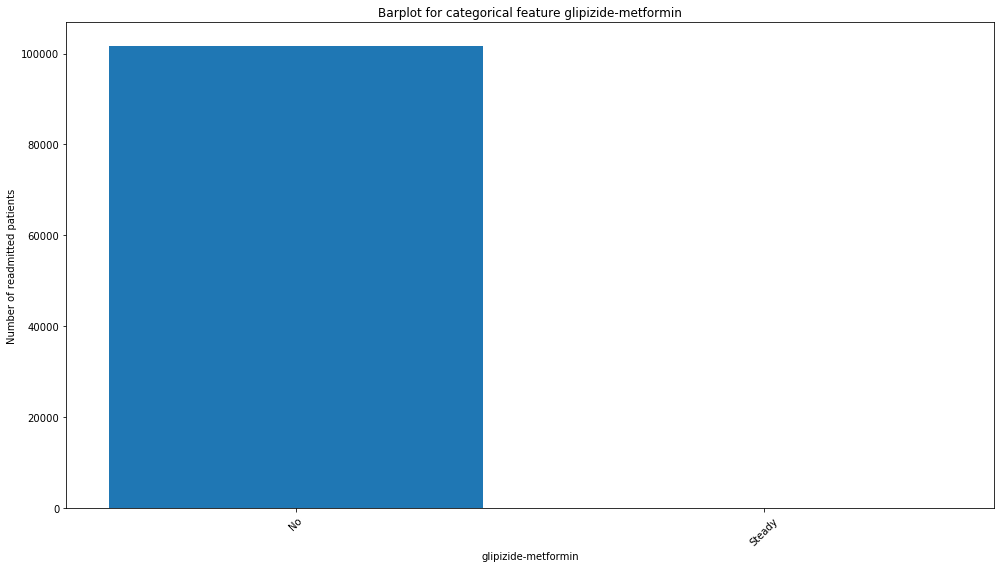

glimepiride-pioglitazone  has data type  object  has  2  unique values


metformin-rosiglitazone  has data type  object  has  2  unique values


metformin-pioglitazone  has data type  object  has  2  unique values


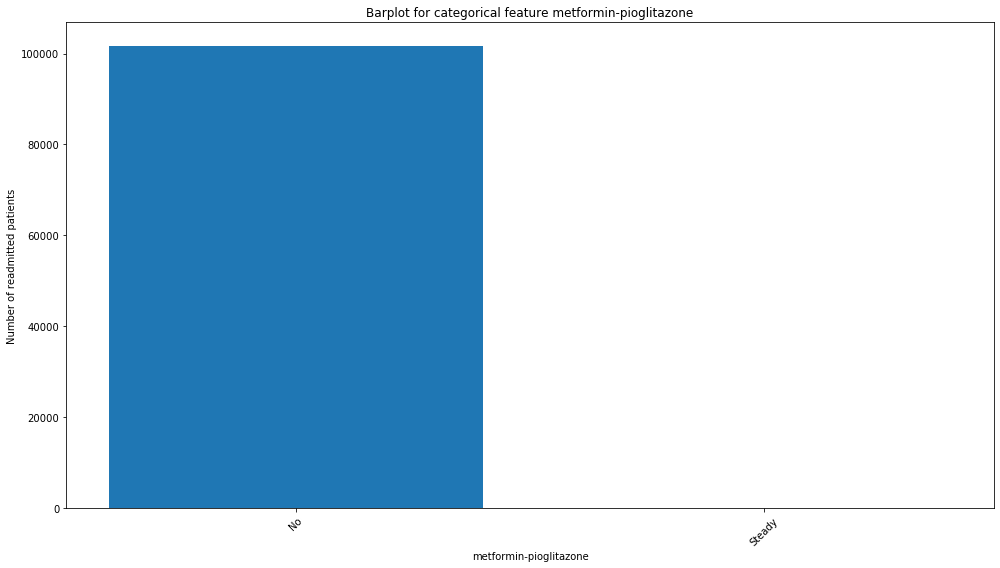

change  has data type  object  has  2  unique values


diabetesMed  has data type  object  has  2  unique values


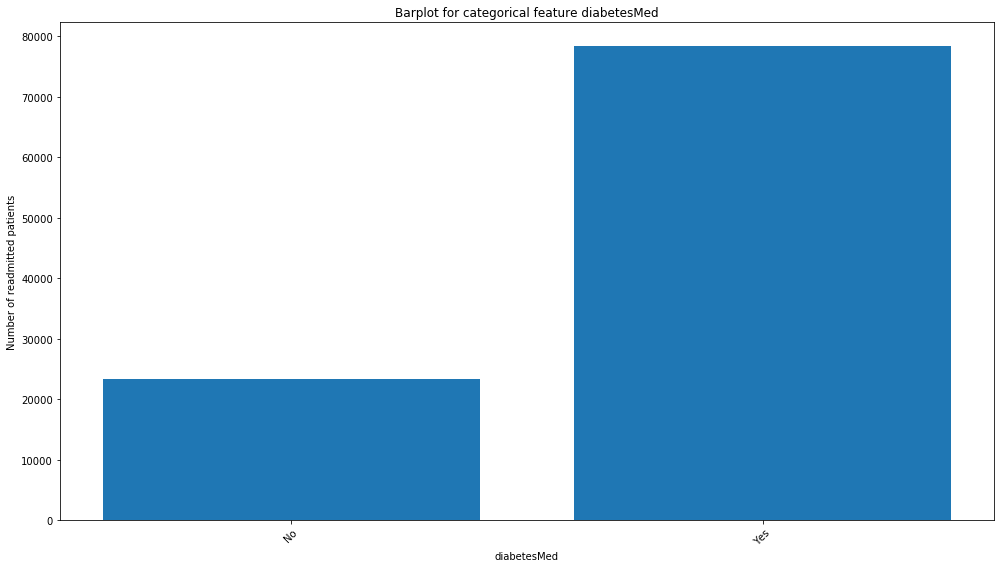

readmitted  has data type  object  has  3  unique values


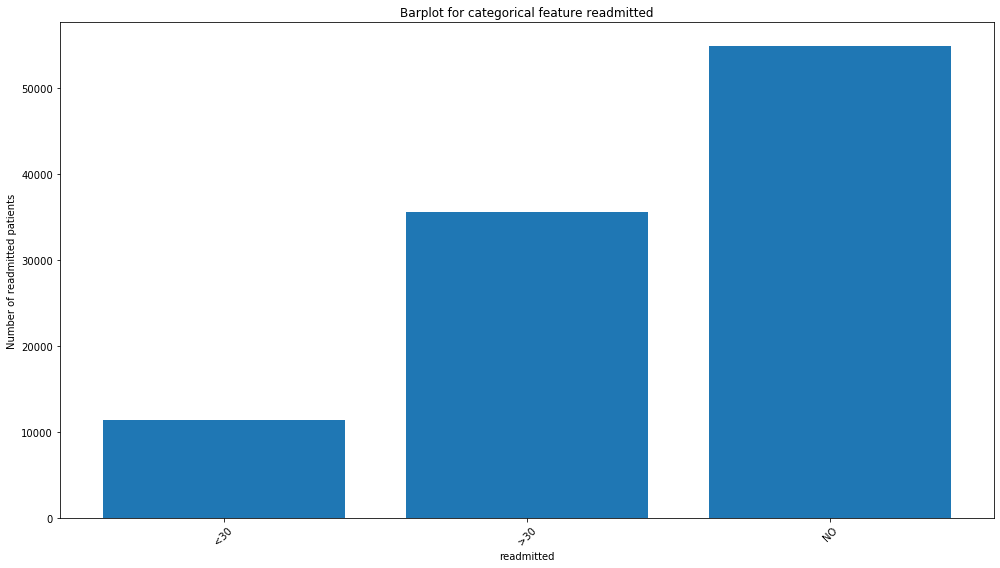

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

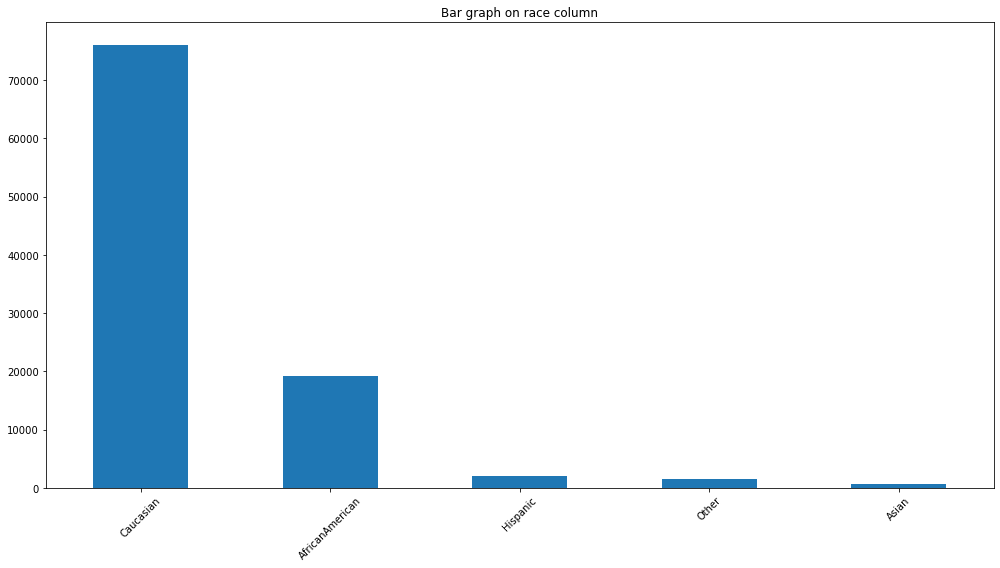

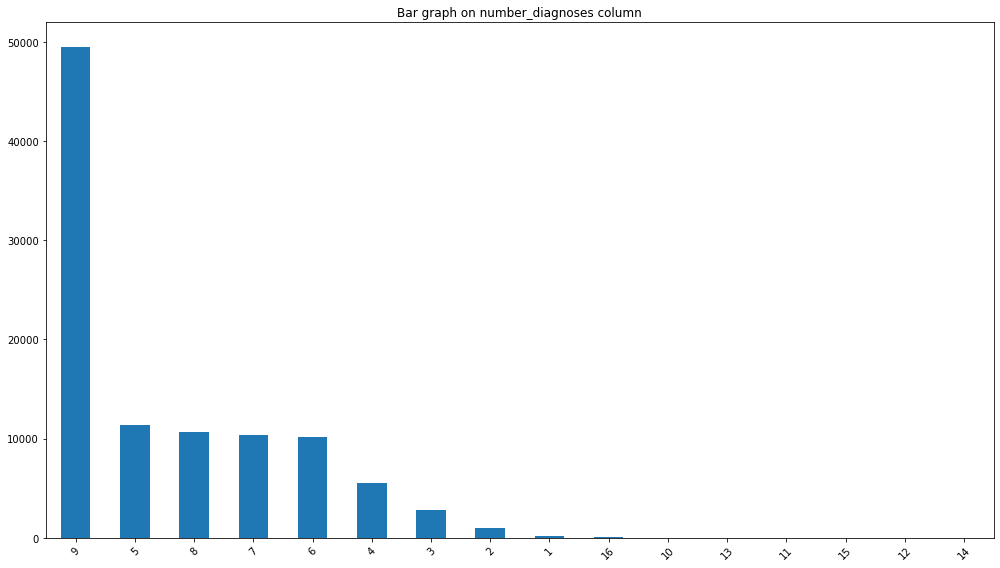


So the columns which have missing values are: 
race 2273
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 1464
diag_2 7028
diag_3 13565


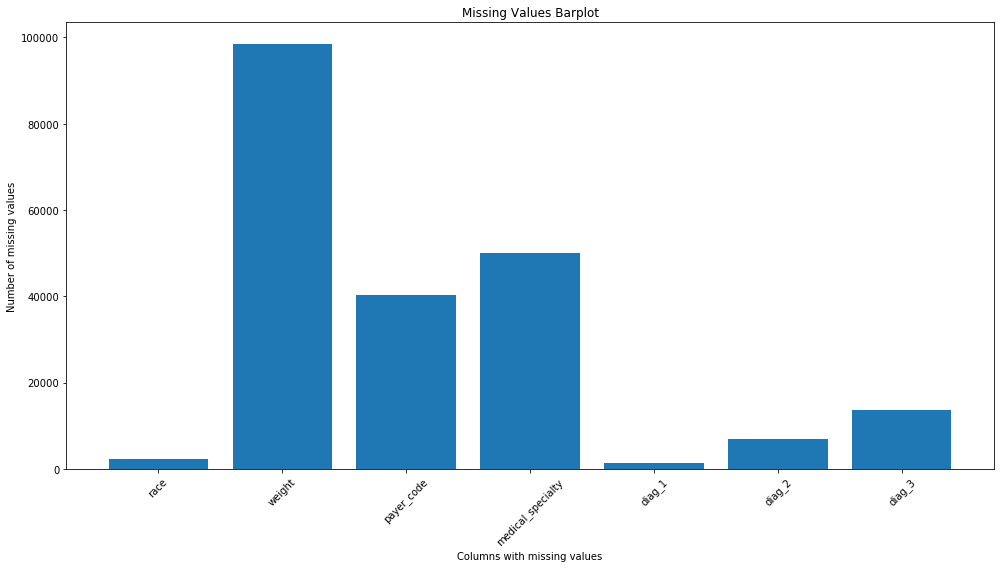


Dataset size is  101766
Percentage of missing values in data :
 encounter_id                 0.00
patient_nbr                  0.00
race                         2.23
gender                       0.00
age                          0.00
weight                      96.86
admission_type_id            0.00
discharge_disposition_id     0.00
admission_source_id          0.00
time_in_hospital             0.00
payer_code                  39.56
medical_specialty           49.08
num_lab_procedures           0.00
num_procedures               0.00
num_medications              0.00
number_outpatient            0.00
number_emergency             0.00
number_inpatient             0.00
diag_1                       1.44
diag_2                       6.91
diag_3                      13.33
number_diagnoses             0.00
max_glu_serum                0.00
A1Cresult                    0.00
metformin                    0.00
repaglinide                  0.00
nateglinide                  0.00
chlorpropamide   

<ggplot: (-9223371865149554772)>


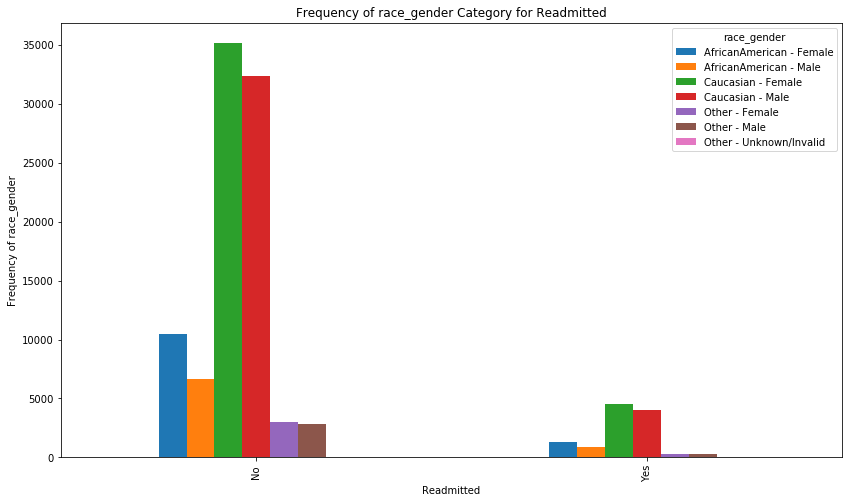

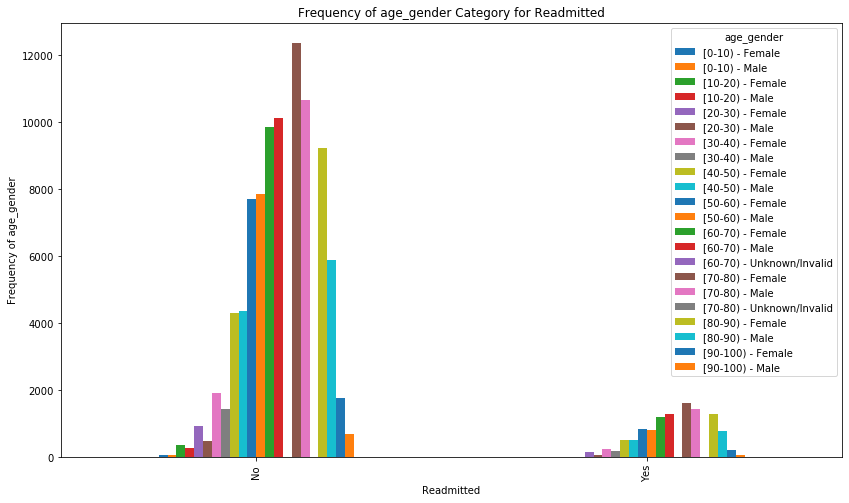

                                      admission_type_id  \
age_gender                readmitted                      
[0-10) - Female           No                   1.853659   
                          Yes                  3.000000   
[0-10) - Male             No                   1.697368   
                          Yes                  3.500000   
[10-20) - Female          No                   1.804233   
                          Yes                  1.750000   
[10-20) - Male            No                   1.695971   
                          Yes                  1.937500   
[20-30) - Female          No                   2.128068   
                          Yes                  1.790960   
[20-30) - Male            No                   1.574380   
                          Yes                  1.677966   
[30-40) - Female          No                   2.094271   
                          Yes                  2.008264   
[30-40) - Male            No                   1.929420 

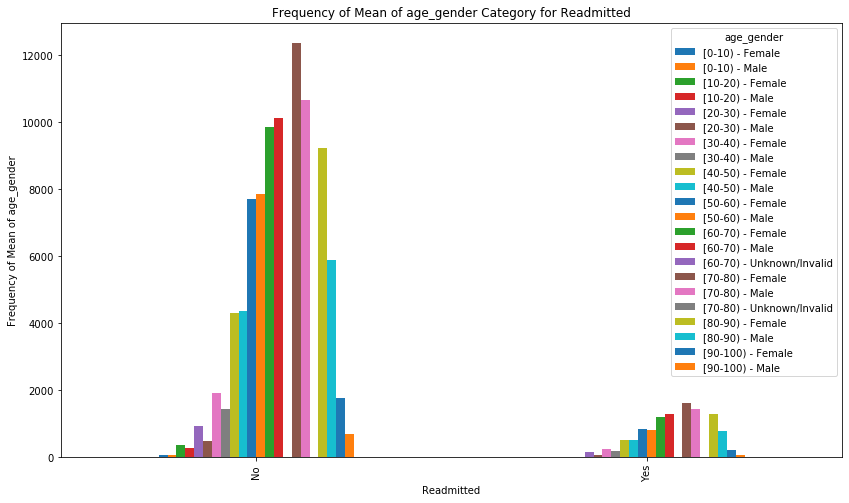

                                     admission_type_id  \
race_gender              readmitted                      
AfricanAmerican - Female No                   1.704929   
                         Yes                  1.662308   
AfricanAmerican - Male   No                   1.754791   
                         Yes                  1.667836   
Caucasian - Female       No                   2.090438   
                         Yes                  2.018640   
Caucasian - Male         No                   2.111248   
                         Yes                  2.071181   
Other - Female           No                   2.145382   
                         Yes                  2.205479   
Other - Male             No                   2.069596   
                         Yes                  2.075472   
Other - Unknown/Invalid  No                   1.666667   

                                     discharge_disposition_id  \
race_gender              readmitted                             

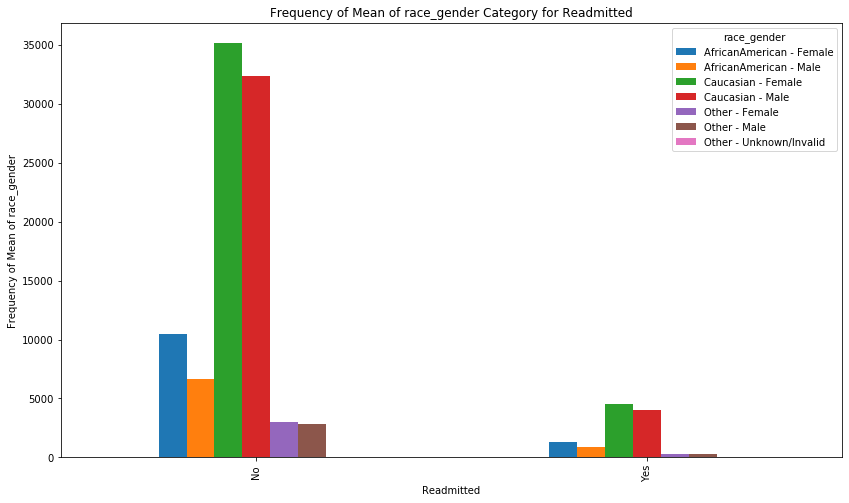

List of numeric columns are  ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'no_of_revisits']

For column  time_in_hospital  Min value is  1  Max value is  14
Column created by Binning: 
 0          (0.9, 5.3]
1          (0.9, 5.3]
2          (0.9, 5.3]
3          (0.9, 5.3]
4          (0.9, 5.3]
             ...     
101761     (0.9, 5.3]
101762     (0.9, 5.3]
101763     (0.9, 5.3]
101764    (9.7, 14.0]
101765     (5.3, 9.7]
Name: time_in_hospitalBin, Length: 101766, dtype: category
Categories (3, interval[float64]): [(0.9, 5.3] < (5.3, 9.7] < (9.7, 14.0]]

For column  num_lab_procedures  Min value is  1  Max value is  132
Column created by Binning: 
 0          (0.9, 44.7]
1         (44.7, 88.3]
2          (0.9, 44.7]
3          (0.9, 44.7]
4         (44.7, 88.3]
              ...     
101761    (44.7, 88.3]
101762     (0.9, 44.7]
101763    (44.7, 88.3]
101764    (44.7, 8

[60-70)   is  9
[50-60)   is  8
[80-90)   is  7
[40-50)   is  6
[30-40)   is  5
[90-100)   is  4
[20-30)   is  3
[10-20)   is  2
[0-10)   is  1
admission_type_id  has data type  int64  has  8  unique values
discharge_disposition_id  has data type  int64  has  26  unique values
admission_source_id  has data type  int64  has  17  unique values
time_in_hospital  has data type  int64  has  14  unique values
medical_specialty  has data type  object  has  73  unique values
num_lab_procedures  has data type  int64  has  118  unique values
num_procedures  has data type  int64  has  7  unique values
num_medications  has data type  int64  has  75  unique values
number_outpatient  has data type  int64  has  39  unique values
number_emergency  has data type  int64  has  33  unique values
number_inpatient  has data type  int64  has  21  unique values
diag_1  has data type  object  has  20  unique values
diag_2  has data type  object  has  20  unique values
diag_3  has data type  object  has  20  un

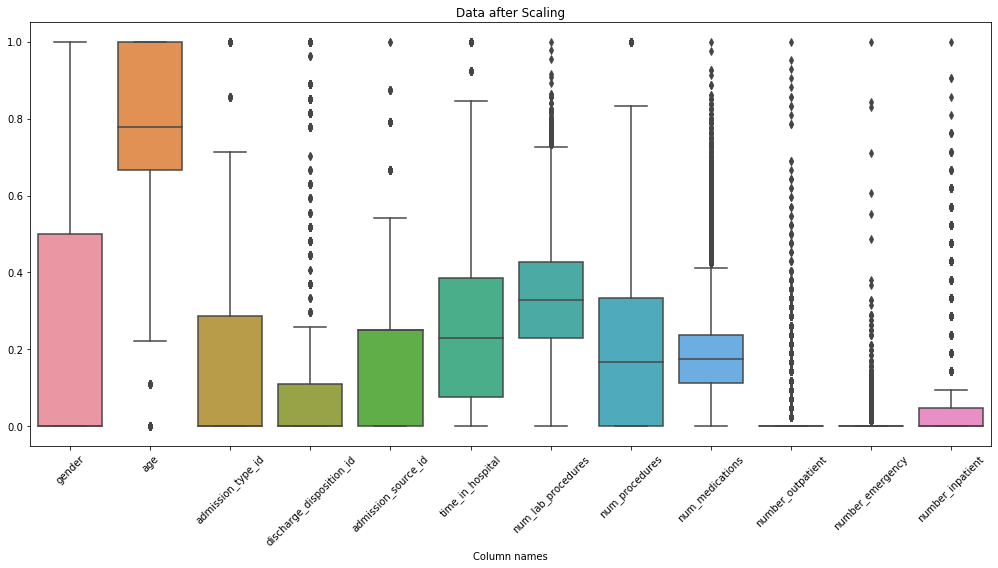

New data after Scaling is 
    gender       age  admission_type_id  discharge_disposition_id  \
0     0.0  0.000000           0.714286                  0.888889   
1     0.0  0.111111           0.000000                  0.000000   
2     0.0  0.222222           0.000000                  0.000000   
3     0.5  0.444444           0.000000                  0.000000   
4     0.5  0.555556           0.000000                  0.000000   

   admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0                 0.00          0.000000            0.305344        0.000000   
1                 0.25          0.153846            0.442748        0.000000   
2                 0.25          0.076923            0.076336        0.833333   
3                 0.25          0.076923            0.328244        0.166667   
4                 0.25          0.000000            0.381679        0.000000   

   num_medications  number_outpatient  ...  age_genderPct_4.727512135683824  \
0  

z_score value is  101766 416 
 [[0.92739675 3.86602933 2.75079957 ... 0.35554944 0.36702153 0.39914526]
 [0.92739675 3.31528336 0.70846069 ... 0.35554944 0.36702153 0.39914526]
 [0.92739675 2.76453739 0.70846069 ... 0.35554944 0.36702153 0.39914526]
 ...
 [1.07803147 1.09068441 0.70846069 ... 0.35554944 2.72463583 0.39914526]
 [0.92739675 0.56155351 0.01660864 ... 0.35554944 0.36702153 0.39914526]
 [1.07803147 1.09068441 0.70846069 ... 0.35554944 2.72463583 0.39914526]]
Entries which are outliers are  (array([     0,      0,      0, ..., 101765, 101765, 101765], dtype=int64), array([  1,   3,  12, ..., 344, 360, 379], dtype=int64))
Original shape of data is  (101766, 416)
Final shape of data without outliers(Z Score based) is  (2629, 416)
Hence from z score based outlier detection we got  99137  outliers

Z score based Outliers removed data is 
         gender       age  admission_type_id  discharge_disposition_id  \
7          0.5  1.000000           0.000000                  0.000000

        gender       age  admission_type_id  discharge_disposition_id  \
0          NaN  0.000000                NaN                  0.888889   
1          NaN  0.111111                NaN                       NaN   
2          NaN       NaN                NaN                       NaN   
3          NaN       NaN                NaN                       NaN   
4          NaN       NaN                NaN                       NaN   
...        ...       ...                ...                       ...   
101761     NaN       NaN                NaN                       NaN   
101762     NaN       NaN                NaN                       NaN   
101763     NaN       NaN                NaN                       NaN   
101764     NaN       NaN                NaN                       NaN   
101765     NaN       NaN                NaN                       NaN   

        admission_source_id  time_in_hospital  num_lab_procedures  \
0                       NaN               NaN         

DBScan based Outlier Detection has  23996  outliers
row  2  is an outlier
row  9  is an outlier
row  11  is an outlier
row  12  is an outlier
row  15  is an outlier
row  17  is an outlier
row  19  is an outlier
row  28  is an outlier
row  30  is an outlier
row  32  is an outlier
row  50  is an outlier
row  54  is an outlier
row  63  is an outlier
row  65  is an outlier
row  73  is an outlier
row  87  is an outlier
row  98  is an outlier
row  99  is an outlier
row  105  is an outlier
row  106  is an outlier
row  111  is an outlier
row  121  is an outlier
row  123  is an outlier
row  125  is an outlier
row  127  is an outlier
row  129  is an outlier
row  131  is an outlier
row  132  is an outlier
row  134  is an outlier
row  135  is an outlier
row  136  is an outlier
row  140  is an outlier
row  143  is an outlier
row  145  is an outlier
row  148  is an outlier
row  151  is an outlier
row  159  is an outlier
row  163  is an outlier
row  165  is an outlier
row  169  is an outlier
row  174

row  1912  is an outlier
row  1913  is an outlier
row  1926  is an outlier
row  1927  is an outlier
row  1930  is an outlier
row  1934  is an outlier
row  1935  is an outlier
row  1938  is an outlier
row  1939  is an outlier
row  1941  is an outlier
row  1942  is an outlier
row  1946  is an outlier
row  1955  is an outlier
row  1961  is an outlier
row  1964  is an outlier
row  1966  is an outlier
row  1970  is an outlier
row  1971  is an outlier
row  1973  is an outlier
row  1975  is an outlier
row  1982  is an outlier
row  1983  is an outlier
row  1984  is an outlier
row  1992  is an outlier
row  2001  is an outlier
row  2003  is an outlier
row  2008  is an outlier
row  2014  is an outlier
row  2016  is an outlier
row  2017  is an outlier
row  2024  is an outlier
row  2037  is an outlier
row  2042  is an outlier
row  2044  is an outlier
row  2049  is an outlier
row  2054  is an outlier
row  2055  is an outlier
row  2066  is an outlier
row  2071  is an outlier
row  2073  is an outlier


row  3659  is an outlier
row  3662  is an outlier
row  3665  is an outlier
row  3679  is an outlier
row  3685  is an outlier
row  3686  is an outlier
row  3687  is an outlier
row  3688  is an outlier
row  3693  is an outlier
row  3694  is an outlier
row  3701  is an outlier
row  3706  is an outlier
row  3710  is an outlier
row  3714  is an outlier
row  3721  is an outlier
row  3724  is an outlier
row  3727  is an outlier
row  3728  is an outlier
row  3731  is an outlier
row  3733  is an outlier
row  3736  is an outlier
row  3741  is an outlier
row  3744  is an outlier
row  3745  is an outlier
row  3755  is an outlier
row  3761  is an outlier
row  3767  is an outlier
row  3768  is an outlier
row  3771  is an outlier
row  3773  is an outlier
row  3774  is an outlier
row  3777  is an outlier
row  3779  is an outlier
row  3782  is an outlier
row  3786  is an outlier
row  3789  is an outlier
row  3795  is an outlier
row  3798  is an outlier
row  3800  is an outlier
row  3803  is an outlier


row  5483  is an outlier
row  5485  is an outlier
row  5489  is an outlier
row  5495  is an outlier
row  5496  is an outlier
row  5508  is an outlier
row  5509  is an outlier
row  5511  is an outlier
row  5512  is an outlier
row  5513  is an outlier
row  5520  is an outlier
row  5523  is an outlier
row  5533  is an outlier
row  5534  is an outlier
row  5535  is an outlier
row  5541  is an outlier
row  5542  is an outlier
row  5543  is an outlier
row  5544  is an outlier
row  5548  is an outlier
row  5556  is an outlier
row  5558  is an outlier
row  5559  is an outlier
row  5563  is an outlier
row  5566  is an outlier
row  5568  is an outlier
row  5579  is an outlier
row  5580  is an outlier
row  5581  is an outlier
row  5582  is an outlier
row  5587  is an outlier
row  5598  is an outlier
row  5599  is an outlier
row  5601  is an outlier
row  5603  is an outlier
row  5608  is an outlier
row  5609  is an outlier
row  5611  is an outlier
row  5621  is an outlier
row  5622  is an outlier


row  6872  is an outlier
row  6876  is an outlier
row  6879  is an outlier
row  6880  is an outlier
row  6881  is an outlier
row  6886  is an outlier
row  6889  is an outlier
row  6894  is an outlier
row  6903  is an outlier
row  6906  is an outlier
row  6907  is an outlier
row  6908  is an outlier
row  6919  is an outlier
row  6921  is an outlier
row  6922  is an outlier
row  6923  is an outlier
row  6927  is an outlier
row  6928  is an outlier
row  6930  is an outlier
row  6934  is an outlier
row  6935  is an outlier
row  6940  is an outlier
row  6946  is an outlier
row  6948  is an outlier
row  6953  is an outlier
row  6954  is an outlier
row  6957  is an outlier
row  6963  is an outlier
row  6964  is an outlier
row  6968  is an outlier
row  6971  is an outlier
row  6976  is an outlier
row  6983  is an outlier
row  6994  is an outlier
row  7001  is an outlier
row  7002  is an outlier
row  7004  is an outlier
row  7007  is an outlier
row  7008  is an outlier
row  7017  is an outlier


row  8533  is an outlier
row  8535  is an outlier
row  8541  is an outlier
row  8542  is an outlier
row  8543  is an outlier
row  8544  is an outlier
row  8545  is an outlier
row  8559  is an outlier
row  8570  is an outlier
row  8574  is an outlier
row  8575  is an outlier
row  8585  is an outlier
row  8586  is an outlier
row  8588  is an outlier
row  8590  is an outlier
row  8593  is an outlier
row  8597  is an outlier
row  8600  is an outlier
row  8610  is an outlier
row  8614  is an outlier
row  8615  is an outlier
row  8621  is an outlier
row  8624  is an outlier
row  8628  is an outlier
row  8636  is an outlier
row  8647  is an outlier
row  8650  is an outlier
row  8653  is an outlier
row  8659  is an outlier
row  8660  is an outlier
row  8662  is an outlier
row  8663  is an outlier
row  8667  is an outlier
row  8670  is an outlier
row  8671  is an outlier
row  8672  is an outlier
row  8674  is an outlier
row  8682  is an outlier
row  8691  is an outlier
row  8698  is an outlier


row  10318  is an outlier
row  10319  is an outlier
row  10328  is an outlier
row  10331  is an outlier
row  10334  is an outlier
row  10337  is an outlier
row  10339  is an outlier
row  10345  is an outlier
row  10347  is an outlier
row  10357  is an outlier
row  10368  is an outlier
row  10369  is an outlier
row  10372  is an outlier
row  10376  is an outlier
row  10380  is an outlier
row  10392  is an outlier
row  10399  is an outlier
row  10408  is an outlier
row  10412  is an outlier
row  10415  is an outlier
row  10418  is an outlier
row  10419  is an outlier
row  10421  is an outlier
row  10423  is an outlier
row  10428  is an outlier
row  10430  is an outlier
row  10431  is an outlier
row  10438  is an outlier
row  10442  is an outlier
row  10444  is an outlier
row  10456  is an outlier
row  10472  is an outlier
row  10475  is an outlier
row  10484  is an outlier
row  10486  is an outlier
row  10487  is an outlier
row  10490  is an outlier
row  10494  is an outlier
row  10495  

row  12593  is an outlier
row  12600  is an outlier
row  12604  is an outlier
row  12611  is an outlier
row  12613  is an outlier
row  12615  is an outlier
row  12616  is an outlier
row  12619  is an outlier
row  12621  is an outlier
row  12622  is an outlier
row  12626  is an outlier
row  12630  is an outlier
row  12633  is an outlier
row  12646  is an outlier
row  12649  is an outlier
row  12653  is an outlier
row  12655  is an outlier
row  12658  is an outlier
row  12660  is an outlier
row  12661  is an outlier
row  12663  is an outlier
row  12673  is an outlier
row  12677  is an outlier
row  12680  is an outlier
row  12683  is an outlier
row  12686  is an outlier
row  12687  is an outlier
row  12693  is an outlier
row  12694  is an outlier
row  12696  is an outlier
row  12697  is an outlier
row  12700  is an outlier
row  12703  is an outlier
row  12705  is an outlier
row  12706  is an outlier
row  12709  is an outlier
row  12714  is an outlier
row  12727  is an outlier
row  12731  

row  14838  is an outlier
row  14844  is an outlier
row  14847  is an outlier
row  14857  is an outlier
row  14858  is an outlier
row  14864  is an outlier
row  14872  is an outlier
row  14873  is an outlier
row  14878  is an outlier
row  14880  is an outlier
row  14887  is an outlier
row  14890  is an outlier
row  14895  is an outlier
row  14896  is an outlier
row  14897  is an outlier
row  14898  is an outlier
row  14900  is an outlier
row  14901  is an outlier
row  14909  is an outlier
row  14910  is an outlier
row  14913  is an outlier
row  14915  is an outlier
row  14918  is an outlier
row  14919  is an outlier
row  14922  is an outlier
row  14930  is an outlier
row  14946  is an outlier
row  14947  is an outlier
row  14951  is an outlier
row  14962  is an outlier
row  14966  is an outlier
row  14971  is an outlier
row  14974  is an outlier
row  14977  is an outlier
row  14979  is an outlier
row  14981  is an outlier
row  14982  is an outlier
row  14988  is an outlier
row  14998  

row  16444  is an outlier
row  16447  is an outlier
row  16448  is an outlier
row  16451  is an outlier
row  16454  is an outlier
row  16464  is an outlier
row  16470  is an outlier
row  16475  is an outlier
row  16477  is an outlier
row  16479  is an outlier
row  16480  is an outlier
row  16481  is an outlier
row  16488  is an outlier
row  16490  is an outlier
row  16495  is an outlier
row  16496  is an outlier
row  16497  is an outlier
row  16499  is an outlier
row  16500  is an outlier
row  16509  is an outlier
row  16510  is an outlier
row  16511  is an outlier
row  16514  is an outlier
row  16522  is an outlier
row  16524  is an outlier
row  16525  is an outlier
row  16526  is an outlier
row  16527  is an outlier
row  16528  is an outlier
row  16534  is an outlier
row  16538  is an outlier
row  16540  is an outlier
row  16545  is an outlier
row  16548  is an outlier
row  16549  is an outlier
row  16551  is an outlier
row  16557  is an outlier
row  16563  is an outlier
row  16564  

row  17973  is an outlier
row  17974  is an outlier
row  17975  is an outlier
row  17977  is an outlier
row  17978  is an outlier
row  17981  is an outlier
row  17984  is an outlier
row  17987  is an outlier
row  17990  is an outlier
row  17991  is an outlier
row  18000  is an outlier
row  18001  is an outlier
row  18004  is an outlier
row  18007  is an outlier
row  18008  is an outlier
row  18011  is an outlier
row  18012  is an outlier
row  18014  is an outlier
row  18019  is an outlier
row  18024  is an outlier
row  18028  is an outlier
row  18031  is an outlier
row  18036  is an outlier
row  18041  is an outlier
row  18051  is an outlier
row  18056  is an outlier
row  18057  is an outlier
row  18059  is an outlier
row  18060  is an outlier
row  18061  is an outlier
row  18067  is an outlier
row  18068  is an outlier
row  18069  is an outlier
row  18070  is an outlier
row  18073  is an outlier
row  18075  is an outlier
row  18076  is an outlier
row  18080  is an outlier
row  18081  

row  19398  is an outlier
row  19403  is an outlier
row  19404  is an outlier
row  19409  is an outlier
row  19410  is an outlier
row  19411  is an outlier
row  19413  is an outlier
row  19419  is an outlier
row  19421  is an outlier
row  19422  is an outlier
row  19426  is an outlier
row  19429  is an outlier
row  19434  is an outlier
row  19439  is an outlier
row  19441  is an outlier
row  19451  is an outlier
row  19458  is an outlier
row  19463  is an outlier
row  19465  is an outlier
row  19472  is an outlier
row  19475  is an outlier
row  19476  is an outlier
row  19478  is an outlier
row  19491  is an outlier
row  19499  is an outlier
row  19500  is an outlier
row  19501  is an outlier
row  19504  is an outlier
row  19505  is an outlier
row  19506  is an outlier
row  19507  is an outlier
row  19514  is an outlier
row  19515  is an outlier
row  19516  is an outlier
row  19525  is an outlier
row  19526  is an outlier
row  19529  is an outlier
row  19530  is an outlier
row  19536  

row  21051  is an outlier
row  21052  is an outlier
row  21058  is an outlier
row  21059  is an outlier
row  21060  is an outlier
row  21062  is an outlier
row  21066  is an outlier
row  21068  is an outlier
row  21069  is an outlier
row  21072  is an outlier
row  21077  is an outlier
row  21080  is an outlier
row  21093  is an outlier
row  21095  is an outlier
row  21096  is an outlier
row  21100  is an outlier
row  21101  is an outlier
row  21102  is an outlier
row  21107  is an outlier
row  21108  is an outlier
row  21118  is an outlier
row  21124  is an outlier
row  21125  is an outlier
row  21126  is an outlier
row  21128  is an outlier
row  21129  is an outlier
row  21130  is an outlier
row  21133  is an outlier
row  21135  is an outlier
row  21137  is an outlier
row  21141  is an outlier
row  21144  is an outlier
row  21146  is an outlier
row  21150  is an outlier
row  21153  is an outlier
row  21159  is an outlier
row  21164  is an outlier
row  21168  is an outlier
row  21170  

row  22540  is an outlier
row  22541  is an outlier
row  22549  is an outlier
row  22558  is an outlier
row  22565  is an outlier
row  22566  is an outlier
row  22572  is an outlier
row  22574  is an outlier
row  22576  is an outlier
row  22582  is an outlier
row  22584  is an outlier
row  22591  is an outlier
row  22594  is an outlier
row  22599  is an outlier
row  22601  is an outlier
row  22605  is an outlier
row  22606  is an outlier
row  22608  is an outlier
row  22613  is an outlier
row  22616  is an outlier
row  22620  is an outlier
row  22621  is an outlier
row  22625  is an outlier
row  22632  is an outlier
row  22637  is an outlier
row  22640  is an outlier
row  22641  is an outlier
row  22642  is an outlier
row  22644  is an outlier
row  22646  is an outlier
row  22651  is an outlier
row  22655  is an outlier
row  22656  is an outlier
row  22658  is an outlier
row  22661  is an outlier
row  22666  is an outlier
row  22667  is an outlier
row  22672  is an outlier
row  22674  

row  24383  is an outlier
row  24385  is an outlier
row  24386  is an outlier
row  24387  is an outlier
row  24394  is an outlier
row  24397  is an outlier
row  24399  is an outlier
row  24402  is an outlier
row  24408  is an outlier
row  24409  is an outlier
row  24411  is an outlier
row  24417  is an outlier
row  24419  is an outlier
row  24421  is an outlier
row  24425  is an outlier
row  24433  is an outlier
row  24436  is an outlier
row  24438  is an outlier
row  24442  is an outlier
row  24444  is an outlier
row  24445  is an outlier
row  24446  is an outlier
row  24449  is an outlier
row  24450  is an outlier
row  24453  is an outlier
row  24469  is an outlier
row  24470  is an outlier
row  24471  is an outlier
row  24475  is an outlier
row  24486  is an outlier
row  24488  is an outlier
row  24491  is an outlier
row  24509  is an outlier
row  24516  is an outlier
row  24517  is an outlier
row  24521  is an outlier
row  24530  is an outlier
row  24531  is an outlier
row  24535  

row  26895  is an outlier
row  26906  is an outlier
row  26918  is an outlier
row  26923  is an outlier
row  26925  is an outlier
row  26928  is an outlier
row  26932  is an outlier
row  26933  is an outlier
row  26936  is an outlier
row  26942  is an outlier
row  26944  is an outlier
row  26946  is an outlier
row  26955  is an outlier
row  26960  is an outlier
row  26965  is an outlier
row  26969  is an outlier
row  26972  is an outlier
row  26975  is an outlier
row  26980  is an outlier
row  26981  is an outlier
row  26983  is an outlier
row  26991  is an outlier
row  26992  is an outlier
row  26995  is an outlier
row  26998  is an outlier
row  27003  is an outlier
row  27007  is an outlier
row  27008  is an outlier
row  27011  is an outlier
row  27016  is an outlier
row  27019  is an outlier
row  27024  is an outlier
row  27026  is an outlier
row  27028  is an outlier
row  27032  is an outlier
row  27036  is an outlier
row  27040  is an outlier
row  27042  is an outlier
row  27046  

row  28643  is an outlier
row  28653  is an outlier
row  28658  is an outlier
row  28659  is an outlier
row  28660  is an outlier
row  28671  is an outlier
row  28685  is an outlier
row  28688  is an outlier
row  28702  is an outlier
row  28703  is an outlier
row  28706  is an outlier
row  28708  is an outlier
row  28711  is an outlier
row  28715  is an outlier
row  28720  is an outlier
row  28722  is an outlier
row  28723  is an outlier
row  28725  is an outlier
row  28726  is an outlier
row  28728  is an outlier
row  28731  is an outlier
row  28733  is an outlier
row  28740  is an outlier
row  28742  is an outlier
row  28746  is an outlier
row  28747  is an outlier
row  28748  is an outlier
row  28755  is an outlier
row  28759  is an outlier
row  28761  is an outlier
row  28764  is an outlier
row  28768  is an outlier
row  28770  is an outlier
row  28778  is an outlier
row  28779  is an outlier
row  28789  is an outlier
row  28794  is an outlier
row  28795  is an outlier
row  28796  

row  30888  is an outlier
row  30890  is an outlier
row  30891  is an outlier
row  30894  is an outlier
row  30899  is an outlier
row  30900  is an outlier
row  30901  is an outlier
row  30905  is an outlier
row  30906  is an outlier
row  30909  is an outlier
row  30913  is an outlier
row  30914  is an outlier
row  30920  is an outlier
row  30922  is an outlier
row  30923  is an outlier
row  30926  is an outlier
row  30935  is an outlier
row  30939  is an outlier
row  30941  is an outlier
row  30948  is an outlier
row  30950  is an outlier
row  30953  is an outlier
row  30955  is an outlier
row  30957  is an outlier
row  30958  is an outlier
row  30959  is an outlier
row  30971  is an outlier
row  30972  is an outlier
row  30976  is an outlier
row  30978  is an outlier
row  30983  is an outlier
row  30987  is an outlier
row  30988  is an outlier
row  30989  is an outlier
row  30995  is an outlier
row  30996  is an outlier
row  30999  is an outlier
row  31001  is an outlier
row  31004  

row  32631  is an outlier
row  32637  is an outlier
row  32642  is an outlier
row  32652  is an outlier
row  32662  is an outlier
row  32665  is an outlier
row  32670  is an outlier
row  32672  is an outlier
row  32673  is an outlier
row  32678  is an outlier
row  32680  is an outlier
row  32682  is an outlier
row  32686  is an outlier
row  32687  is an outlier
row  32690  is an outlier
row  32692  is an outlier
row  32699  is an outlier
row  32709  is an outlier
row  32710  is an outlier
row  32714  is an outlier
row  32719  is an outlier
row  32721  is an outlier
row  32722  is an outlier
row  32723  is an outlier
row  32727  is an outlier
row  32728  is an outlier
row  32735  is an outlier
row  32736  is an outlier
row  32737  is an outlier
row  32743  is an outlier
row  32745  is an outlier
row  32746  is an outlier
row  32747  is an outlier
row  32752  is an outlier
row  32753  is an outlier
row  32754  is an outlier
row  32756  is an outlier
row  32757  is an outlier
row  32764  

row  34055  is an outlier
row  34062  is an outlier
row  34063  is an outlier
row  34064  is an outlier
row  34072  is an outlier
row  34074  is an outlier
row  34078  is an outlier
row  34081  is an outlier
row  34082  is an outlier
row  34085  is an outlier
row  34088  is an outlier
row  34092  is an outlier
row  34094  is an outlier
row  34101  is an outlier
row  34113  is an outlier
row  34120  is an outlier
row  34122  is an outlier
row  34124  is an outlier
row  34127  is an outlier
row  34132  is an outlier
row  34134  is an outlier
row  34135  is an outlier
row  34137  is an outlier
row  34138  is an outlier
row  34141  is an outlier
row  34149  is an outlier
row  34153  is an outlier
row  34159  is an outlier
row  34164  is an outlier
row  34165  is an outlier
row  34171  is an outlier
row  34174  is an outlier
row  34176  is an outlier
row  34185  is an outlier
row  34187  is an outlier
row  34189  is an outlier
row  34195  is an outlier
row  34199  is an outlier
row  34207  

row  35140  is an outlier
row  35142  is an outlier
row  35145  is an outlier
row  35147  is an outlier
row  35150  is an outlier
row  35151  is an outlier
row  35157  is an outlier
row  35160  is an outlier
row  35165  is an outlier
row  35169  is an outlier
row  35170  is an outlier
row  35172  is an outlier
row  35177  is an outlier
row  35181  is an outlier
row  35182  is an outlier
row  35184  is an outlier
row  35185  is an outlier
row  35188  is an outlier
row  35195  is an outlier
row  35196  is an outlier
row  35198  is an outlier
row  35204  is an outlier
row  35205  is an outlier
row  35212  is an outlier
row  35216  is an outlier
row  35218  is an outlier
row  35219  is an outlier
row  35226  is an outlier
row  35228  is an outlier
row  35231  is an outlier
row  35241  is an outlier
row  35242  is an outlier
row  35250  is an outlier
row  35260  is an outlier
row  35262  is an outlier
row  35269  is an outlier
row  35276  is an outlier
row  35287  is an outlier
row  35294  

row  36776  is an outlier
row  36778  is an outlier
row  36782  is an outlier
row  36788  is an outlier
row  36789  is an outlier
row  36793  is an outlier
row  36796  is an outlier
row  36798  is an outlier
row  36813  is an outlier
row  36814  is an outlier
row  36826  is an outlier
row  36831  is an outlier
row  36834  is an outlier
row  36836  is an outlier
row  36840  is an outlier
row  36843  is an outlier
row  36845  is an outlier
row  36852  is an outlier
row  36854  is an outlier
row  36856  is an outlier
row  36858  is an outlier
row  36863  is an outlier
row  36864  is an outlier
row  36866  is an outlier
row  36877  is an outlier
row  36879  is an outlier
row  36888  is an outlier
row  36889  is an outlier
row  36892  is an outlier
row  36895  is an outlier
row  36896  is an outlier
row  36900  is an outlier
row  36901  is an outlier
row  36916  is an outlier
row  36917  is an outlier
row  36920  is an outlier
row  36926  is an outlier
row  36928  is an outlier
row  36939  

row  38348  is an outlier
row  38352  is an outlier
row  38353  is an outlier
row  38358  is an outlier
row  38359  is an outlier
row  38362  is an outlier
row  38364  is an outlier
row  38365  is an outlier
row  38369  is an outlier
row  38372  is an outlier
row  38383  is an outlier
row  38391  is an outlier
row  38394  is an outlier
row  38399  is an outlier
row  38400  is an outlier
row  38402  is an outlier
row  38404  is an outlier
row  38409  is an outlier
row  38410  is an outlier
row  38411  is an outlier
row  38414  is an outlier
row  38418  is an outlier
row  38424  is an outlier
row  38425  is an outlier
row  38427  is an outlier
row  38429  is an outlier
row  38431  is an outlier
row  38432  is an outlier
row  38436  is an outlier
row  38440  is an outlier
row  38441  is an outlier
row  38442  is an outlier
row  38443  is an outlier
row  38445  is an outlier
row  38447  is an outlier
row  38448  is an outlier
row  38450  is an outlier
row  38451  is an outlier
row  38454  

row  39623  is an outlier
row  39624  is an outlier
row  39626  is an outlier
row  39632  is an outlier
row  39633  is an outlier
row  39634  is an outlier
row  39637  is an outlier
row  39644  is an outlier
row  39646  is an outlier
row  39650  is an outlier
row  39652  is an outlier
row  39654  is an outlier
row  39662  is an outlier
row  39667  is an outlier
row  39669  is an outlier
row  39673  is an outlier
row  39684  is an outlier
row  39688  is an outlier
row  39694  is an outlier
row  39699  is an outlier
row  39700  is an outlier
row  39702  is an outlier
row  39715  is an outlier
row  39716  is an outlier
row  39723  is an outlier
row  39724  is an outlier
row  39726  is an outlier
row  39732  is an outlier
row  39733  is an outlier
row  39734  is an outlier
row  39736  is an outlier
row  39738  is an outlier
row  39739  is an outlier
row  39740  is an outlier
row  39745  is an outlier
row  39752  is an outlier
row  39753  is an outlier
row  39754  is an outlier
row  39756  

row  41300  is an outlier
row  41301  is an outlier
row  41303  is an outlier
row  41304  is an outlier
row  41305  is an outlier
row  41306  is an outlier
row  41308  is an outlier
row  41311  is an outlier
row  41314  is an outlier
row  41315  is an outlier
row  41316  is an outlier
row  41317  is an outlier
row  41322  is an outlier
row  41324  is an outlier
row  41335  is an outlier
row  41336  is an outlier
row  41337  is an outlier
row  41348  is an outlier
row  41356  is an outlier
row  41357  is an outlier
row  41365  is an outlier
row  41366  is an outlier
row  41369  is an outlier
row  41381  is an outlier
row  41386  is an outlier
row  41394  is an outlier
row  41398  is an outlier
row  41406  is an outlier
row  41420  is an outlier
row  41435  is an outlier
row  41440  is an outlier
row  41442  is an outlier
row  41445  is an outlier
row  41447  is an outlier
row  41450  is an outlier
row  41454  is an outlier
row  41457  is an outlier
row  41463  is an outlier
row  41465  

row  42907  is an outlier
row  42908  is an outlier
row  42913  is an outlier
row  42916  is an outlier
row  42918  is an outlier
row  42923  is an outlier
row  42926  is an outlier
row  42927  is an outlier
row  42937  is an outlier
row  42938  is an outlier
row  42942  is an outlier
row  42944  is an outlier
row  42948  is an outlier
row  42951  is an outlier
row  42958  is an outlier
row  42962  is an outlier
row  42966  is an outlier
row  42967  is an outlier
row  42977  is an outlier
row  42978  is an outlier
row  42979  is an outlier
row  42981  is an outlier
row  42983  is an outlier
row  42986  is an outlier
row  42990  is an outlier
row  42994  is an outlier
row  43006  is an outlier
row  43030  is an outlier
row  43031  is an outlier
row  43033  is an outlier
row  43034  is an outlier
row  43037  is an outlier
row  43038  is an outlier
row  43043  is an outlier
row  43048  is an outlier
row  43049  is an outlier
row  43053  is an outlier
row  43060  is an outlier
row  43061  

row  44784  is an outlier
row  44788  is an outlier
row  44791  is an outlier
row  44796  is an outlier
row  44798  is an outlier
row  44803  is an outlier
row  44809  is an outlier
row  44810  is an outlier
row  44814  is an outlier
row  44815  is an outlier
row  44816  is an outlier
row  44817  is an outlier
row  44827  is an outlier
row  44833  is an outlier
row  44836  is an outlier
row  44844  is an outlier
row  44850  is an outlier
row  44860  is an outlier
row  44871  is an outlier
row  44876  is an outlier
row  44880  is an outlier
row  44887  is an outlier
row  44889  is an outlier
row  44891  is an outlier
row  44892  is an outlier
row  44893  is an outlier
row  44895  is an outlier
row  44900  is an outlier
row  44905  is an outlier
row  44907  is an outlier
row  44910  is an outlier
row  44922  is an outlier
row  44923  is an outlier
row  44925  is an outlier
row  44927  is an outlier
row  44928  is an outlier
row  44932  is an outlier
row  44937  is an outlier
row  44946  

row  46371  is an outlier
row  46372  is an outlier
row  46373  is an outlier
row  46380  is an outlier
row  46386  is an outlier
row  46387  is an outlier
row  46388  is an outlier
row  46390  is an outlier
row  46397  is an outlier
row  46401  is an outlier
row  46403  is an outlier
row  46405  is an outlier
row  46410  is an outlier
row  46414  is an outlier
row  46417  is an outlier
row  46423  is an outlier
row  46430  is an outlier
row  46431  is an outlier
row  46432  is an outlier
row  46436  is an outlier
row  46442  is an outlier
row  46443  is an outlier
row  46444  is an outlier
row  46459  is an outlier
row  46463  is an outlier
row  46464  is an outlier
row  46470  is an outlier
row  46472  is an outlier
row  46475  is an outlier
row  46478  is an outlier
row  46489  is an outlier
row  46491  is an outlier
row  46494  is an outlier
row  46501  is an outlier
row  46512  is an outlier
row  46513  is an outlier
row  46522  is an outlier
row  46529  is an outlier
row  46532  

row  48544  is an outlier
row  48545  is an outlier
row  48546  is an outlier
row  48547  is an outlier
row  48556  is an outlier
row  48559  is an outlier
row  48560  is an outlier
row  48572  is an outlier
row  48587  is an outlier
row  48589  is an outlier
row  48592  is an outlier
row  48605  is an outlier
row  48606  is an outlier
row  48614  is an outlier
row  48621  is an outlier
row  48633  is an outlier
row  48634  is an outlier
row  48636  is an outlier
row  48638  is an outlier
row  48640  is an outlier
row  48653  is an outlier
row  48654  is an outlier
row  48657  is an outlier
row  48666  is an outlier
row  48667  is an outlier
row  48674  is an outlier
row  48676  is an outlier
row  48677  is an outlier
row  48679  is an outlier
row  48688  is an outlier
row  48692  is an outlier
row  48693  is an outlier
row  48695  is an outlier
row  48697  is an outlier
row  48700  is an outlier
row  48704  is an outlier
row  48710  is an outlier
row  48713  is an outlier
row  48714  

row  50467  is an outlier
row  50471  is an outlier
row  50472  is an outlier
row  50483  is an outlier
row  50493  is an outlier
row  50509  is an outlier
row  50516  is an outlier
row  50520  is an outlier
row  50525  is an outlier
row  50534  is an outlier
row  50538  is an outlier
row  50539  is an outlier
row  50544  is an outlier
row  50545  is an outlier
row  50562  is an outlier
row  50565  is an outlier
row  50573  is an outlier
row  50584  is an outlier
row  50592  is an outlier
row  50594  is an outlier
row  50604  is an outlier
row  50605  is an outlier
row  50606  is an outlier
row  50619  is an outlier
row  50620  is an outlier
row  50634  is an outlier
row  50637  is an outlier
row  50639  is an outlier
row  50642  is an outlier
row  50643  is an outlier
row  50645  is an outlier
row  50646  is an outlier
row  50647  is an outlier
row  50651  is an outlier
row  50655  is an outlier
row  50660  is an outlier
row  50664  is an outlier
row  50667  is an outlier
row  50670  

row  52245  is an outlier
row  52249  is an outlier
row  52254  is an outlier
row  52259  is an outlier
row  52260  is an outlier
row  52267  is an outlier
row  52273  is an outlier
row  52274  is an outlier
row  52276  is an outlier
row  52279  is an outlier
row  52286  is an outlier
row  52287  is an outlier
row  52288  is an outlier
row  52289  is an outlier
row  52294  is an outlier
row  52295  is an outlier
row  52304  is an outlier
row  52305  is an outlier
row  52309  is an outlier
row  52311  is an outlier
row  52312  is an outlier
row  52317  is an outlier
row  52318  is an outlier
row  52322  is an outlier
row  52325  is an outlier
row  52333  is an outlier
row  52338  is an outlier
row  52342  is an outlier
row  52346  is an outlier
row  52347  is an outlier
row  52350  is an outlier
row  52356  is an outlier
row  52358  is an outlier
row  52359  is an outlier
row  52361  is an outlier
row  52362  is an outlier
row  52366  is an outlier
row  52368  is an outlier
row  52369  

row  53849  is an outlier
row  53852  is an outlier
row  53857  is an outlier
row  53866  is an outlier
row  53868  is an outlier
row  53869  is an outlier
row  53875  is an outlier
row  53877  is an outlier
row  53878  is an outlier
row  53879  is an outlier
row  53888  is an outlier
row  53889  is an outlier
row  53890  is an outlier
row  53899  is an outlier
row  53900  is an outlier
row  53901  is an outlier
row  53902  is an outlier
row  53904  is an outlier
row  53914  is an outlier
row  53919  is an outlier
row  53924  is an outlier
row  53926  is an outlier
row  53928  is an outlier
row  53947  is an outlier
row  53950  is an outlier
row  53952  is an outlier
row  53956  is an outlier
row  53962  is an outlier
row  53987  is an outlier
row  53992  is an outlier
row  53993  is an outlier
row  53995  is an outlier
row  54001  is an outlier
row  54006  is an outlier
row  54007  is an outlier
row  54009  is an outlier
row  54010  is an outlier
row  54015  is an outlier
row  54017  

row  55279  is an outlier
row  55286  is an outlier
row  55289  is an outlier
row  55291  is an outlier
row  55300  is an outlier
row  55305  is an outlier
row  55309  is an outlier
row  55312  is an outlier
row  55316  is an outlier
row  55317  is an outlier
row  55322  is an outlier
row  55325  is an outlier
row  55326  is an outlier
row  55329  is an outlier
row  55335  is an outlier
row  55343  is an outlier
row  55354  is an outlier
row  55358  is an outlier
row  55360  is an outlier
row  55361  is an outlier
row  55366  is an outlier
row  55371  is an outlier
row  55373  is an outlier
row  55381  is an outlier
row  55386  is an outlier
row  55393  is an outlier
row  55397  is an outlier
row  55408  is an outlier
row  55410  is an outlier
row  55419  is an outlier
row  55429  is an outlier
row  55430  is an outlier
row  55432  is an outlier
row  55433  is an outlier
row  55435  is an outlier
row  55438  is an outlier
row  55448  is an outlier
row  55452  is an outlier
row  55459  

row  57174  is an outlier
row  57177  is an outlier
row  57178  is an outlier
row  57188  is an outlier
row  57197  is an outlier
row  57198  is an outlier
row  57199  is an outlier
row  57200  is an outlier
row  57204  is an outlier
row  57212  is an outlier
row  57214  is an outlier
row  57215  is an outlier
row  57218  is an outlier
row  57222  is an outlier
row  57235  is an outlier
row  57236  is an outlier
row  57237  is an outlier
row  57239  is an outlier
row  57245  is an outlier
row  57253  is an outlier
row  57254  is an outlier
row  57258  is an outlier
row  57265  is an outlier
row  57269  is an outlier
row  57271  is an outlier
row  57274  is an outlier
row  57277  is an outlier
row  57280  is an outlier
row  57293  is an outlier
row  57302  is an outlier
row  57303  is an outlier
row  57304  is an outlier
row  57316  is an outlier
row  57329  is an outlier
row  57335  is an outlier
row  57345  is an outlier
row  57347  is an outlier
row  57348  is an outlier
row  57364  

row  59167  is an outlier
row  59169  is an outlier
row  59176  is an outlier
row  59179  is an outlier
row  59185  is an outlier
row  59187  is an outlier
row  59188  is an outlier
row  59189  is an outlier
row  59211  is an outlier
row  59216  is an outlier
row  59232  is an outlier
row  59237  is an outlier
row  59239  is an outlier
row  59243  is an outlier
row  59245  is an outlier
row  59258  is an outlier
row  59264  is an outlier
row  59265  is an outlier
row  59266  is an outlier
row  59276  is an outlier
row  59283  is an outlier
row  59286  is an outlier
row  59295  is an outlier
row  59298  is an outlier
row  59306  is an outlier
row  59307  is an outlier
row  59310  is an outlier
row  59333  is an outlier
row  59335  is an outlier
row  59338  is an outlier
row  59340  is an outlier
row  59341  is an outlier
row  59347  is an outlier
row  59351  is an outlier
row  59355  is an outlier
row  59359  is an outlier
row  59361  is an outlier
row  59363  is an outlier
row  59367  

row  61087  is an outlier
row  61096  is an outlier
row  61099  is an outlier
row  61100  is an outlier
row  61101  is an outlier
row  61105  is an outlier
row  61108  is an outlier
row  61114  is an outlier
row  61115  is an outlier
row  61117  is an outlier
row  61123  is an outlier
row  61124  is an outlier
row  61126  is an outlier
row  61127  is an outlier
row  61128  is an outlier
row  61129  is an outlier
row  61130  is an outlier
row  61131  is an outlier
row  61138  is an outlier
row  61139  is an outlier
row  61140  is an outlier
row  61142  is an outlier
row  61156  is an outlier
row  61161  is an outlier
row  61162  is an outlier
row  61171  is an outlier
row  61175  is an outlier
row  61181  is an outlier
row  61182  is an outlier
row  61184  is an outlier
row  61188  is an outlier
row  61189  is an outlier
row  61193  is an outlier
row  61194  is an outlier
row  61195  is an outlier
row  61198  is an outlier
row  61200  is an outlier
row  61205  is an outlier
row  61215  

row  63311  is an outlier
row  63314  is an outlier
row  63318  is an outlier
row  63325  is an outlier
row  63326  is an outlier
row  63335  is an outlier
row  63337  is an outlier
row  63340  is an outlier
row  63350  is an outlier
row  63352  is an outlier
row  63353  is an outlier
row  63360  is an outlier
row  63379  is an outlier
row  63385  is an outlier
row  63389  is an outlier
row  63390  is an outlier
row  63393  is an outlier
row  63394  is an outlier
row  63418  is an outlier
row  63434  is an outlier
row  63435  is an outlier
row  63437  is an outlier
row  63442  is an outlier
row  63457  is an outlier
row  63458  is an outlier
row  63469  is an outlier
row  63476  is an outlier
row  63478  is an outlier
row  63483  is an outlier
row  63485  is an outlier
row  63499  is an outlier
row  63504  is an outlier
row  63515  is an outlier
row  63527  is an outlier
row  63528  is an outlier
row  63529  is an outlier
row  63531  is an outlier
row  63532  is an outlier
row  63534  

row  65293  is an outlier
row  65296  is an outlier
row  65297  is an outlier
row  65298  is an outlier
row  65300  is an outlier
row  65302  is an outlier
row  65307  is an outlier
row  65309  is an outlier
row  65311  is an outlier
row  65319  is an outlier
row  65325  is an outlier
row  65327  is an outlier
row  65330  is an outlier
row  65335  is an outlier
row  65336  is an outlier
row  65344  is an outlier
row  65348  is an outlier
row  65351  is an outlier
row  65352  is an outlier
row  65353  is an outlier
row  65355  is an outlier
row  65357  is an outlier
row  65363  is an outlier
row  65364  is an outlier
row  65365  is an outlier
row  65367  is an outlier
row  65377  is an outlier
row  65378  is an outlier
row  65384  is an outlier
row  65393  is an outlier
row  65398  is an outlier
row  65403  is an outlier
row  65405  is an outlier
row  65408  is an outlier
row  65409  is an outlier
row  65411  is an outlier
row  65418  is an outlier
row  65427  is an outlier
row  65434  

row  66905  is an outlier
row  66910  is an outlier
row  66911  is an outlier
row  66914  is an outlier
row  66922  is an outlier
row  66924  is an outlier
row  66927  is an outlier
row  66943  is an outlier
row  66946  is an outlier
row  66951  is an outlier
row  66953  is an outlier
row  66955  is an outlier
row  66963  is an outlier
row  66966  is an outlier
row  66970  is an outlier
row  66971  is an outlier
row  66973  is an outlier
row  66974  is an outlier
row  66975  is an outlier
row  66980  is an outlier
row  66982  is an outlier
row  66995  is an outlier
row  66998  is an outlier
row  67000  is an outlier
row  67006  is an outlier
row  67011  is an outlier
row  67013  is an outlier
row  67014  is an outlier
row  67022  is an outlier
row  67025  is an outlier
row  67028  is an outlier
row  67029  is an outlier
row  67030  is an outlier
row  67034  is an outlier
row  67036  is an outlier
row  67041  is an outlier
row  67057  is an outlier
row  67066  is an outlier
row  67067  

row  68652  is an outlier
row  68656  is an outlier
row  68658  is an outlier
row  68660  is an outlier
row  68661  is an outlier
row  68663  is an outlier
row  68669  is an outlier
row  68677  is an outlier
row  68687  is an outlier
row  68703  is an outlier
row  68704  is an outlier
row  68710  is an outlier
row  68714  is an outlier
row  68722  is an outlier
row  68724  is an outlier
row  68727  is an outlier
row  68735  is an outlier
row  68740  is an outlier
row  68743  is an outlier
row  68745  is an outlier
row  68748  is an outlier
row  68751  is an outlier
row  68759  is an outlier
row  68768  is an outlier
row  68770  is an outlier
row  68773  is an outlier
row  68784  is an outlier
row  68785  is an outlier
row  68790  is an outlier
row  68794  is an outlier
row  68795  is an outlier
row  68815  is an outlier
row  68821  is an outlier
row  68824  is an outlier
row  68834  is an outlier
row  68845  is an outlier
row  68850  is an outlier
row  68852  is an outlier
row  68859  

row  70742  is an outlier
row  70753  is an outlier
row  70756  is an outlier
row  70757  is an outlier
row  70764  is an outlier
row  70770  is an outlier
row  70787  is an outlier
row  70798  is an outlier
row  70801  is an outlier
row  70809  is an outlier
row  70814  is an outlier
row  70821  is an outlier
row  70830  is an outlier
row  70832  is an outlier
row  70835  is an outlier
row  70836  is an outlier
row  70839  is an outlier
row  70840  is an outlier
row  70844  is an outlier
row  70845  is an outlier
row  70852  is an outlier
row  70856  is an outlier
row  70857  is an outlier
row  70859  is an outlier
row  70876  is an outlier
row  70890  is an outlier
row  70892  is an outlier
row  70893  is an outlier
row  70894  is an outlier
row  70901  is an outlier
row  70904  is an outlier
row  70920  is an outlier
row  70922  is an outlier
row  70924  is an outlier
row  70927  is an outlier
row  70929  is an outlier
row  70936  is an outlier
row  70944  is an outlier
row  70946  

row  72477  is an outlier
row  72480  is an outlier
row  72488  is an outlier
row  72497  is an outlier
row  72500  is an outlier
row  72503  is an outlier
row  72505  is an outlier
row  72511  is an outlier
row  72518  is an outlier
row  72519  is an outlier
row  72527  is an outlier
row  72532  is an outlier
row  72534  is an outlier
row  72537  is an outlier
row  72538  is an outlier
row  72539  is an outlier
row  72541  is an outlier
row  72543  is an outlier
row  72556  is an outlier
row  72562  is an outlier
row  72571  is an outlier
row  72576  is an outlier
row  72578  is an outlier
row  72584  is an outlier
row  72592  is an outlier
row  72593  is an outlier
row  72599  is an outlier
row  72603  is an outlier
row  72608  is an outlier
row  72611  is an outlier
row  72613  is an outlier
row  72622  is an outlier
row  72627  is an outlier
row  72630  is an outlier
row  72634  is an outlier
row  72640  is an outlier
row  72641  is an outlier
row  72642  is an outlier
row  72643  

row  74356  is an outlier
row  74359  is an outlier
row  74362  is an outlier
row  74373  is an outlier
row  74374  is an outlier
row  74380  is an outlier
row  74394  is an outlier
row  74397  is an outlier
row  74403  is an outlier
row  74406  is an outlier
row  74415  is an outlier
row  74418  is an outlier
row  74419  is an outlier
row  74422  is an outlier
row  74435  is an outlier
row  74438  is an outlier
row  74439  is an outlier
row  74441  is an outlier
row  74442  is an outlier
row  74444  is an outlier
row  74445  is an outlier
row  74446  is an outlier
row  74451  is an outlier
row  74453  is an outlier
row  74457  is an outlier
row  74459  is an outlier
row  74461  is an outlier
row  74471  is an outlier
row  74473  is an outlier
row  74486  is an outlier
row  74487  is an outlier
row  74506  is an outlier
row  74512  is an outlier
row  74518  is an outlier
row  74519  is an outlier
row  74530  is an outlier
row  74534  is an outlier
row  74543  is an outlier
row  74549  

row  76318  is an outlier
row  76327  is an outlier
row  76335  is an outlier
row  76336  is an outlier
row  76348  is an outlier
row  76349  is an outlier
row  76350  is an outlier
row  76368  is an outlier
row  76374  is an outlier
row  76376  is an outlier
row  76384  is an outlier
row  76388  is an outlier
row  76389  is an outlier
row  76394  is an outlier
row  76395  is an outlier
row  76400  is an outlier
row  76403  is an outlier
row  76408  is an outlier
row  76409  is an outlier
row  76416  is an outlier
row  76423  is an outlier
row  76433  is an outlier
row  76436  is an outlier
row  76437  is an outlier
row  76440  is an outlier
row  76441  is an outlier
row  76453  is an outlier
row  76455  is an outlier
row  76461  is an outlier
row  76471  is an outlier
row  76474  is an outlier
row  76489  is an outlier
row  76494  is an outlier
row  76500  is an outlier
row  76502  is an outlier
row  76514  is an outlier
row  76516  is an outlier
row  76521  is an outlier
row  76523  

row  78169  is an outlier
row  78174  is an outlier
row  78181  is an outlier
row  78186  is an outlier
row  78188  is an outlier
row  78190  is an outlier
row  78194  is an outlier
row  78195  is an outlier
row  78196  is an outlier
row  78200  is an outlier
row  78203  is an outlier
row  78204  is an outlier
row  78209  is an outlier
row  78220  is an outlier
row  78222  is an outlier
row  78229  is an outlier
row  78235  is an outlier
row  78247  is an outlier
row  78248  is an outlier
row  78257  is an outlier
row  78263  is an outlier
row  78268  is an outlier
row  78269  is an outlier
row  78277  is an outlier
row  78279  is an outlier
row  78286  is an outlier
row  78293  is an outlier
row  78294  is an outlier
row  78297  is an outlier
row  78302  is an outlier
row  78307  is an outlier
row  78308  is an outlier
row  78309  is an outlier
row  78313  is an outlier
row  78314  is an outlier
row  78316  is an outlier
row  78321  is an outlier
row  78324  is an outlier
row  78330  

row  80099  is an outlier
row  80109  is an outlier
row  80119  is an outlier
row  80123  is an outlier
row  80126  is an outlier
row  80135  is an outlier
row  80138  is an outlier
row  80141  is an outlier
row  80146  is an outlier
row  80153  is an outlier
row  80158  is an outlier
row  80163  is an outlier
row  80177  is an outlier
row  80179  is an outlier
row  80185  is an outlier
row  80194  is an outlier
row  80195  is an outlier
row  80206  is an outlier
row  80209  is an outlier
row  80215  is an outlier
row  80218  is an outlier
row  80219  is an outlier
row  80225  is an outlier
row  80229  is an outlier
row  80233  is an outlier
row  80247  is an outlier
row  80259  is an outlier
row  80262  is an outlier
row  80264  is an outlier
row  80267  is an outlier
row  80273  is an outlier
row  80275  is an outlier
row  80276  is an outlier
row  80283  is an outlier
row  80287  is an outlier
row  80290  is an outlier
row  80296  is an outlier
row  80299  is an outlier
row  80301  

row  82588  is an outlier
row  82594  is an outlier
row  82597  is an outlier
row  82599  is an outlier
row  82600  is an outlier
row  82606  is an outlier
row  82607  is an outlier
row  82609  is an outlier
row  82622  is an outlier
row  82626  is an outlier
row  82643  is an outlier
row  82645  is an outlier
row  82648  is an outlier
row  82649  is an outlier
row  82656  is an outlier
row  82657  is an outlier
row  82659  is an outlier
row  82666  is an outlier
row  82685  is an outlier
row  82688  is an outlier
row  82689  is an outlier
row  82693  is an outlier
row  82696  is an outlier
row  82699  is an outlier
row  82705  is an outlier
row  82707  is an outlier
row  82708  is an outlier
row  82718  is an outlier
row  82721  is an outlier
row  82722  is an outlier
row  82730  is an outlier
row  82733  is an outlier
row  82734  is an outlier
row  82742  is an outlier
row  82743  is an outlier
row  82746  is an outlier
row  82747  is an outlier
row  82757  is an outlier
row  82763  

row  84612  is an outlier
row  84618  is an outlier
row  84625  is an outlier
row  84631  is an outlier
row  84636  is an outlier
row  84641  is an outlier
row  84642  is an outlier
row  84646  is an outlier
row  84654  is an outlier
row  84656  is an outlier
row  84659  is an outlier
row  84660  is an outlier
row  84664  is an outlier
row  84666  is an outlier
row  84668  is an outlier
row  84679  is an outlier
row  84696  is an outlier
row  84702  is an outlier
row  84714  is an outlier
row  84716  is an outlier
row  84719  is an outlier
row  84722  is an outlier
row  84728  is an outlier
row  84730  is an outlier
row  84751  is an outlier
row  84757  is an outlier
row  84767  is an outlier
row  84771  is an outlier
row  84773  is an outlier
row  84780  is an outlier
row  84782  is an outlier
row  84783  is an outlier
row  84788  is an outlier
row  84789  is an outlier
row  84794  is an outlier
row  84797  is an outlier
row  84803  is an outlier
row  84820  is an outlier
row  84829  

row  86533  is an outlier
row  86539  is an outlier
row  86542  is an outlier
row  86544  is an outlier
row  86548  is an outlier
row  86559  is an outlier
row  86560  is an outlier
row  86563  is an outlier
row  86568  is an outlier
row  86578  is an outlier
row  86581  is an outlier
row  86593  is an outlier
row  86595  is an outlier
row  86596  is an outlier
row  86607  is an outlier
row  86608  is an outlier
row  86618  is an outlier
row  86621  is an outlier
row  86624  is an outlier
row  86628  is an outlier
row  86630  is an outlier
row  86634  is an outlier
row  86640  is an outlier
row  86644  is an outlier
row  86647  is an outlier
row  86660  is an outlier
row  86684  is an outlier
row  86695  is an outlier
row  86699  is an outlier
row  86700  is an outlier
row  86702  is an outlier
row  86703  is an outlier
row  86704  is an outlier
row  86708  is an outlier
row  86709  is an outlier
row  86713  is an outlier
row  86718  is an outlier
row  86731  is an outlier
row  86742  

row  88972  is an outlier
row  88980  is an outlier
row  88988  is an outlier
row  88990  is an outlier
row  88999  is an outlier
row  89004  is an outlier
row  89009  is an outlier
row  89019  is an outlier
row  89020  is an outlier
row  89028  is an outlier
row  89034  is an outlier
row  89035  is an outlier
row  89043  is an outlier
row  89052  is an outlier
row  89057  is an outlier
row  89060  is an outlier
row  89065  is an outlier
row  89069  is an outlier
row  89071  is an outlier
row  89073  is an outlier
row  89086  is an outlier
row  89090  is an outlier
row  89091  is an outlier
row  89092  is an outlier
row  89099  is an outlier
row  89102  is an outlier
row  89117  is an outlier
row  89120  is an outlier
row  89127  is an outlier
row  89131  is an outlier
row  89133  is an outlier
row  89148  is an outlier
row  89159  is an outlier
row  89163  is an outlier
row  89174  is an outlier
row  89186  is an outlier
row  89187  is an outlier
row  89199  is an outlier
row  89205  

row  91719  is an outlier
row  91720  is an outlier
row  91723  is an outlier
row  91731  is an outlier
row  91743  is an outlier
row  91745  is an outlier
row  91747  is an outlier
row  91750  is an outlier
row  91751  is an outlier
row  91753  is an outlier
row  91754  is an outlier
row  91755  is an outlier
row  91759  is an outlier
row  91762  is an outlier
row  91770  is an outlier
row  91772  is an outlier
row  91774  is an outlier
row  91776  is an outlier
row  91788  is an outlier
row  91792  is an outlier
row  91793  is an outlier
row  91794  is an outlier
row  91795  is an outlier
row  91798  is an outlier
row  91801  is an outlier
row  91802  is an outlier
row  91809  is an outlier
row  91814  is an outlier
row  91841  is an outlier
row  91842  is an outlier
row  91854  is an outlier
row  91873  is an outlier
row  91877  is an outlier
row  91882  is an outlier
row  91893  is an outlier
row  91894  is an outlier
row  91895  is an outlier
row  91896  is an outlier
row  91901  

row  93894  is an outlier
row  93897  is an outlier
row  93900  is an outlier
row  93910  is an outlier
row  93920  is an outlier
row  93922  is an outlier
row  93928  is an outlier
row  93935  is an outlier
row  93936  is an outlier
row  93939  is an outlier
row  93942  is an outlier
row  93948  is an outlier
row  93957  is an outlier
row  93959  is an outlier
row  93961  is an outlier
row  93962  is an outlier
row  93965  is an outlier
row  93971  is an outlier
row  93975  is an outlier
row  93976  is an outlier
row  93977  is an outlier
row  93983  is an outlier
row  93987  is an outlier
row  93990  is an outlier
row  93991  is an outlier
row  93999  is an outlier
row  94011  is an outlier
row  94016  is an outlier
row  94023  is an outlier
row  94026  is an outlier
row  94027  is an outlier
row  94047  is an outlier
row  94048  is an outlier
row  94054  is an outlier
row  94074  is an outlier
row  94079  is an outlier
row  94089  is an outlier
row  94090  is an outlier
row  94096  

row  95767  is an outlier
row  95768  is an outlier
row  95776  is an outlier
row  95777  is an outlier
row  95779  is an outlier
row  95780  is an outlier
row  95785  is an outlier
row  95791  is an outlier
row  95798  is an outlier
row  95802  is an outlier
row  95810  is an outlier
row  95815  is an outlier
row  95822  is an outlier
row  95825  is an outlier
row  95828  is an outlier
row  95836  is an outlier
row  95842  is an outlier
row  95844  is an outlier
row  95854  is an outlier
row  95868  is an outlier
row  95874  is an outlier
row  95885  is an outlier
row  95886  is an outlier
row  95895  is an outlier
row  95896  is an outlier
row  95899  is an outlier
row  95906  is an outlier
row  95916  is an outlier
row  95917  is an outlier
row  95920  is an outlier
row  95926  is an outlier
row  95927  is an outlier
row  95938  is an outlier
row  95941  is an outlier
row  95949  is an outlier
row  95954  is an outlier
row  95955  is an outlier
row  95960  is an outlier
row  95963  

row  97866  is an outlier
row  97869  is an outlier
row  97873  is an outlier
row  97877  is an outlier
row  97883  is an outlier
row  97897  is an outlier
row  97898  is an outlier
row  97899  is an outlier
row  97928  is an outlier
row  97934  is an outlier
row  97935  is an outlier
row  97938  is an outlier
row  97953  is an outlier
row  97958  is an outlier
row  97959  is an outlier
row  97966  is an outlier
row  97967  is an outlier
row  97972  is an outlier
row  97973  is an outlier
row  97979  is an outlier
row  97984  is an outlier
row  97988  is an outlier
row  97990  is an outlier
row  97996  is an outlier
row  98006  is an outlier
row  98013  is an outlier
row  98014  is an outlier
row  98042  is an outlier
row  98045  is an outlier
row  98046  is an outlier
row  98048  is an outlier
row  98053  is an outlier
row  98059  is an outlier
row  98064  is an outlier
row  98065  is an outlier
row  98066  is an outlier
row  98074  is an outlier
row  98077  is an outlier
row  98084  

row  99529  is an outlier
row  99537  is an outlier
row  99547  is an outlier
row  99548  is an outlier
row  99556  is an outlier
row  99564  is an outlier
row  99568  is an outlier
row  99573  is an outlier
row  99575  is an outlier
row  99583  is an outlier
row  99585  is an outlier
row  99601  is an outlier
row  99605  is an outlier
row  99611  is an outlier
row  99612  is an outlier
row  99614  is an outlier
row  99622  is an outlier
row  99628  is an outlier
row  99643  is an outlier
row  99646  is an outlier
row  99651  is an outlier
row  99654  is an outlier
row  99672  is an outlier
row  99681  is an outlier
row  99682  is an outlier
row  99686  is an outlier
row  99692  is an outlier
row  99708  is an outlier
row  99714  is an outlier
row  99718  is an outlier
row  99720  is an outlier
row  99730  is an outlier
row  99737  is an outlier
row  99740  is an outlier
row  99757  is an outlier
row  99760  is an outlier
row  99761  is an outlier
row  99768  is an outlier
row  99769  

DB Scan Outlier data is 
 [ 0  0 -1 ...  0 -1  0]
[1519002.750009635, 1425918.130212732, 1375699.8295866847, 1336824.2179535883, 1310727.91858298, 1289381.45946214, 1266787.7217327054, 1243735.4550087373, 1225828.2718074245, 1210103.025123473, 1195210.9781419388, 1187494.1510871444, 1171767.9899818138, 1165678.2869800618]
k_means_outlier:x and y must have same first dimension, but have shapes (10,) and (14,)
K means based outlier detection has new data 
 None
The number of samples and dimensions in the dataset (101766, 415)
Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       ...
       'age_genderPct_4.727512135683824', 'age_genderPct_4.789418862881512',
       'age_genderPct_6.566043668808836', 'age_genderPct_8.4232454847395',
       'age_genderPct_8.533301888646502', 'age_genderPct_10.3325275632333',
       'age_genderPct

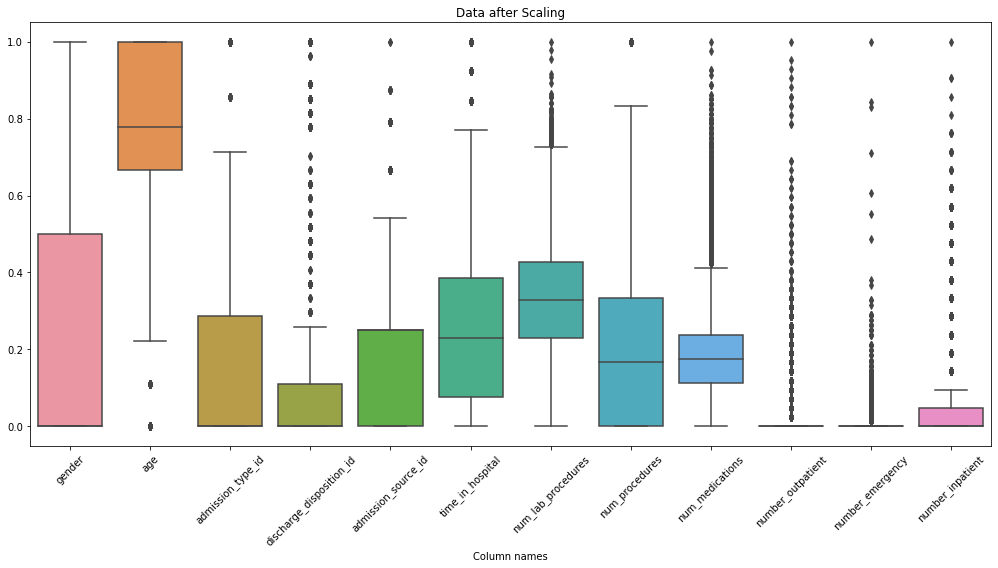

Scaling completed         gender       age  admission_type_id  discharge_disposition_id  \
0          0.0  0.000000           0.714286                  0.888889   
1          0.0  0.111111           0.000000                  0.000000   
2          0.0  0.222222           0.000000                  0.000000   
3          0.5  0.444444           0.000000                  0.000000   
4          0.5  0.555556           0.000000                  0.000000   
...        ...       ...                ...                       ...   
101761     0.5  1.000000           0.000000                  0.074074   
101762     0.0  0.666667           0.000000                  0.111111   
101763     0.5  1.000000           0.000000                  0.000000   
101764     0.0  0.666667           0.142857                  0.074074   
101765     0.5  1.000000           0.000000                  0.000000   

        admission_source_id  time_in_hospital  num_lab_procedures  \
0                  0.000000         

[6.88393859e-02 6.60671205e-02 4.49158359e-02 4.04413521e-02
 3.30005871e-02 3.05369245e-02 2.98036712e-02 2.85304296e-02
 2.67242430e-02 2.44062261e-02 2.26641854e-02 2.15142160e-02
 1.87425784e-02 1.68121664e-02 1.60385842e-02 1.56415901e-02
 1.54546648e-02 1.53216176e-02 1.46176865e-02 1.37869950e-02
 1.33921026e-02 1.27863268e-02 1.25796326e-02 1.23424237e-02
 1.18482501e-02 1.11071107e-02 1.10367677e-02 1.05808925e-02
 1.02798882e-02 1.00990689e-02 9.66090837e-03 9.39628381e-03
 9.31694066e-03 9.09006057e-03 8.85583351e-03 8.67760619e-03
 8.51628891e-03 8.24421181e-03 8.18031498e-03 7.84543352e-03
 7.24372703e-03 6.82609738e-03 6.62990407e-03 6.53317932e-03
 6.46692186e-03 6.31449347e-03 6.13188850e-03 6.03927013e-03
 5.62114637e-03 5.55090603e-03 5.19608692e-03 5.14366973e-03
 5.02655385e-03 4.90634567e-03 4.64527303e-03 4.56828721e-03
 4.49185759e-03 4.32534129e-03 4.13333274e-03 3.83253670e-03
 3.71510681e-03 3.65571732e-03 3.54876590e-03 3.45986420e-03
 3.38292866e-03 3.340921

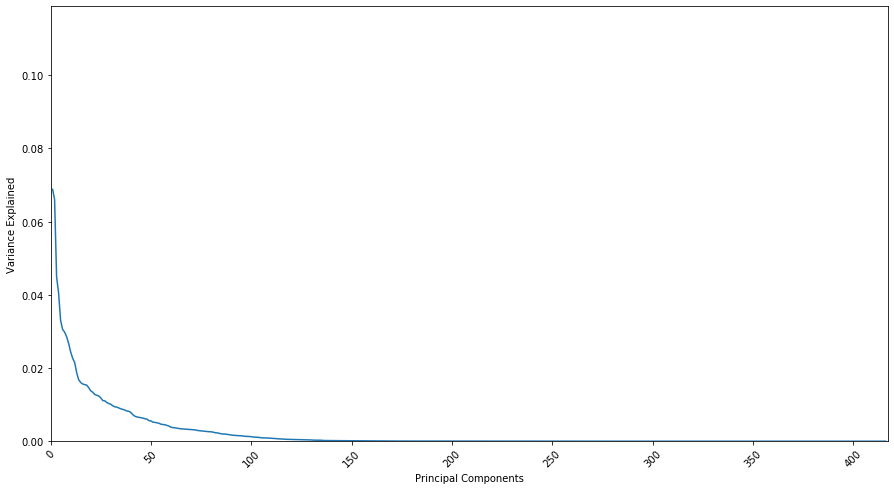

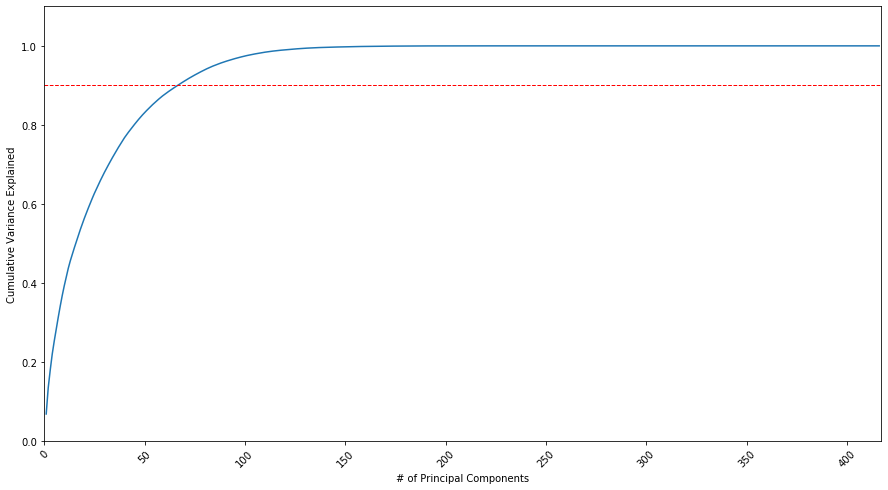

Rerun PCA with reduced number of components
Graph 2,3,4


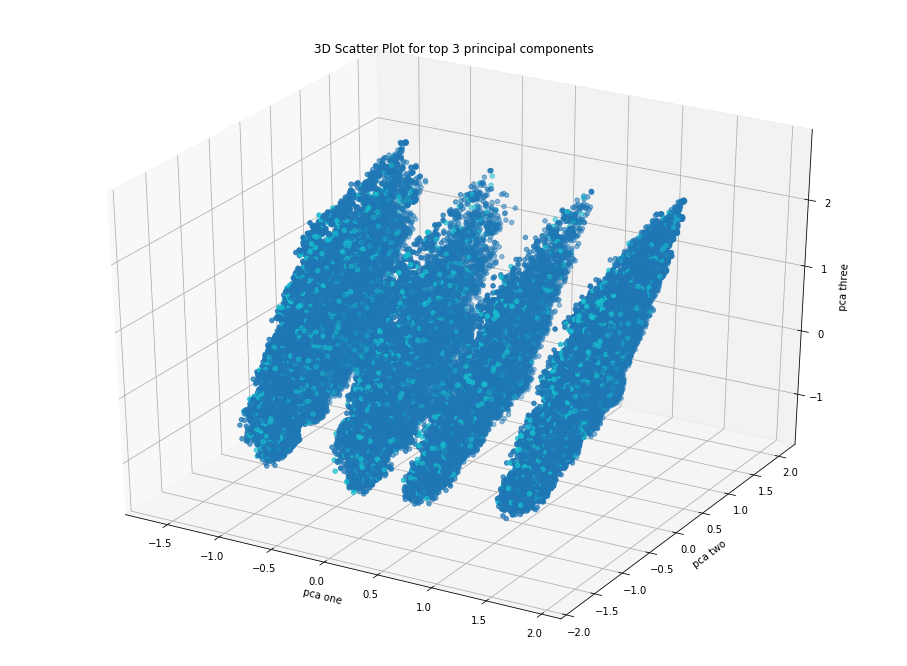

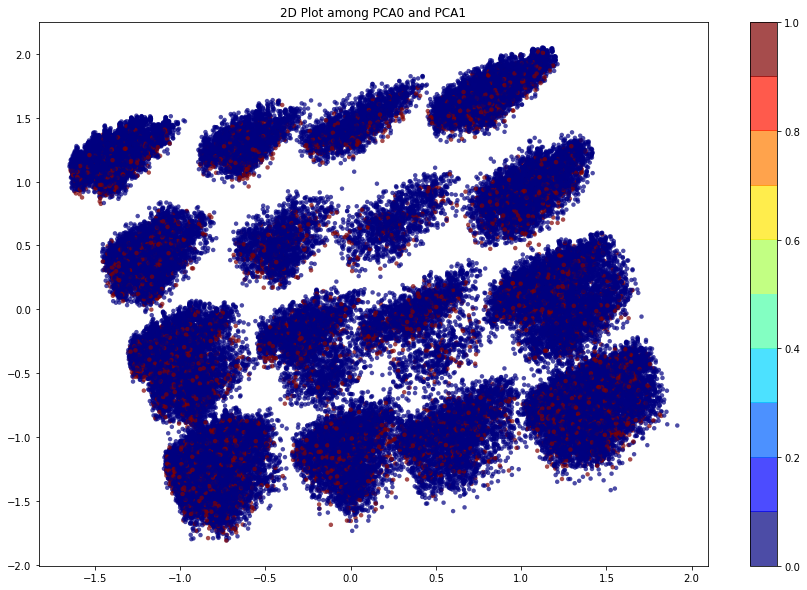

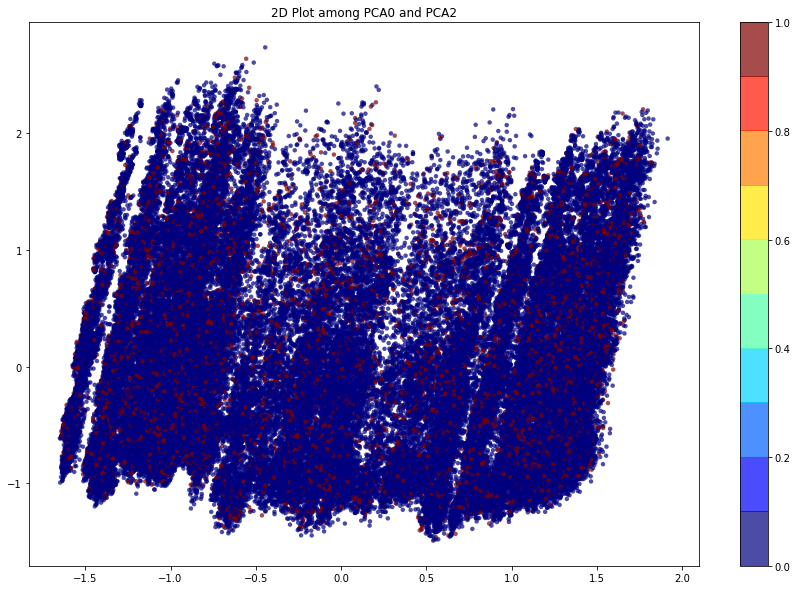

In [5]:
main(True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


List of numeric columns are  ['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Replacing any trailing spaces with NaN for all columns

Printing the head of the data: 
    encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                 

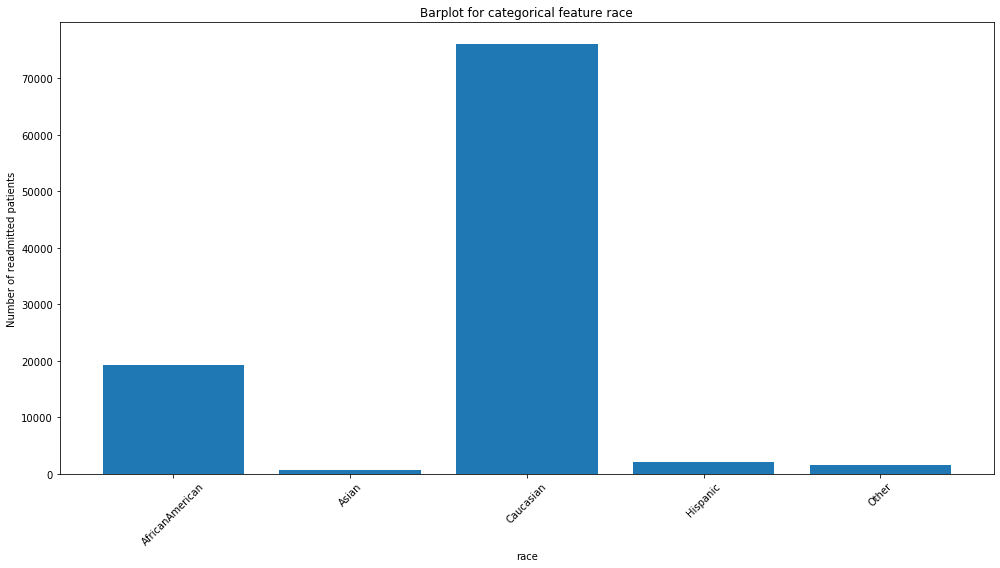

gender  has data type  object  has  3  unique values


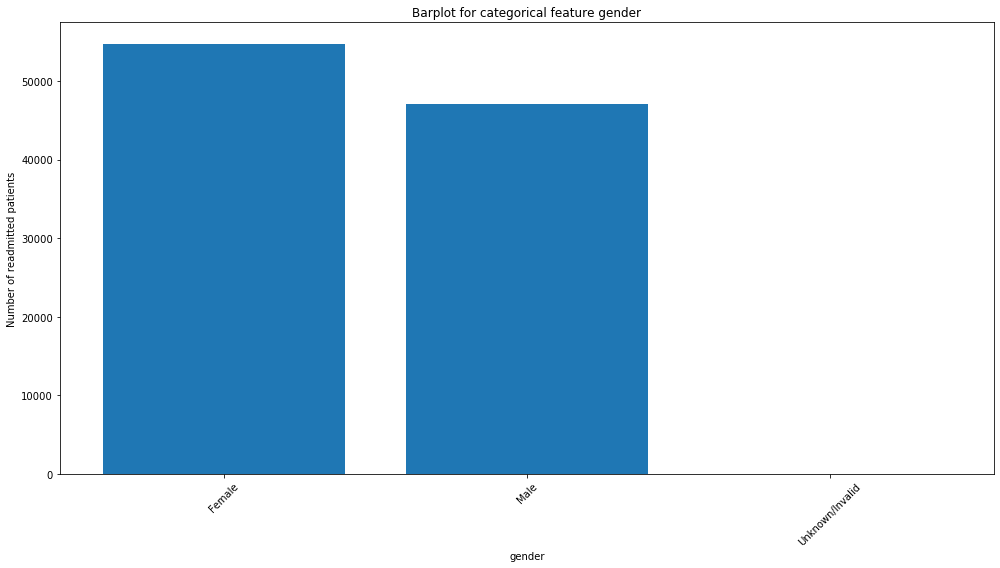

age  has data type  object  has  10  unique values


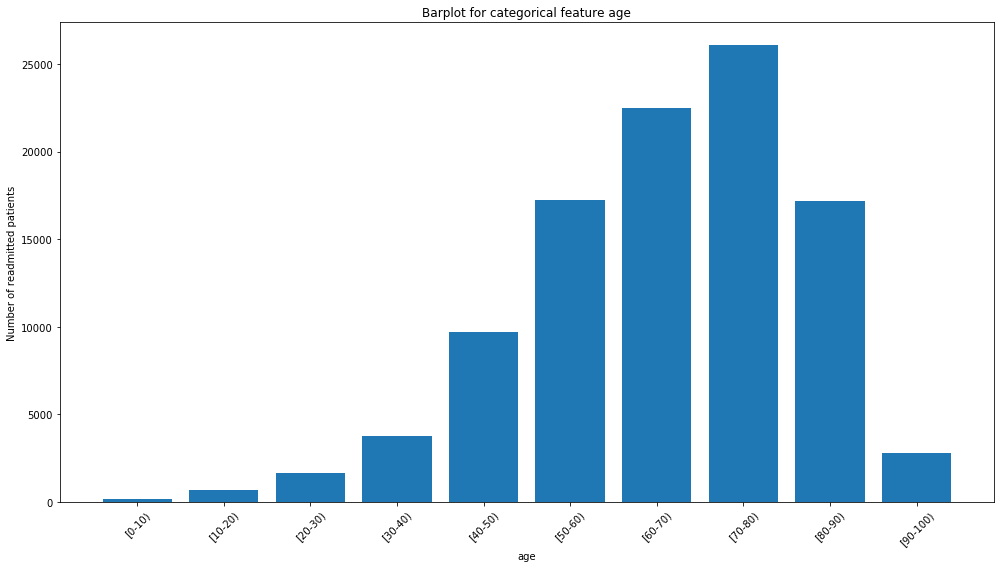

weight  has data type  object  has  10  unique values


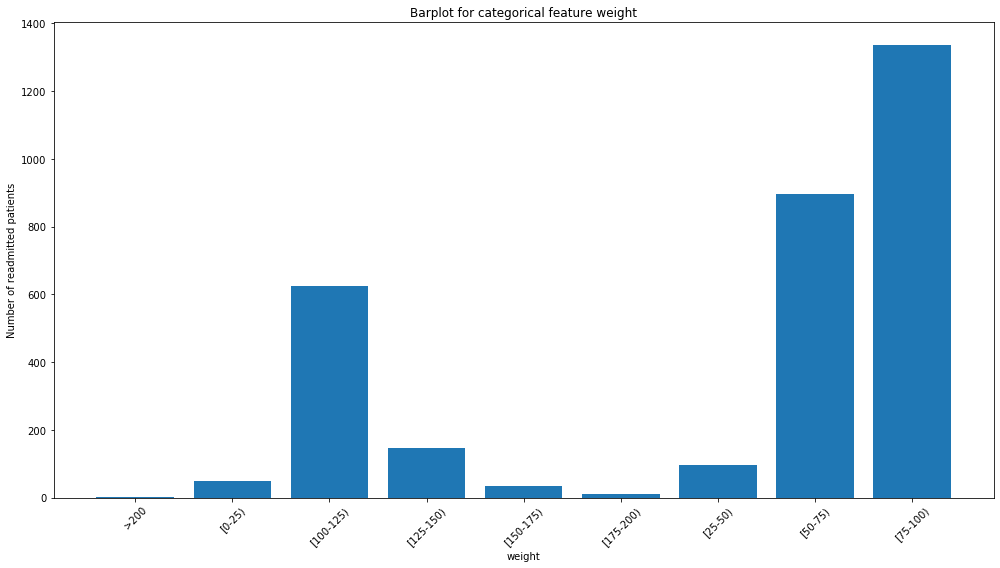

payer_code  has data type  object  has  18  unique values


medical_specialty  has data type  object  has  73  unique values


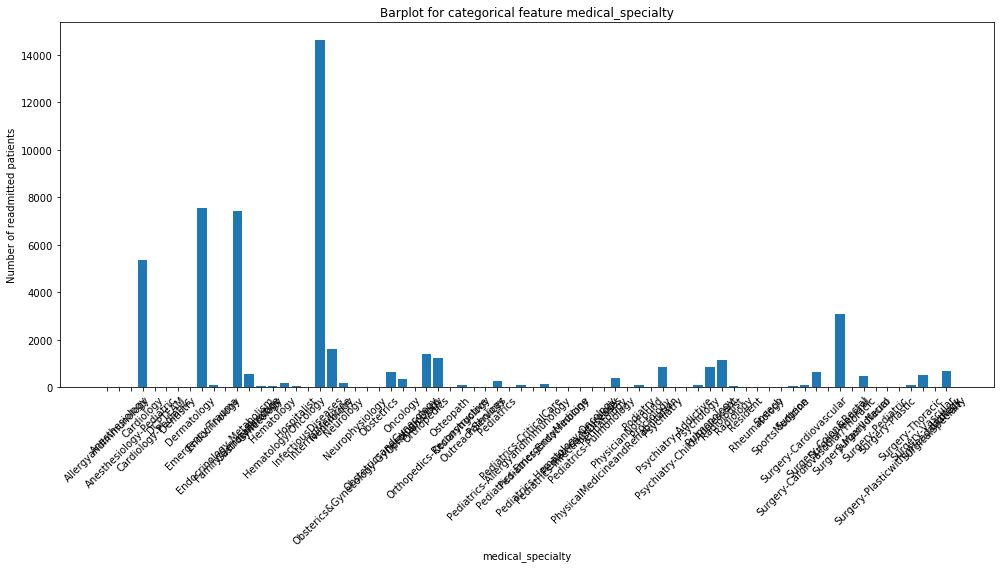

diag_1  has data type  object  has  20  unique values


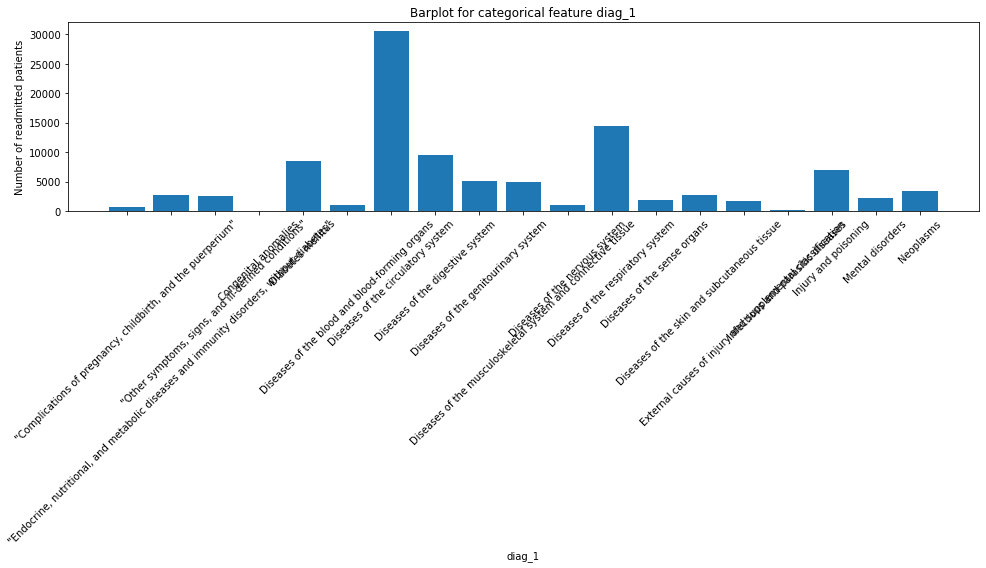

diag_2  has data type  object  has  20  unique values


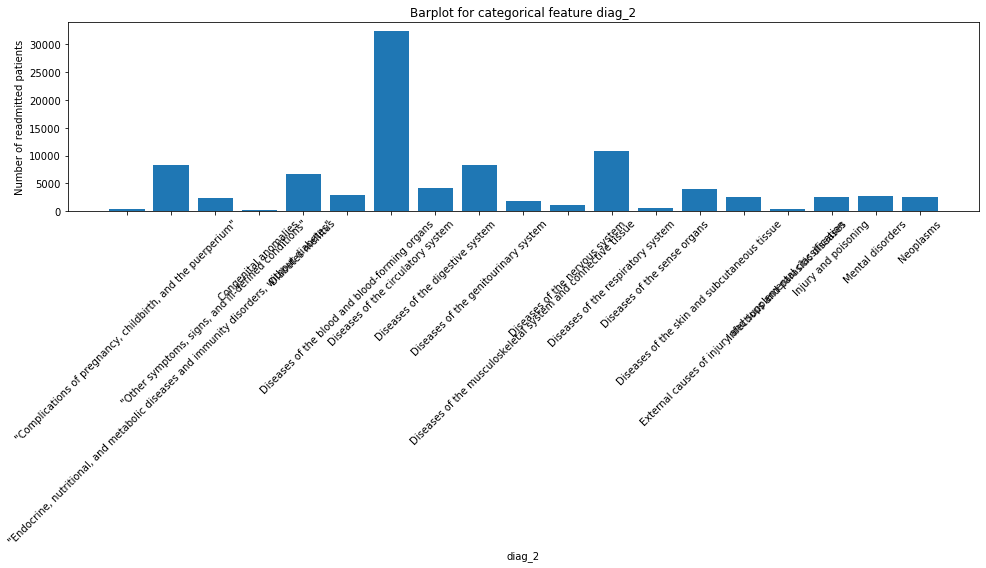

diag_3  has data type  object  has  20  unique values


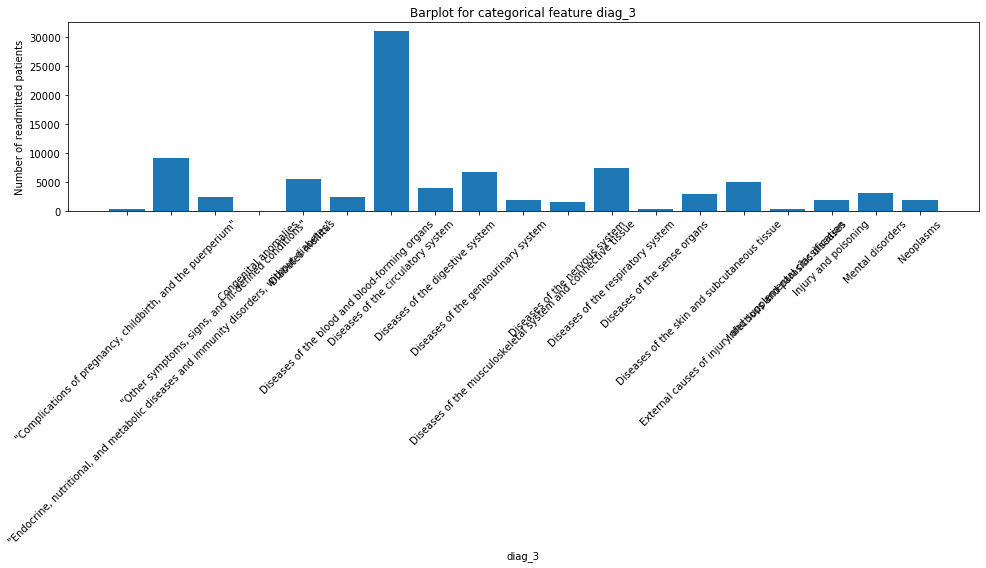

max_glu_serum  has data type  object  has  4  unique values


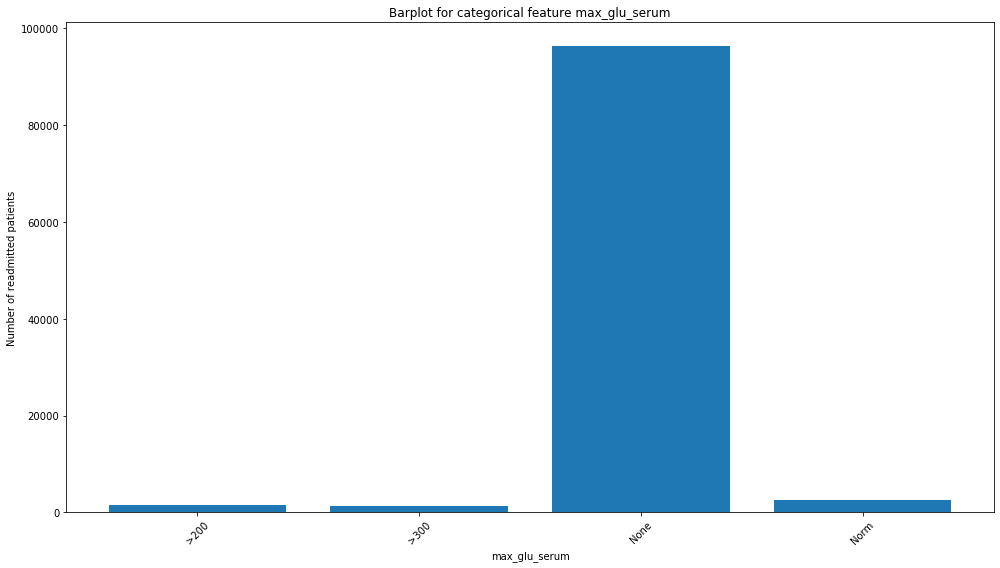

A1Cresult  has data type  object  has  4  unique values


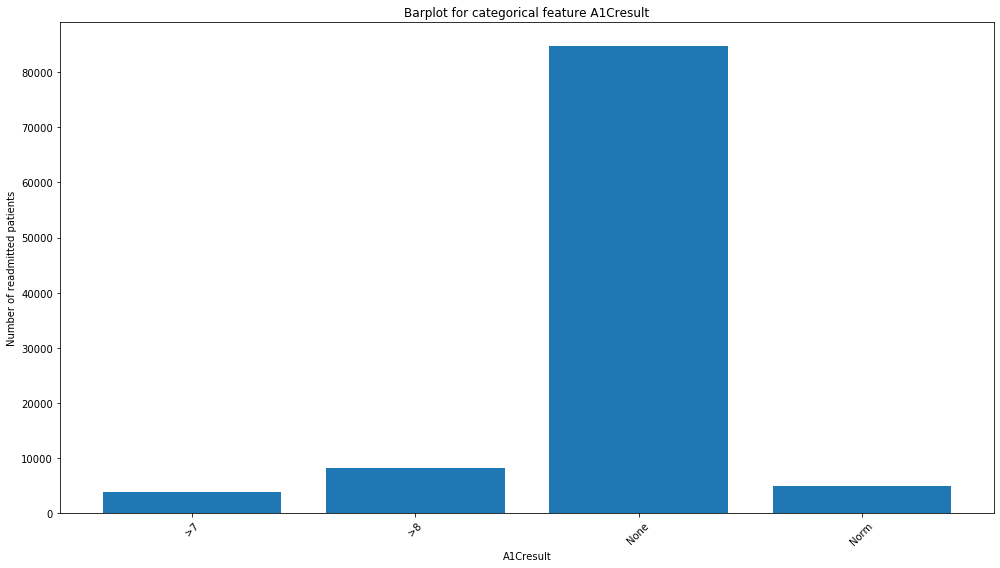

metformin  has data type  object  has  4  unique values


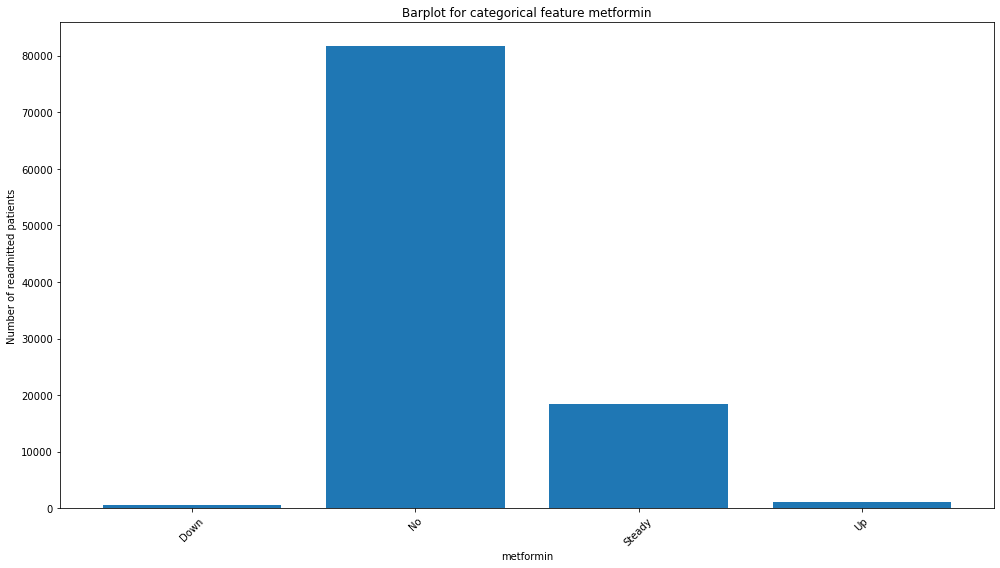

repaglinide  has data type  object  has  4  unique values


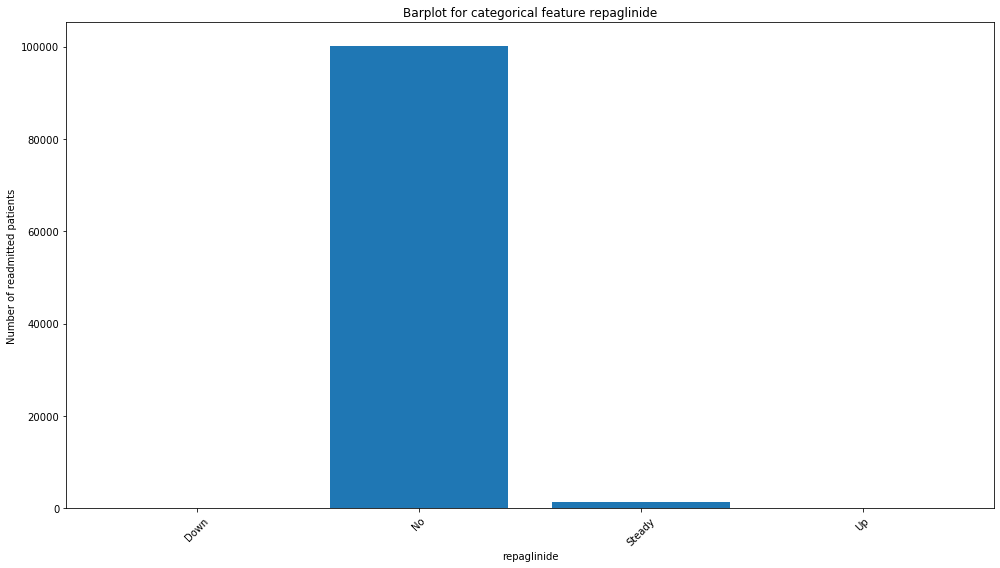

nateglinide  has data type  object  has  4  unique values


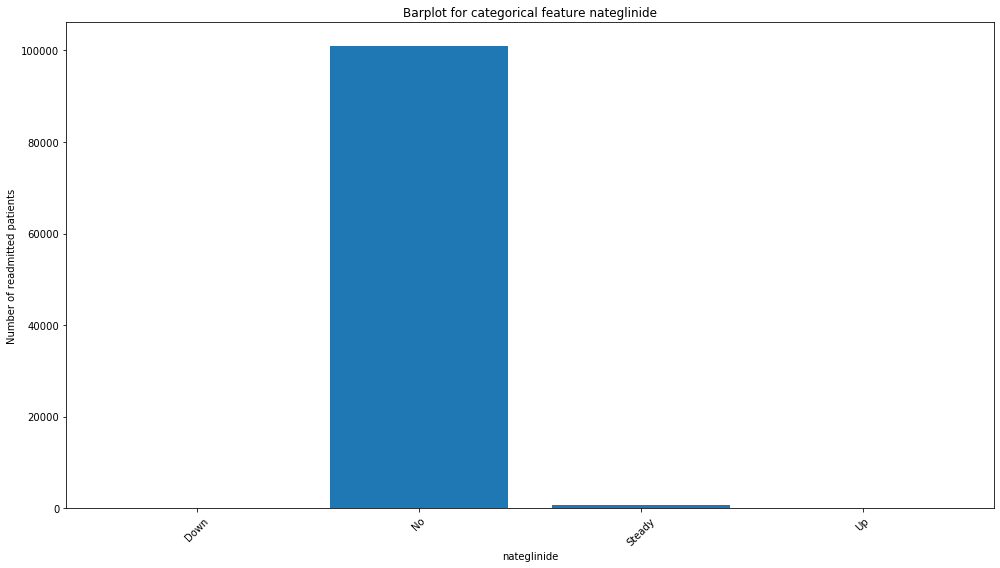

chlorpropamide  has data type  object  has  4  unique values


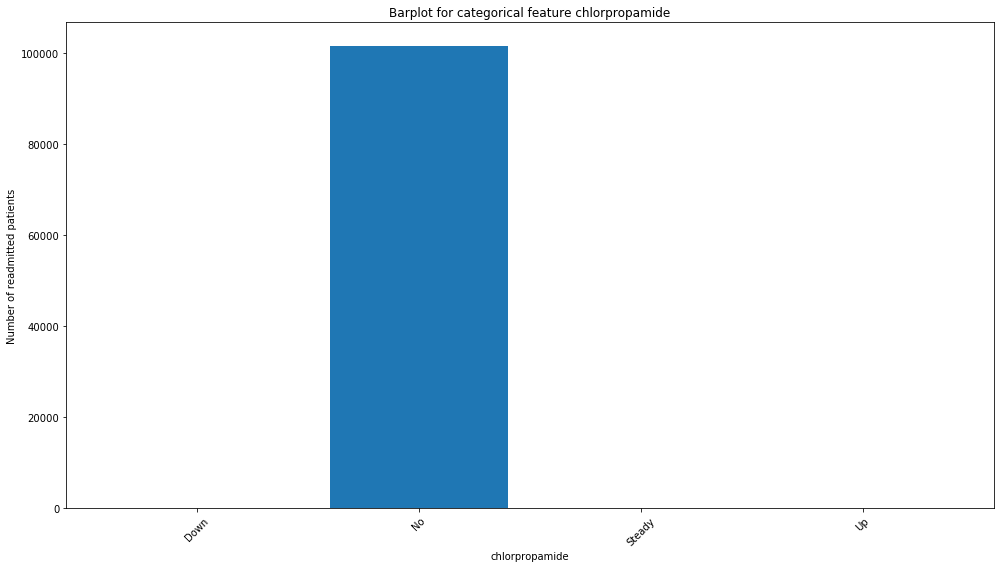

glimepiride  has data type  object  has  4  unique values


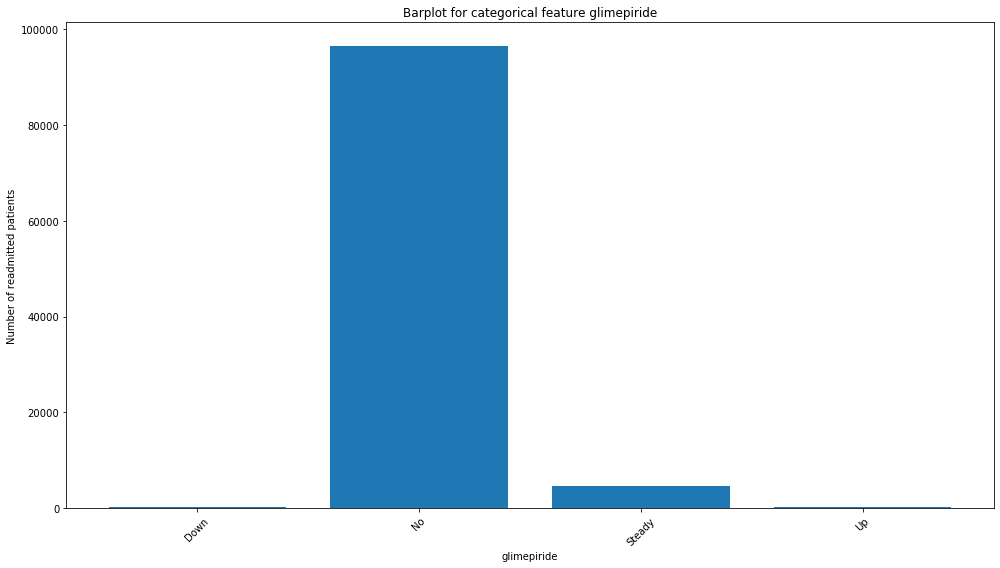

acetohexamide  has data type  object  has  2  unique values


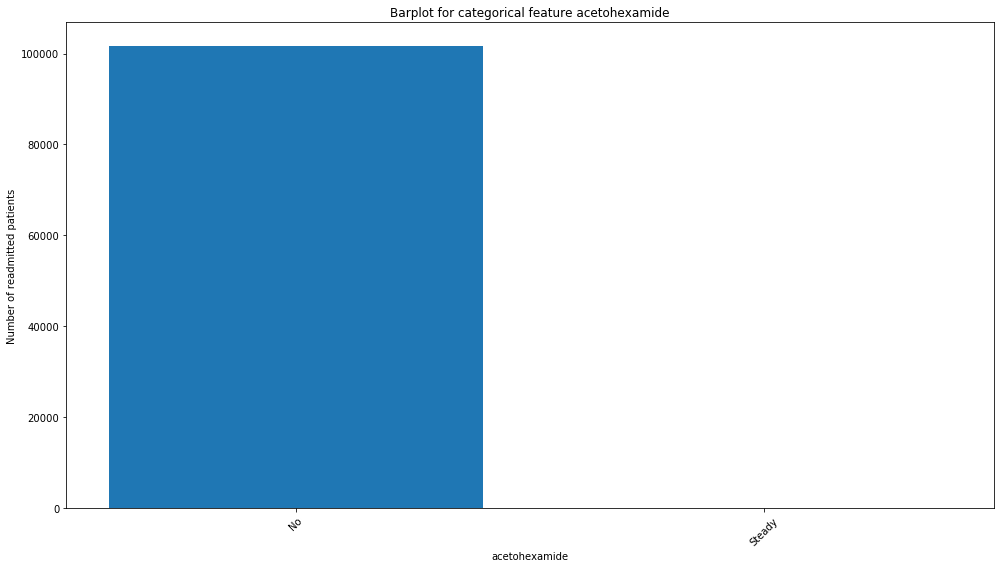

glipizide  has data type  object  has  4  unique values


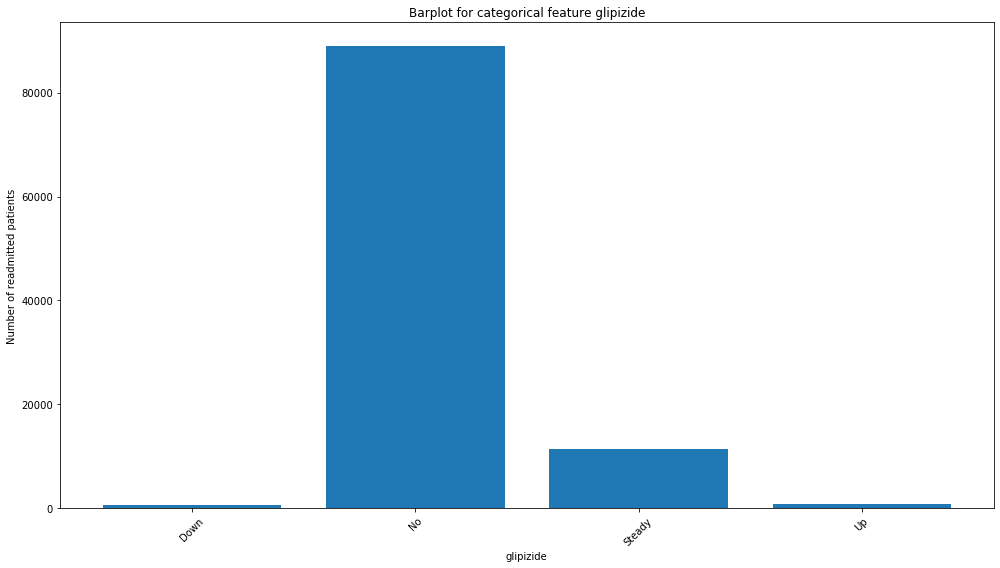

glyburide  has data type  object  has  4  unique values


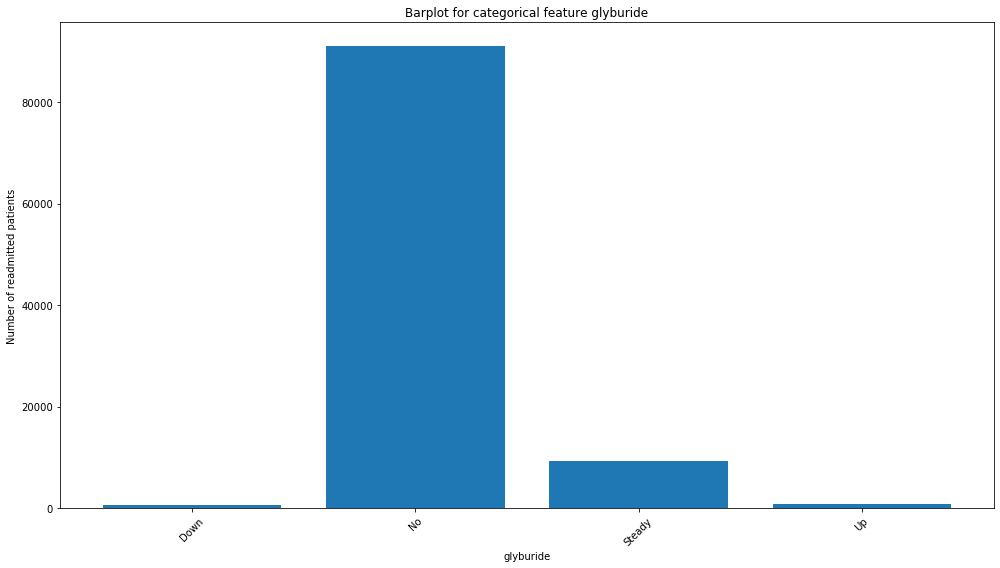

tolbutamide  has data type  object  has  2  unique values


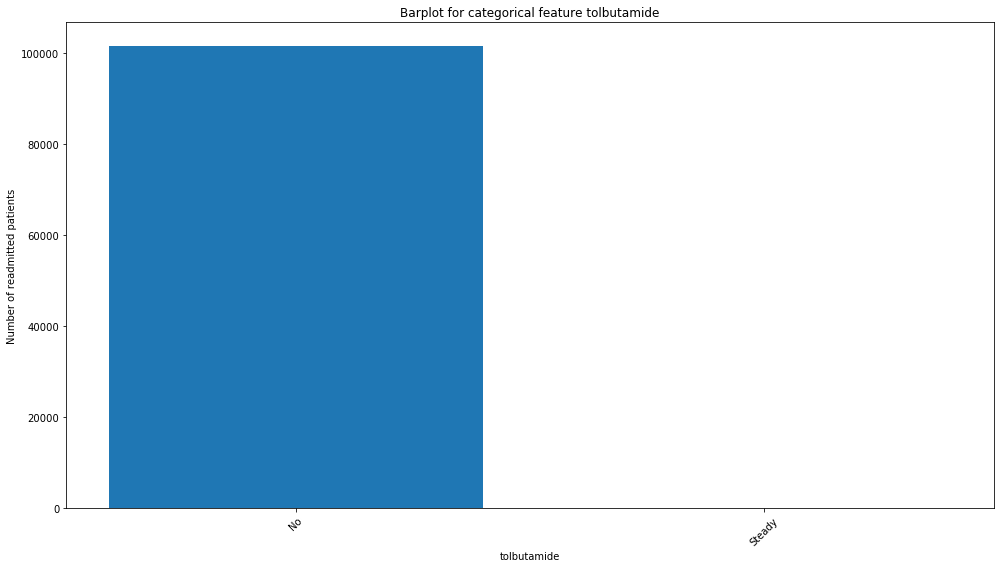

pioglitazone  has data type  object  has  4  unique values


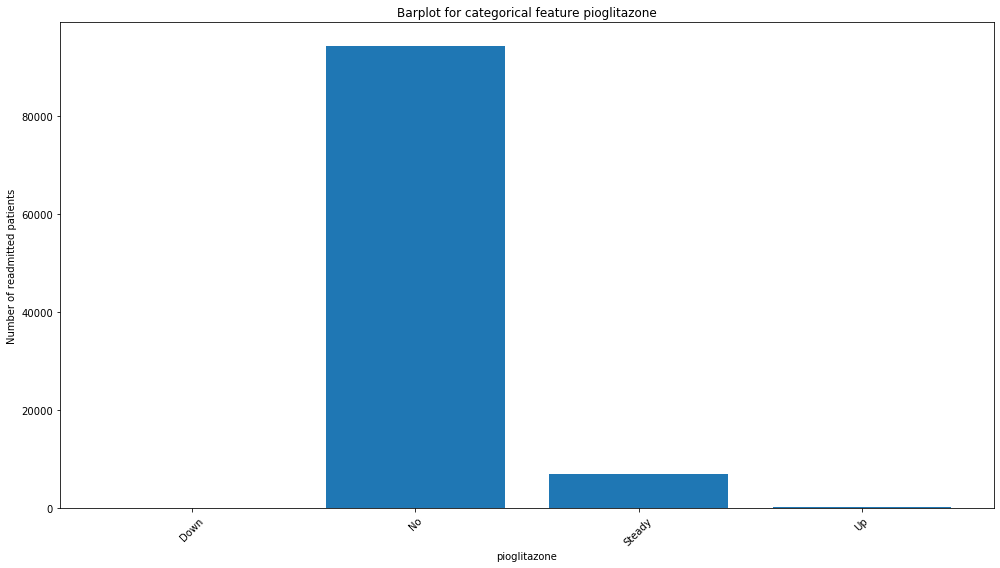

rosiglitazone  has data type  object  has  4  unique values


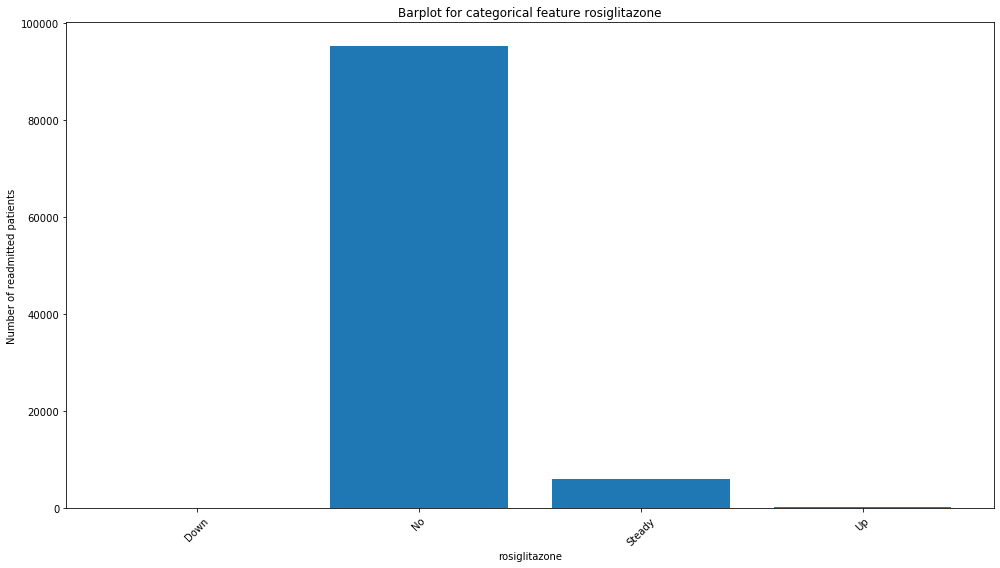

acarbose  has data type  object  has  4  unique values


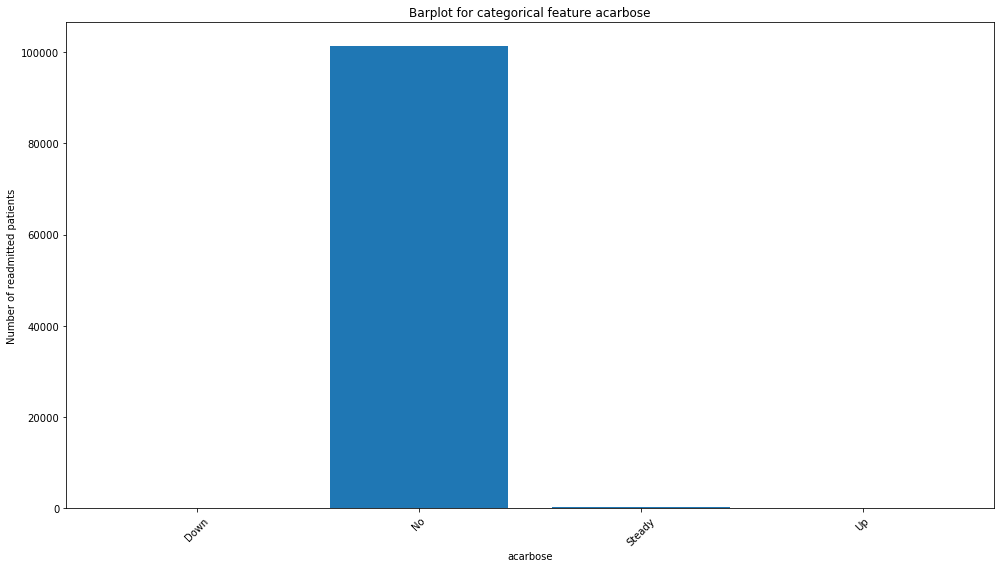

miglitol  has data type  object  has  4  unique values


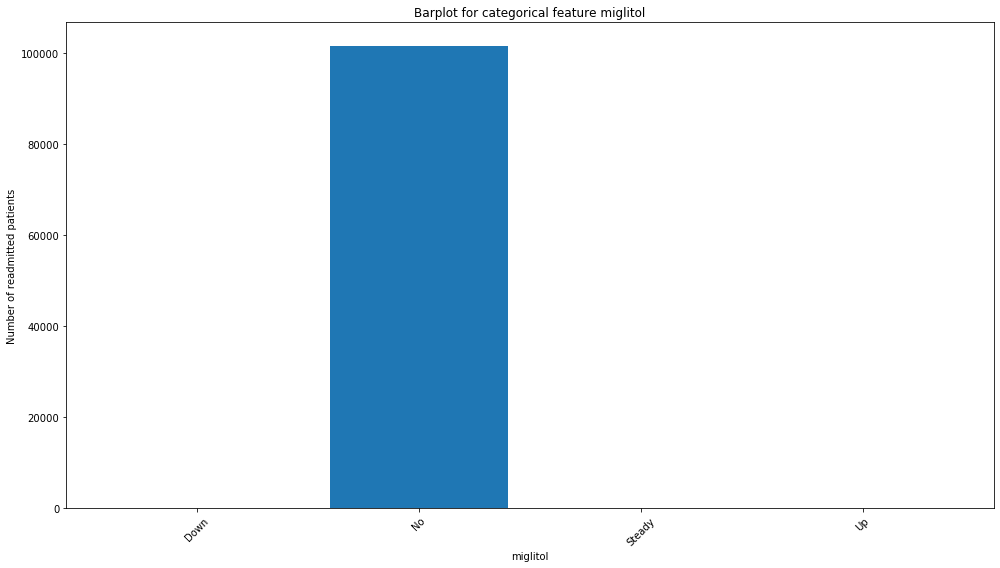

troglitazone  has data type  object  has  2  unique values


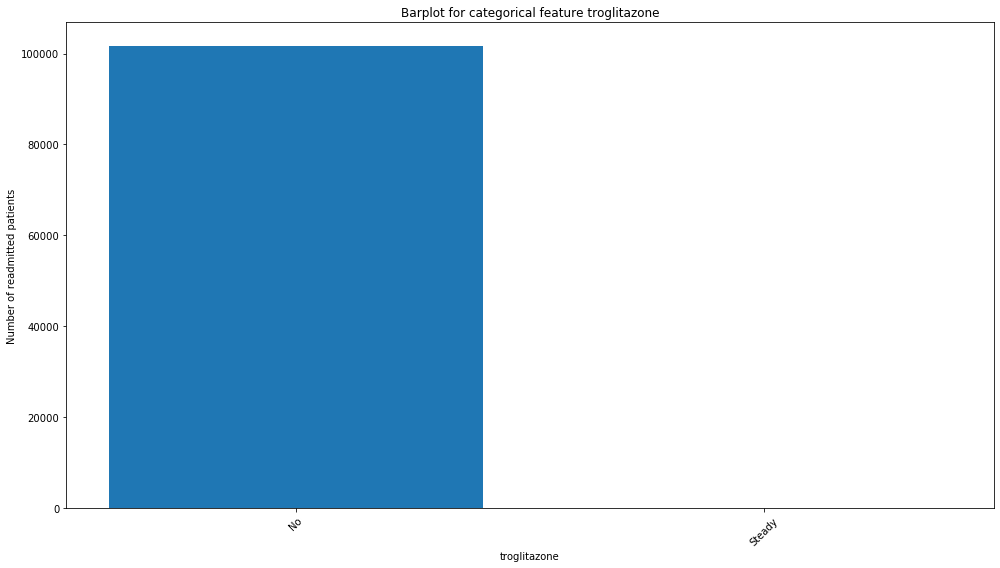

tolazamide  has data type  object  has  3  unique values


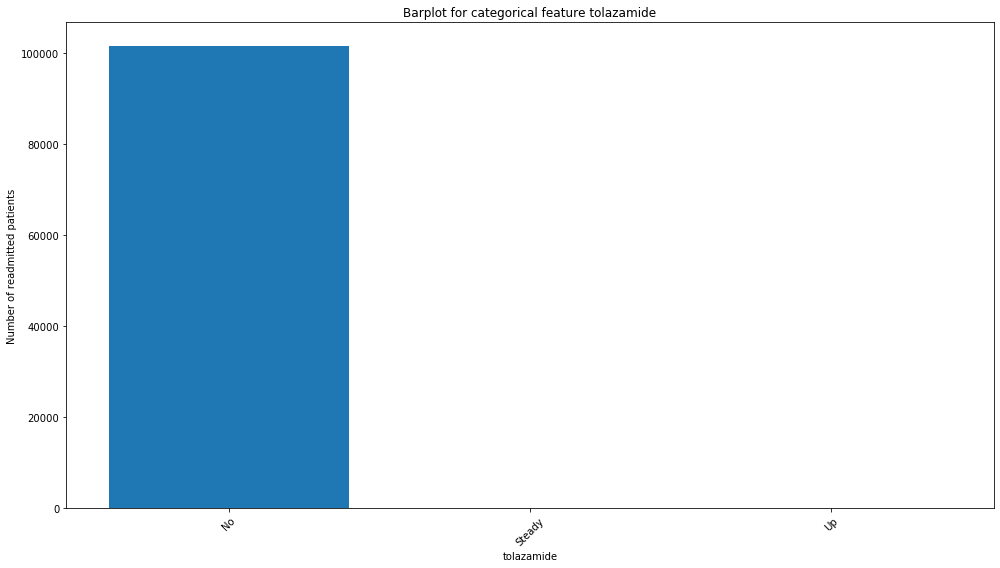

examide  has data type  object  has  1  unique values


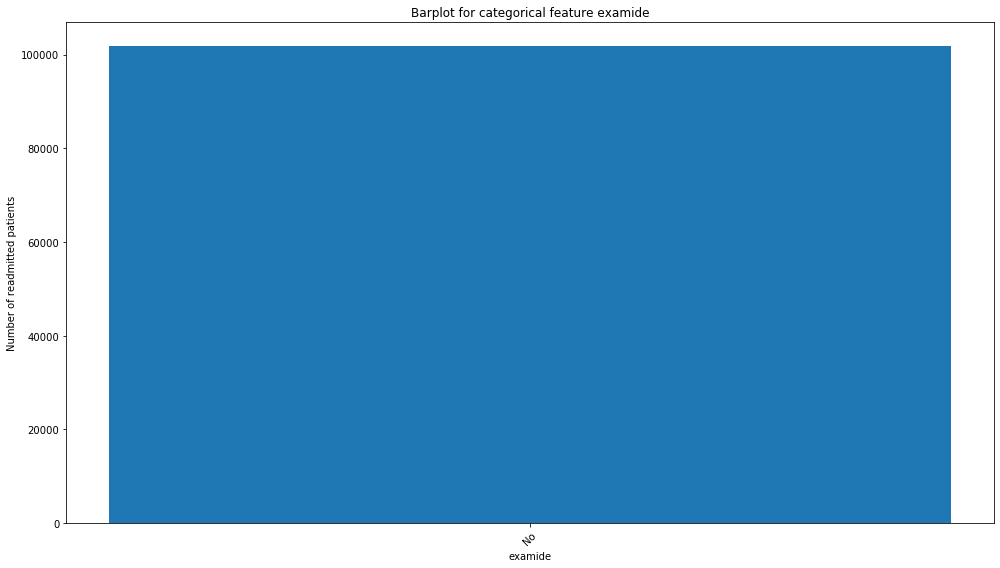

citoglipton  has data type  object  has  1  unique values


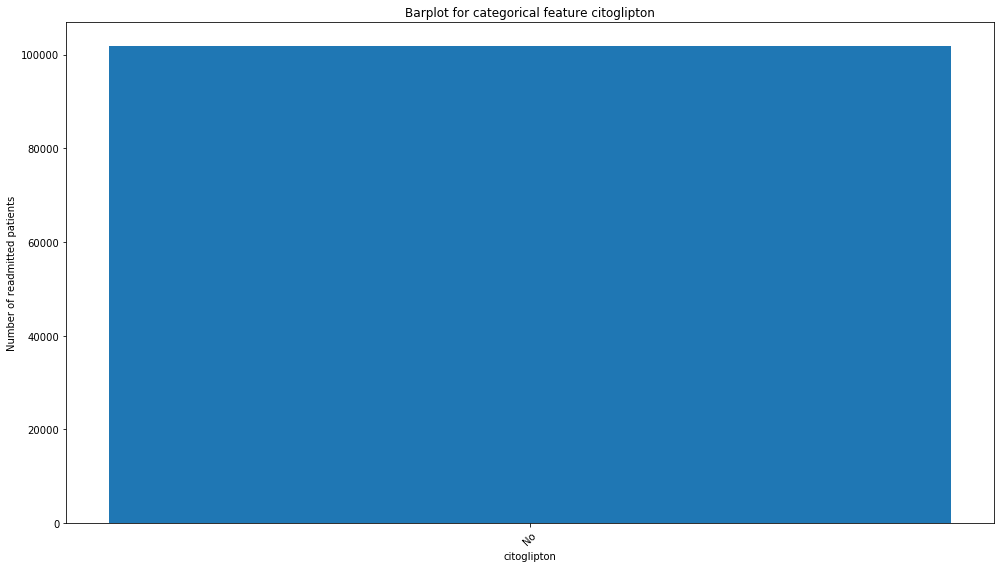

insulin  has data type  object  has  4  unique values


glyburide-metformin  has data type  object  has  4  unique values


glipizide-metformin  has data type  object  has  2  unique values


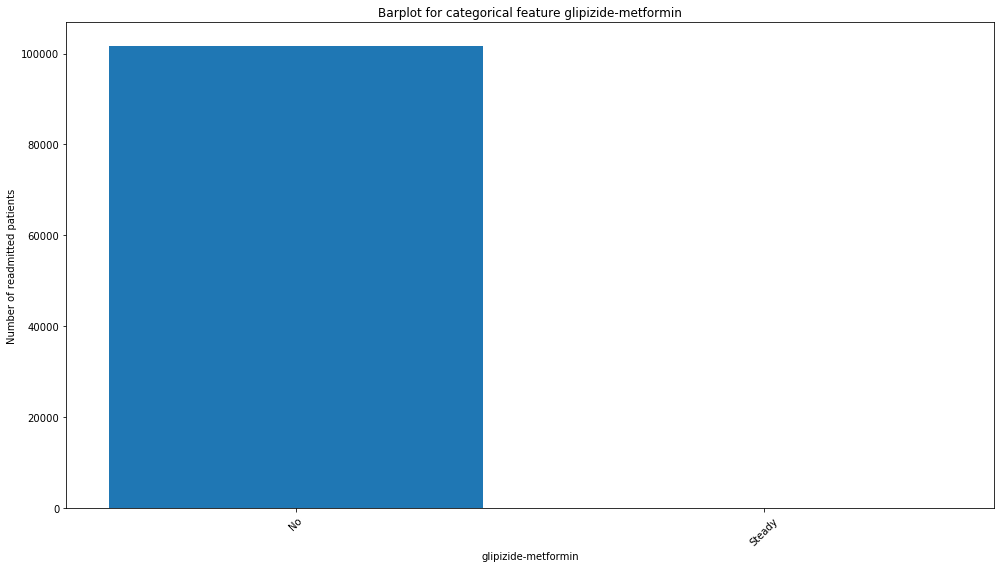

glimepiride-pioglitazone  has data type  object  has  2  unique values


metformin-rosiglitazone  has data type  object  has  2  unique values


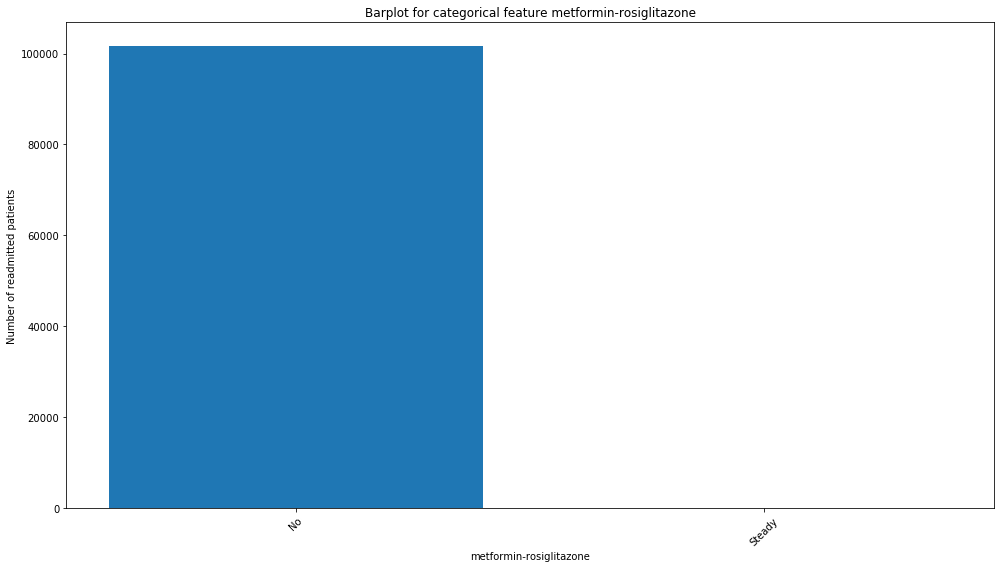

metformin-pioglitazone  has data type  object  has  2  unique values


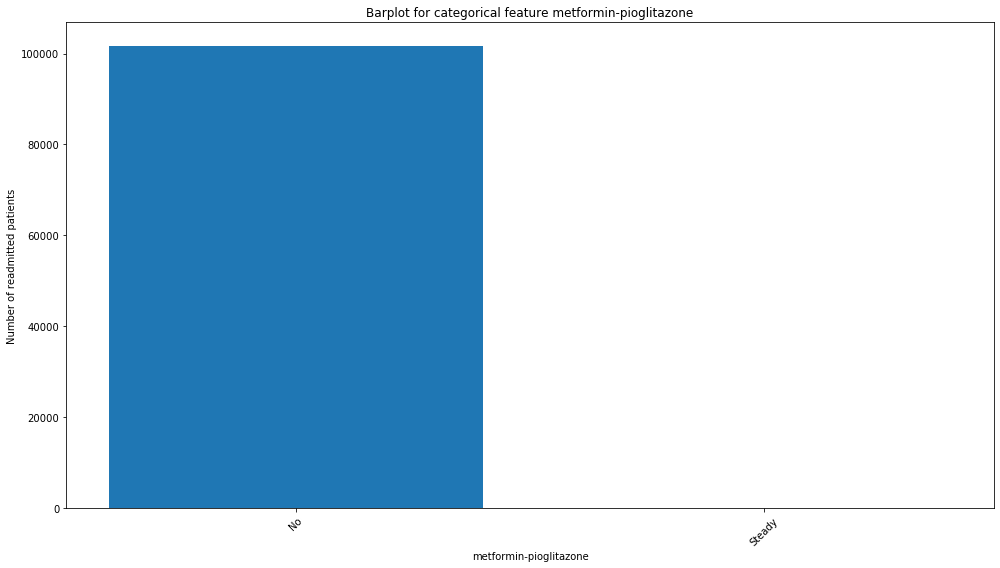

change  has data type  object  has  2  unique values


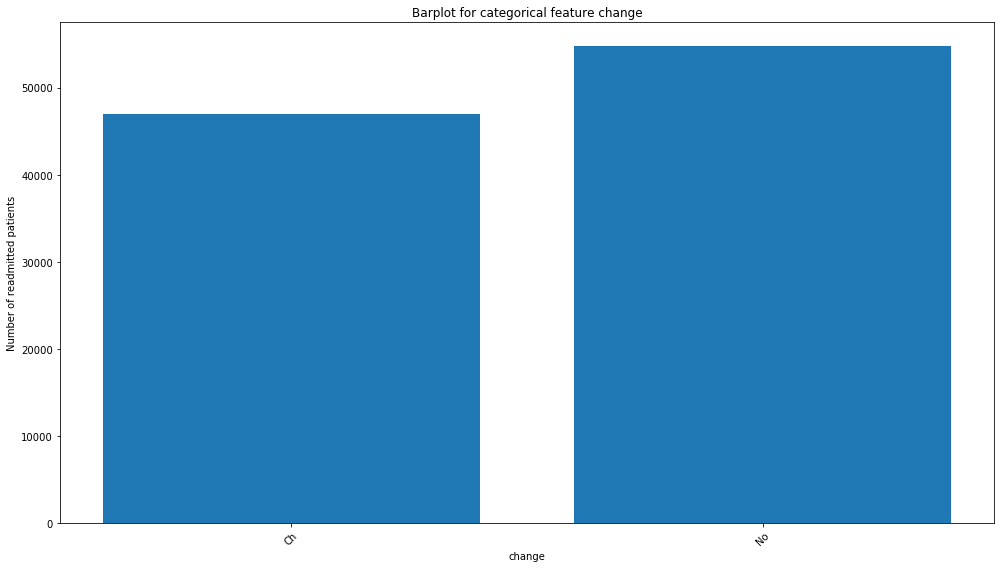

diabetesMed  has data type  object  has  2  unique values


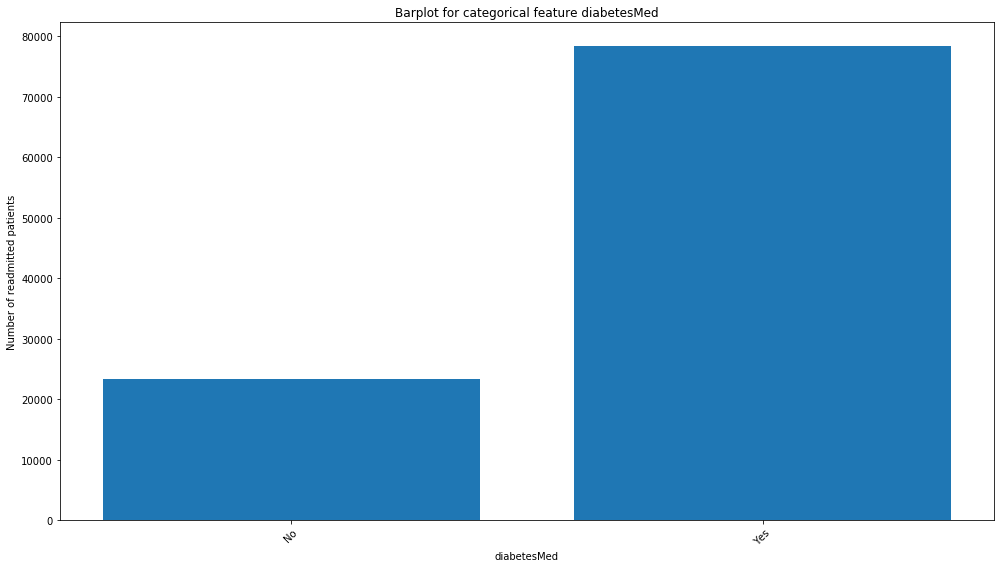

readmitted  has data type  object  has  3  unique values


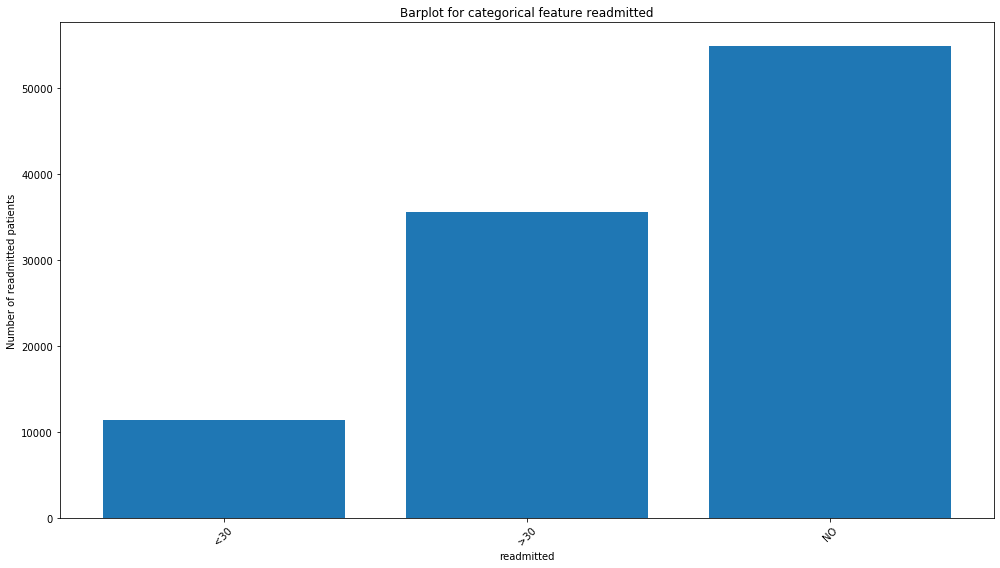

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

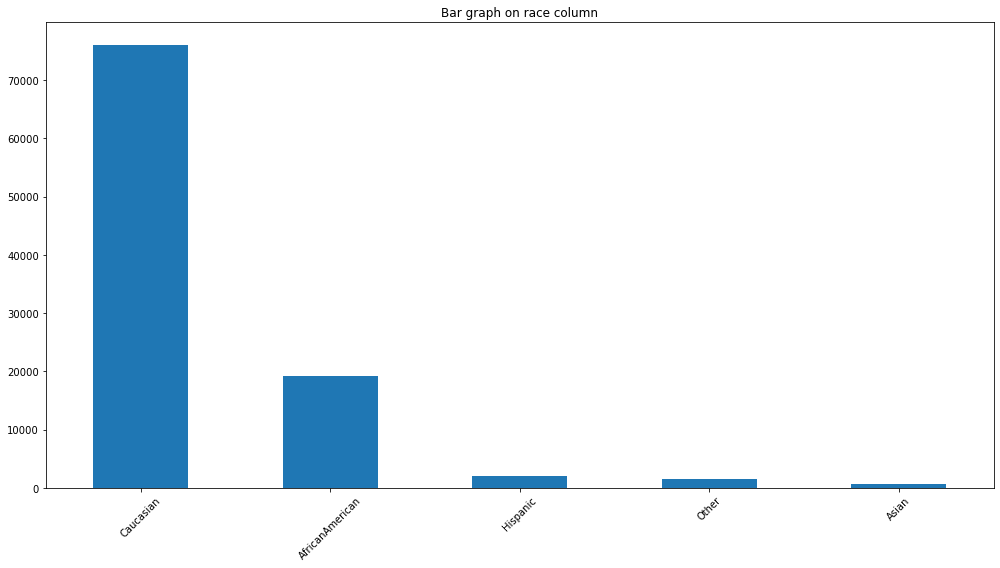

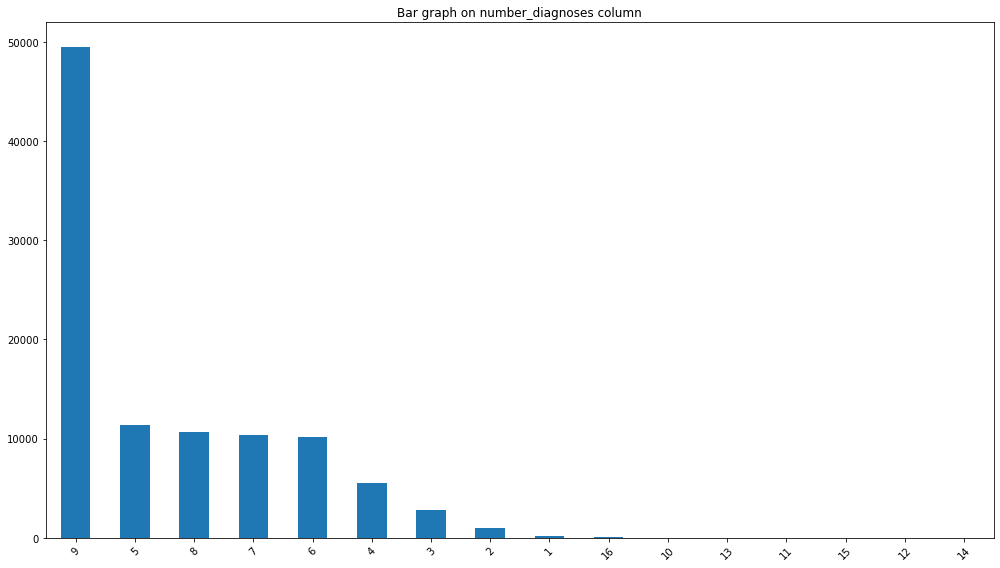

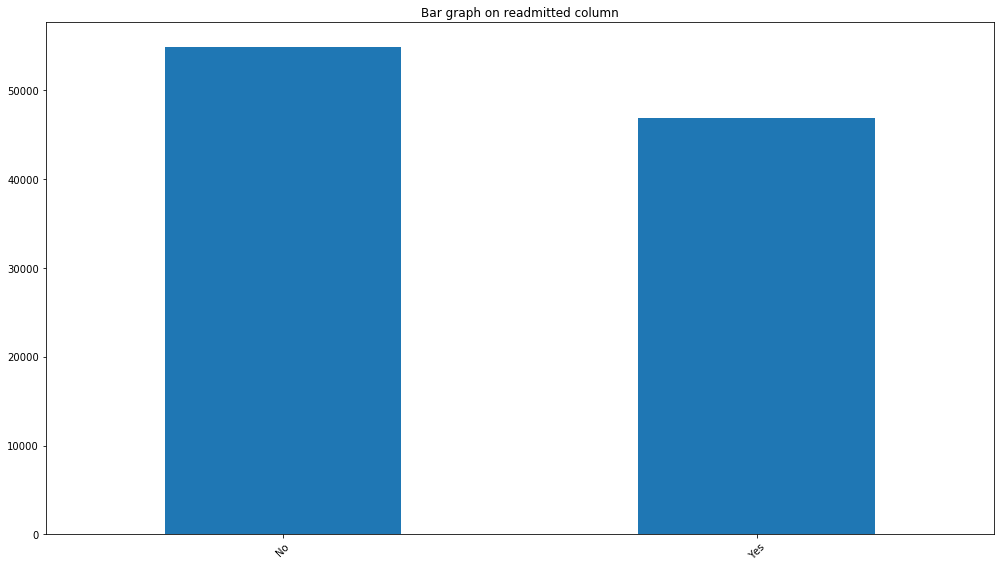


So the columns which have missing values are: 
race 2273
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 1464
diag_2 7028
diag_3 13565


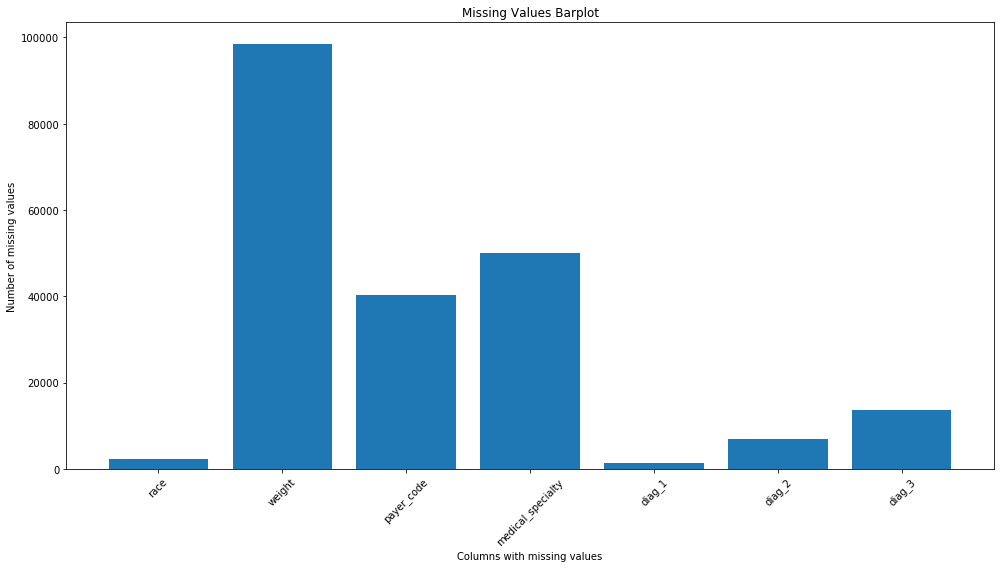


Dataset size is  101766
Percentage of missing values in data :
 encounter_id                 0.00
patient_nbr                  0.00
race                         2.23
gender                       0.00
age                          0.00
weight                      96.86
admission_type_id            0.00
discharge_disposition_id     0.00
admission_source_id          0.00
time_in_hospital             0.00
payer_code                  39.56
medical_specialty           49.08
num_lab_procedures           0.00
num_procedures               0.00
num_medications              0.00
number_outpatient            0.00
number_emergency             0.00
number_inpatient             0.00
diag_1                       1.44
diag_2                       6.91
diag_3                      13.33
number_diagnoses             0.00
max_glu_serum                0.00
A1Cresult                    0.00
metformin                    0.00
repaglinide                  0.00
nateglinide                  0.00
chlorpropamide   

<ggplot: (171706096539)>


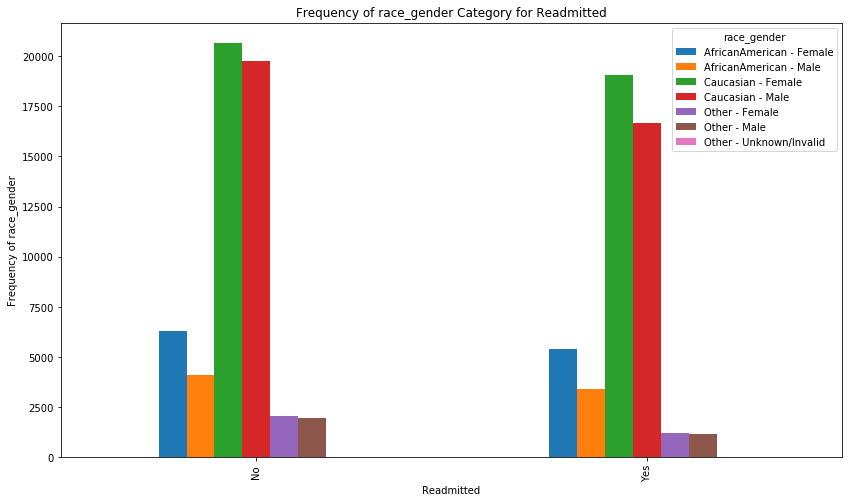

                                      admission_type_id  \
age_gender                readmitted                      
[0-10) - Female           No                   1.869565   
                          Yes                  1.857143   
[0-10) - Male             No                   1.634921   
                          Yes                  2.200000   
[10-20) - Female          No                   1.800866   
                          Yes                  1.801170   
[10-20) - Male            No                   1.663265   
                          Yes                  1.806452   
[20-30) - Female          No                   2.169205   
                          Yes                  1.967495   
[20-30) - Male            No                   1.553125   
                          Yes                  1.632287   
[30-40) - Female          No                   2.175962   
                          Yes                  1.953881   
[30-40) - Male            No                   1.936027 

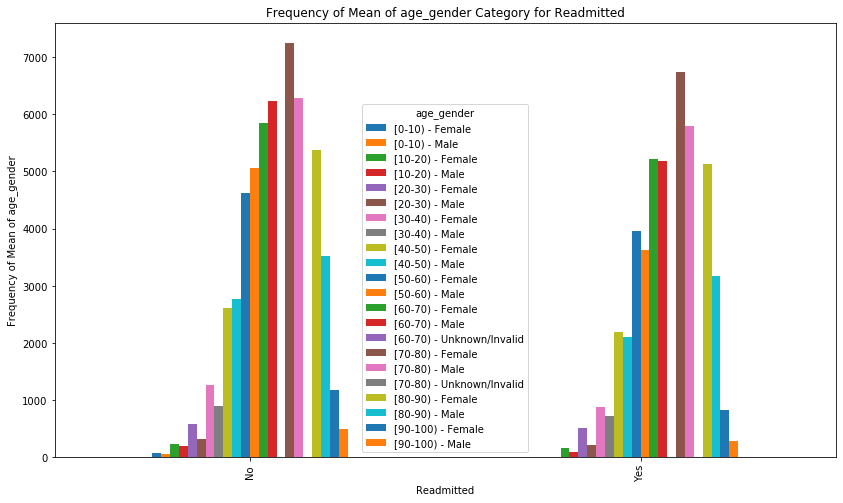

                                     admission_type_id  \
race_gender              readmitted                      
AfricanAmerican - Female No                   1.728897   
                         Yes                  1.666605   
AfricanAmerican - Male   No                   1.745299   
                         Yes                  1.744317   
Caucasian - Female       No                   2.091178   
                         Yes                  2.072449   
Caucasian - Male         No                   2.116452   
                         Yes                  2.095392   
Other - Female           No                   2.094157   
                         Yes                  2.246721   
Other - Male             No                   2.030715   
                         Yes                  2.136788   
Other - Unknown/Invalid  No                   1.666667   

                                     discharge_disposition_id  \
race_gender              readmitted                             

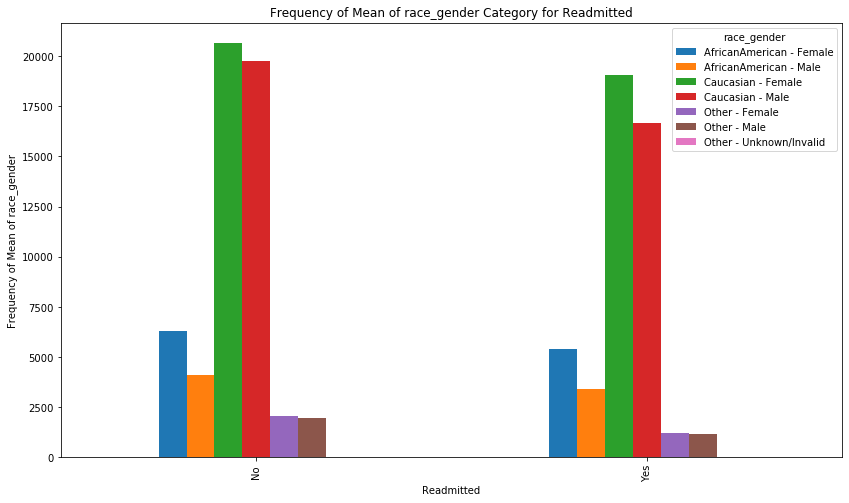

List of numeric columns are  ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'no_of_revisits']

For column  time_in_hospital  Min value is  1  Max value is  14
Column created by Binning: 
 0          (0.9, 5.3]
1          (0.9, 5.3]
2          (0.9, 5.3]
3          (0.9, 5.3]
4          (0.9, 5.3]
             ...     
101761     (0.9, 5.3]
101762     (0.9, 5.3]
101763     (0.9, 5.3]
101764    (9.7, 14.0]
101765     (5.3, 9.7]
Name: time_in_hospitalBin, Length: 101766, dtype: category
Categories (3, interval[float64]): [(0.9, 5.3] < (5.3, 9.7] < (9.7, 14.0]]

For column  num_lab_procedures  Min value is  1  Max value is  132
Column created by Binning: 
 0          (0.9, 44.7]
1         (44.7, 88.3]
2          (0.9, 44.7]
3          (0.9, 44.7]
4         (44.7, 88.3]
              ...     
101761    (44.7, 88.3]
101762     (0.9, 44.7]
101763    (44.7, 88.3]
101764    (44.7, 8

[60-70)   is  9
[50-60)   is  8
[80-90)   is  7
[40-50)   is  6
[30-40)   is  5
[90-100)   is  4
[20-30)   is  3
[10-20)   is  2
[0-10)   is  1
admission_type_id  has data type  int64  has  8  unique values
discharge_disposition_id  has data type  int64  has  26  unique values
admission_source_id  has data type  int64  has  17  unique values
time_in_hospital  has data type  int64  has  14  unique values
medical_specialty  has data type  object  has  73  unique values
num_lab_procedures  has data type  int64  has  118  unique values
num_procedures  has data type  int64  has  7  unique values
num_medications  has data type  int64  has  75  unique values
number_outpatient  has data type  int64  has  39  unique values
number_emergency  has data type  int64  has  33  unique values
number_inpatient  has data type  int64  has  21  unique values
diag_1  has data type  object  has  20  unique values
diag_2  has data type  object  has  20  unique values
diag_3  has data type  object  has  20  un

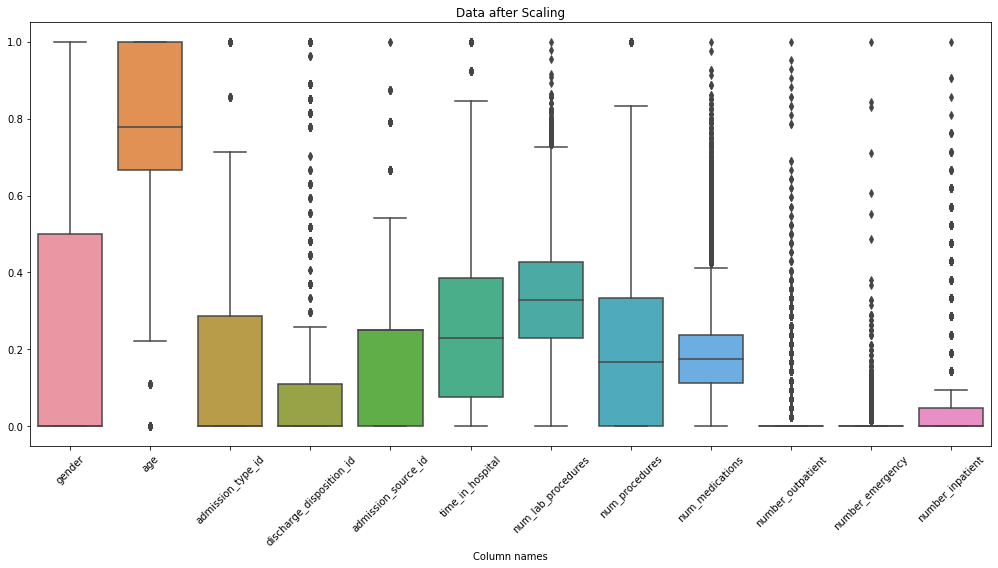

New data after Scaling is 
    gender       age  admission_type_id  discharge_disposition_id  \
0     0.0  0.000000           0.714286                  0.888889   
1     0.0  0.111111           0.000000                  0.000000   
2     0.0  0.222222           0.000000                  0.000000   
3     0.5  0.444444           0.000000                  0.000000   
4     0.5  0.555556           0.000000                  0.000000   

   admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0                 0.00          0.000000            0.305344        0.000000   
1                 0.25          0.153846            0.442748        0.000000   
2                 0.25          0.076923            0.076336        0.833333   
3                 0.25          0.076923            0.328244        0.166667   
4                 0.25          0.000000            0.381679        0.000000   

   num_medications  number_outpatient  ...  age_genderPct_4.727512135683824  \
0  

z_score value is  101766 416 
 [[0.92739675 3.86602933 2.75079957 ... 0.35554944 0.36702153 0.39914526]
 [0.92739675 3.31528336 0.70846069 ... 0.35554944 0.36702153 0.39914526]
 [0.92739675 2.76453739 0.70846069 ... 0.35554944 0.36702153 0.39914526]
 ...
 [1.07803147 1.09068441 0.70846069 ... 0.35554944 2.72463583 0.39914526]
 [0.92739675 0.56155351 0.01660864 ... 0.35554944 0.36702153 0.39914526]
 [1.07803147 1.09068441 0.70846069 ... 0.35554944 2.72463583 0.39914526]]
Entries which are outliers are  (array([     0,      0,      0, ..., 101765, 101765, 101765], dtype=int64), array([  1,   3,  12, ..., 344, 360, 379], dtype=int64))
Original shape of data is  (101766, 416)
Final shape of data without outliers(Z Score based) is  (2629, 416)
Hence from z score based outlier detection we got  99137  outliers

Z score based Outliers removed data is 
         gender       age  admission_type_id  discharge_disposition_id  \
7          0.5  1.000000           0.000000                  0.000000

        gender       age  admission_type_id  discharge_disposition_id  \
0          NaN  0.000000                NaN                  0.888889   
1          NaN  0.111111                NaN                       NaN   
2          NaN       NaN                NaN                       NaN   
3          NaN       NaN                NaN                       NaN   
4          NaN       NaN                NaN                       NaN   
...        ...       ...                ...                       ...   
101761     NaN       NaN                NaN                       NaN   
101762     NaN       NaN                NaN                       NaN   
101763     NaN       NaN                NaN                       NaN   
101764     NaN       NaN                NaN                       NaN   
101765     NaN       NaN                NaN                       NaN   

        admission_source_id  time_in_hospital  num_lab_procedures  \
0                       NaN               NaN         

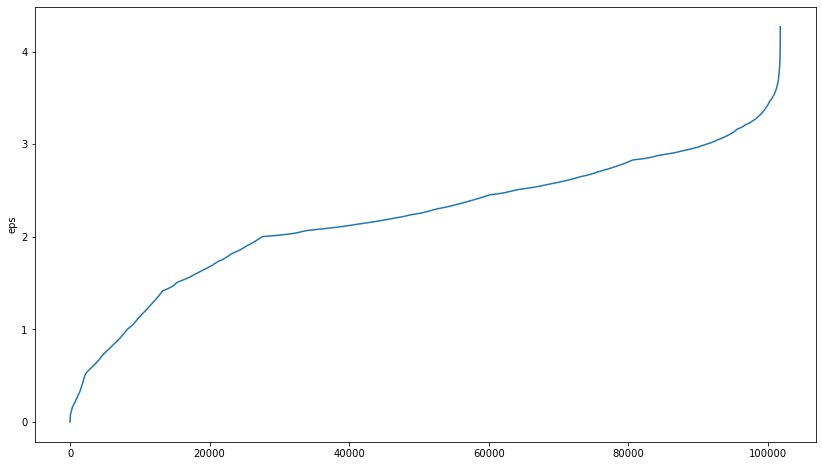

DBScan based Outlier Detection has  27399  outliers
row  1  is an outlier
row  2  is an outlier
row  4  is an outlier
row  9  is an outlier
row  11  is an outlier
row  12  is an outlier
row  15  is an outlier
row  17  is an outlier
row  19  is an outlier
row  28  is an outlier
row  30  is an outlier
row  32  is an outlier
row  42  is an outlier
row  43  is an outlier
row  50  is an outlier
row  54  is an outlier
row  62  is an outlier
row  63  is an outlier
row  65  is an outlier
row  73  is an outlier
row  87  is an outlier
row  98  is an outlier
row  99  is an outlier
row  105  is an outlier
row  106  is an outlier
row  111  is an outlier
row  121  is an outlier
row  123  is an outlier
row  124  is an outlier
row  125  is an outlier
row  127  is an outlier
row  129  is an outlier
row  131  is an outlier
row  132  is an outlier
row  134  is an outlier
row  135  is an outlier
row  140  is an outlier
row  143  is an outlier
row  145  is an outlier
row  146  is an outlier
row  148  is an

row  1562  is an outlier
row  1578  is an outlier
row  1579  is an outlier
row  1586  is an outlier
row  1590  is an outlier
row  1591  is an outlier
row  1592  is an outlier
row  1593  is an outlier
row  1595  is an outlier
row  1596  is an outlier
row  1597  is an outlier
row  1598  is an outlier
row  1600  is an outlier
row  1601  is an outlier
row  1604  is an outlier
row  1605  is an outlier
row  1606  is an outlier
row  1612  is an outlier
row  1613  is an outlier
row  1614  is an outlier
row  1620  is an outlier
row  1628  is an outlier
row  1633  is an outlier
row  1635  is an outlier
row  1638  is an outlier
row  1641  is an outlier
row  1643  is an outlier
row  1650  is an outlier
row  1652  is an outlier
row  1655  is an outlier
row  1657  is an outlier
row  1661  is an outlier
row  1666  is an outlier
row  1667  is an outlier
row  1668  is an outlier
row  1669  is an outlier
row  1670  is an outlier
row  1674  is an outlier
row  1682  is an outlier
row  1685  is an outlier


row  3199  is an outlier
row  3202  is an outlier
row  3207  is an outlier
row  3208  is an outlier
row  3209  is an outlier
row  3211  is an outlier
row  3230  is an outlier
row  3236  is an outlier
row  3237  is an outlier
row  3240  is an outlier
row  3248  is an outlier
row  3250  is an outlier
row  3255  is an outlier
row  3258  is an outlier
row  3264  is an outlier
row  3269  is an outlier
row  3274  is an outlier
row  3276  is an outlier
row  3281  is an outlier
row  3283  is an outlier
row  3288  is an outlier
row  3289  is an outlier
row  3290  is an outlier
row  3292  is an outlier
row  3295  is an outlier
row  3296  is an outlier
row  3300  is an outlier
row  3304  is an outlier
row  3313  is an outlier
row  3314  is an outlier
row  3315  is an outlier
row  3317  is an outlier
row  3320  is an outlier
row  3321  is an outlier
row  3325  is an outlier
row  3326  is an outlier
row  3329  is an outlier
row  3333  is an outlier
row  3335  is an outlier
row  3340  is an outlier


row  4887  is an outlier
row  4888  is an outlier
row  4896  is an outlier
row  4898  is an outlier
row  4901  is an outlier
row  4903  is an outlier
row  4905  is an outlier
row  4906  is an outlier
row  4908  is an outlier
row  4911  is an outlier
row  4912  is an outlier
row  4919  is an outlier
row  4921  is an outlier
row  4927  is an outlier
row  4939  is an outlier
row  4940  is an outlier
row  4941  is an outlier
row  4942  is an outlier
row  4953  is an outlier
row  4954  is an outlier
row  4956  is an outlier
row  4960  is an outlier
row  4963  is an outlier
row  4967  is an outlier
row  4968  is an outlier
row  4969  is an outlier
row  4970  is an outlier
row  4971  is an outlier
row  4973  is an outlier
row  4975  is an outlier
row  4982  is an outlier
row  4984  is an outlier
row  4986  is an outlier
row  4988  is an outlier
row  4989  is an outlier
row  4992  is an outlier
row  4993  is an outlier
row  4995  is an outlier
row  4996  is an outlier
row  5000  is an outlier


row  6348  is an outlier
row  6355  is an outlier
row  6357  is an outlier
row  6358  is an outlier
row  6359  is an outlier
row  6361  is an outlier
row  6365  is an outlier
row  6366  is an outlier
row  6367  is an outlier
row  6369  is an outlier
row  6370  is an outlier
row  6374  is an outlier
row  6375  is an outlier
row  6378  is an outlier
row  6380  is an outlier
row  6381  is an outlier
row  6383  is an outlier
row  6384  is an outlier
row  6385  is an outlier
row  6388  is an outlier
row  6389  is an outlier
row  6393  is an outlier
row  6394  is an outlier
row  6395  is an outlier
row  6396  is an outlier
row  6405  is an outlier
row  6407  is an outlier
row  6410  is an outlier
row  6411  is an outlier
row  6412  is an outlier
row  6414  is an outlier
row  6416  is an outlier
row  6424  is an outlier
row  6429  is an outlier
row  6431  is an outlier
row  6432  is an outlier
row  6434  is an outlier
row  6436  is an outlier
row  6439  is an outlier
row  6443  is an outlier


row  7654  is an outlier
row  7655  is an outlier
row  7659  is an outlier
row  7662  is an outlier
row  7665  is an outlier
row  7667  is an outlier
row  7671  is an outlier
row  7675  is an outlier
row  7676  is an outlier
row  7677  is an outlier
row  7678  is an outlier
row  7679  is an outlier
row  7687  is an outlier
row  7698  is an outlier
row  7703  is an outlier
row  7711  is an outlier
row  7716  is an outlier
row  7721  is an outlier
row  7725  is an outlier
row  7736  is an outlier
row  7737  is an outlier
row  7740  is an outlier
row  7742  is an outlier
row  7744  is an outlier
row  7750  is an outlier
row  7754  is an outlier
row  7758  is an outlier
row  7765  is an outlier
row  7768  is an outlier
row  7770  is an outlier
row  7772  is an outlier
row  7776  is an outlier
row  7786  is an outlier
row  7788  is an outlier
row  7791  is an outlier
row  7793  is an outlier
row  7799  is an outlier
row  7802  is an outlier
row  7804  is an outlier
row  7805  is an outlier


row  9156  is an outlier
row  9157  is an outlier
row  9160  is an outlier
row  9163  is an outlier
row  9181  is an outlier
row  9187  is an outlier
row  9190  is an outlier
row  9196  is an outlier
row  9198  is an outlier
row  9199  is an outlier
row  9202  is an outlier
row  9206  is an outlier
row  9207  is an outlier
row  9209  is an outlier
row  9212  is an outlier
row  9214  is an outlier
row  9215  is an outlier
row  9218  is an outlier
row  9219  is an outlier
row  9222  is an outlier
row  9224  is an outlier
row  9225  is an outlier
row  9226  is an outlier
row  9229  is an outlier
row  9232  is an outlier
row  9234  is an outlier
row  9237  is an outlier
row  9250  is an outlier
row  9253  is an outlier
row  9256  is an outlier
row  9259  is an outlier
row  9262  is an outlier
row  9264  is an outlier
row  9265  is an outlier
row  9269  is an outlier
row  9273  is an outlier
row  9274  is an outlier
row  9277  is an outlier
row  9280  is an outlier
row  9285  is an outlier


row  10719  is an outlier
row  10724  is an outlier
row  10725  is an outlier
row  10728  is an outlier
row  10732  is an outlier
row  10744  is an outlier
row  10749  is an outlier
row  10753  is an outlier
row  10757  is an outlier
row  10760  is an outlier
row  10761  is an outlier
row  10767  is an outlier
row  10768  is an outlier
row  10777  is an outlier
row  10784  is an outlier
row  10786  is an outlier
row  10788  is an outlier
row  10795  is an outlier
row  10799  is an outlier
row  10802  is an outlier
row  10803  is an outlier
row  10809  is an outlier
row  10812  is an outlier
row  10813  is an outlier
row  10815  is an outlier
row  10816  is an outlier
row  10825  is an outlier
row  10828  is an outlier
row  10829  is an outlier
row  10831  is an outlier
row  10833  is an outlier
row  10834  is an outlier
row  10836  is an outlier
row  10842  is an outlier
row  10846  is an outlier
row  10852  is an outlier
row  10857  is an outlier
row  10858  is an outlier
row  10863  

row  12229  is an outlier
row  12233  is an outlier
row  12235  is an outlier
row  12237  is an outlier
row  12239  is an outlier
row  12244  is an outlier
row  12245  is an outlier
row  12246  is an outlier
row  12249  is an outlier
row  12250  is an outlier
row  12253  is an outlier
row  12261  is an outlier
row  12264  is an outlier
row  12267  is an outlier
row  12275  is an outlier
row  12287  is an outlier
row  12291  is an outlier
row  12292  is an outlier
row  12293  is an outlier
row  12297  is an outlier
row  12308  is an outlier
row  12312  is an outlier
row  12313  is an outlier
row  12314  is an outlier
row  12323  is an outlier
row  12324  is an outlier
row  12329  is an outlier
row  12330  is an outlier
row  12333  is an outlier
row  12335  is an outlier
row  12342  is an outlier
row  12351  is an outlier
row  12353  is an outlier
row  12356  is an outlier
row  12358  is an outlier
row  12359  is an outlier
row  12360  is an outlier
row  12361  is an outlier
row  12368  

row  14014  is an outlier
row  14017  is an outlier
row  14020  is an outlier
row  14022  is an outlier
row  14026  is an outlier
row  14029  is an outlier
row  14041  is an outlier
row  14047  is an outlier
row  14048  is an outlier
row  14053  is an outlier
row  14054  is an outlier
row  14055  is an outlier
row  14059  is an outlier
row  14063  is an outlier
row  14066  is an outlier
row  14069  is an outlier
row  14070  is an outlier
row  14074  is an outlier
row  14084  is an outlier
row  14085  is an outlier
row  14092  is an outlier
row  14097  is an outlier
row  14099  is an outlier
row  14104  is an outlier
row  14106  is an outlier
row  14111  is an outlier
row  14112  is an outlier
row  14113  is an outlier
row  14118  is an outlier
row  14119  is an outlier
row  14125  is an outlier
row  14138  is an outlier
row  14140  is an outlier
row  14144  is an outlier
row  14145  is an outlier
row  14147  is an outlier
row  14158  is an outlier
row  14168  is an outlier
row  14169  

row  15536  is an outlier
row  15538  is an outlier
row  15539  is an outlier
row  15540  is an outlier
row  15542  is an outlier
row  15544  is an outlier
row  15545  is an outlier
row  15547  is an outlier
row  15551  is an outlier
row  15553  is an outlier
row  15560  is an outlier
row  15566  is an outlier
row  15568  is an outlier
row  15573  is an outlier
row  15579  is an outlier
row  15582  is an outlier
row  15583  is an outlier
row  15585  is an outlier
row  15592  is an outlier
row  15594  is an outlier
row  15595  is an outlier
row  15604  is an outlier
row  15610  is an outlier
row  15622  is an outlier
row  15627  is an outlier
row  15629  is an outlier
row  15630  is an outlier
row  15631  is an outlier
row  15633  is an outlier
row  15635  is an outlier
row  15637  is an outlier
row  15639  is an outlier
row  15640  is an outlier
row  15643  is an outlier
row  15644  is an outlier
row  15646  is an outlier
row  15654  is an outlier
row  15657  is an outlier
row  15658  

row  17119  is an outlier
row  17121  is an outlier
row  17124  is an outlier
row  17125  is an outlier
row  17129  is an outlier
row  17132  is an outlier
row  17133  is an outlier
row  17135  is an outlier
row  17141  is an outlier
row  17143  is an outlier
row  17144  is an outlier
row  17148  is an outlier
row  17152  is an outlier
row  17153  is an outlier
row  17154  is an outlier
row  17159  is an outlier
row  17160  is an outlier
row  17161  is an outlier
row  17166  is an outlier
row  17171  is an outlier
row  17173  is an outlier
row  17175  is an outlier
row  17179  is an outlier
row  17180  is an outlier
row  17186  is an outlier
row  17189  is an outlier
row  17193  is an outlier
row  17194  is an outlier
row  17200  is an outlier
row  17201  is an outlier
row  17205  is an outlier
row  17206  is an outlier
row  17210  is an outlier
row  17218  is an outlier
row  17220  is an outlier
row  17223  is an outlier
row  17229  is an outlier
row  17236  is an outlier
row  17240  

row  18672  is an outlier
row  18675  is an outlier
row  18678  is an outlier
row  18680  is an outlier
row  18681  is an outlier
row  18686  is an outlier
row  18687  is an outlier
row  18689  is an outlier
row  18691  is an outlier
row  18692  is an outlier
row  18694  is an outlier
row  18701  is an outlier
row  18702  is an outlier
row  18704  is an outlier
row  18705  is an outlier
row  18712  is an outlier
row  18715  is an outlier
row  18716  is an outlier
row  18717  is an outlier
row  18723  is an outlier
row  18729  is an outlier
row  18744  is an outlier
row  18745  is an outlier
row  18747  is an outlier
row  18751  is an outlier
row  18752  is an outlier
row  18753  is an outlier
row  18758  is an outlier
row  18761  is an outlier
row  18763  is an outlier
row  18767  is an outlier
row  18770  is an outlier
row  18774  is an outlier
row  18777  is an outlier
row  18778  is an outlier
row  18779  is an outlier
row  18781  is an outlier
row  18786  is an outlier
row  18788  

row  20164  is an outlier
row  20168  is an outlier
row  20173  is an outlier
row  20178  is an outlier
row  20182  is an outlier
row  20184  is an outlier
row  20188  is an outlier
row  20191  is an outlier
row  20197  is an outlier
row  20200  is an outlier
row  20207  is an outlier
row  20215  is an outlier
row  20220  is an outlier
row  20227  is an outlier
row  20236  is an outlier
row  20237  is an outlier
row  20244  is an outlier
row  20247  is an outlier
row  20253  is an outlier
row  20256  is an outlier
row  20262  is an outlier
row  20263  is an outlier
row  20266  is an outlier
row  20270  is an outlier
row  20274  is an outlier
row  20277  is an outlier
row  20278  is an outlier
row  20287  is an outlier
row  20288  is an outlier
row  20291  is an outlier
row  20292  is an outlier
row  20296  is an outlier
row  20301  is an outlier
row  20303  is an outlier
row  20306  is an outlier
row  20309  is an outlier
row  20310  is an outlier
row  20313  is an outlier
row  20316  

row  21499  is an outlier
row  21504  is an outlier
row  21510  is an outlier
row  21511  is an outlier
row  21513  is an outlier
row  21514  is an outlier
row  21516  is an outlier
row  21517  is an outlier
row  21520  is an outlier
row  21522  is an outlier
row  21533  is an outlier
row  21534  is an outlier
row  21539  is an outlier
row  21543  is an outlier
row  21552  is an outlier
row  21561  is an outlier
row  21562  is an outlier
row  21569  is an outlier
row  21571  is an outlier
row  21573  is an outlier
row  21578  is an outlier
row  21579  is an outlier
row  21580  is an outlier
row  21582  is an outlier
row  21584  is an outlier
row  21590  is an outlier
row  21591  is an outlier
row  21592  is an outlier
row  21594  is an outlier
row  21595  is an outlier
row  21597  is an outlier
row  21601  is an outlier
row  21604  is an outlier
row  21610  is an outlier
row  21614  is an outlier
row  21615  is an outlier
row  21621  is an outlier
row  21622  is an outlier
row  21624  

row  22946  is an outlier
row  22948  is an outlier
row  22950  is an outlier
row  22952  is an outlier
row  22955  is an outlier
row  22957  is an outlier
row  22959  is an outlier
row  22967  is an outlier
row  22969  is an outlier
row  22970  is an outlier
row  22974  is an outlier
row  22975  is an outlier
row  22977  is an outlier
row  22981  is an outlier
row  22983  is an outlier
row  22991  is an outlier
row  22992  is an outlier
row  22995  is an outlier
row  23002  is an outlier
row  23004  is an outlier
row  23008  is an outlier
row  23016  is an outlier
row  23030  is an outlier
row  23031  is an outlier
row  23035  is an outlier
row  23036  is an outlier
row  23037  is an outlier
row  23042  is an outlier
row  23044  is an outlier
row  23045  is an outlier
row  23047  is an outlier
row  23050  is an outlier
row  23052  is an outlier
row  23053  is an outlier
row  23054  is an outlier
row  23055  is an outlier
row  23060  is an outlier
row  23069  is an outlier
row  23073  

row  24488  is an outlier
row  24491  is an outlier
row  24509  is an outlier
row  24516  is an outlier
row  24521  is an outlier
row  24526  is an outlier
row  24530  is an outlier
row  24531  is an outlier
row  24535  is an outlier
row  24537  is an outlier
row  24543  is an outlier
row  24544  is an outlier
row  24547  is an outlier
row  24548  is an outlier
row  24551  is an outlier
row  24556  is an outlier
row  24559  is an outlier
row  24561  is an outlier
row  24562  is an outlier
row  24563  is an outlier
row  24566  is an outlier
row  24568  is an outlier
row  24572  is an outlier
row  24573  is an outlier
row  24575  is an outlier
row  24584  is an outlier
row  24586  is an outlier
row  24587  is an outlier
row  24592  is an outlier
row  24593  is an outlier
row  24598  is an outlier
row  24599  is an outlier
row  24602  is an outlier
row  24603  is an outlier
row  24608  is an outlier
row  24610  is an outlier
row  24611  is an outlier
row  24613  is an outlier
row  24620  

row  26040  is an outlier
row  26042  is an outlier
row  26044  is an outlier
row  26045  is an outlier
row  26049  is an outlier
row  26050  is an outlier
row  26051  is an outlier
row  26057  is an outlier
row  26059  is an outlier
row  26060  is an outlier
row  26061  is an outlier
row  26062  is an outlier
row  26067  is an outlier
row  26068  is an outlier
row  26070  is an outlier
row  26071  is an outlier
row  26072  is an outlier
row  26073  is an outlier
row  26079  is an outlier
row  26087  is an outlier
row  26090  is an outlier
row  26095  is an outlier
row  26101  is an outlier
row  26102  is an outlier
row  26105  is an outlier
row  26108  is an outlier
row  26109  is an outlier
row  26114  is an outlier
row  26126  is an outlier
row  26127  is an outlier
row  26130  is an outlier
row  26133  is an outlier
row  26138  is an outlier
row  26140  is an outlier
row  26157  is an outlier
row  26159  is an outlier
row  26161  is an outlier
row  26162  is an outlier
row  26164  

row  27620  is an outlier
row  27622  is an outlier
row  27627  is an outlier
row  27628  is an outlier
row  27629  is an outlier
row  27632  is an outlier
row  27633  is an outlier
row  27636  is an outlier
row  27641  is an outlier
row  27645  is an outlier
row  27646  is an outlier
row  27649  is an outlier
row  27655  is an outlier
row  27658  is an outlier
row  27662  is an outlier
row  27663  is an outlier
row  27666  is an outlier
row  27667  is an outlier
row  27671  is an outlier
row  27672  is an outlier
row  27674  is an outlier
row  27677  is an outlier
row  27691  is an outlier
row  27696  is an outlier
row  27699  is an outlier
row  27708  is an outlier
row  27709  is an outlier
row  27710  is an outlier
row  27711  is an outlier
row  27712  is an outlier
row  27713  is an outlier
row  27716  is an outlier
row  27717  is an outlier
row  27721  is an outlier
row  27723  is an outlier
row  27725  is an outlier
row  27733  is an outlier
row  27734  is an outlier
row  27736  

row  28917  is an outlier
row  28921  is an outlier
row  28922  is an outlier
row  28923  is an outlier
row  28924  is an outlier
row  28926  is an outlier
row  28932  is an outlier
row  28933  is an outlier
row  28940  is an outlier
row  28942  is an outlier
row  28945  is an outlier
row  28947  is an outlier
row  28948  is an outlier
row  28949  is an outlier
row  28950  is an outlier
row  28952  is an outlier
row  28955  is an outlier
row  28957  is an outlier
row  28958  is an outlier
row  28960  is an outlier
row  28966  is an outlier
row  28969  is an outlier
row  28970  is an outlier
row  28974  is an outlier
row  28975  is an outlier
row  28976  is an outlier
row  28985  is an outlier
row  28986  is an outlier
row  28988  is an outlier
row  28991  is an outlier
row  28993  is an outlier
row  28999  is an outlier
row  29000  is an outlier
row  29004  is an outlier
row  29007  is an outlier
row  29010  is an outlier
row  29014  is an outlier
row  29016  is an outlier
row  29019  

row  30138  is an outlier
row  30142  is an outlier
row  30144  is an outlier
row  30145  is an outlier
row  30148  is an outlier
row  30150  is an outlier
row  30151  is an outlier
row  30153  is an outlier
row  30156  is an outlier
row  30159  is an outlier
row  30160  is an outlier
row  30161  is an outlier
row  30164  is an outlier
row  30165  is an outlier
row  30167  is an outlier
row  30170  is an outlier
row  30172  is an outlier
row  30175  is an outlier
row  30179  is an outlier
row  30181  is an outlier
row  30182  is an outlier
row  30183  is an outlier
row  30188  is an outlier
row  30190  is an outlier
row  30192  is an outlier
row  30197  is an outlier
row  30199  is an outlier
row  30201  is an outlier
row  30204  is an outlier
row  30206  is an outlier
row  30209  is an outlier
row  30213  is an outlier
row  30216  is an outlier
row  30220  is an outlier
row  30222  is an outlier
row  30227  is an outlier
row  30228  is an outlier
row  30231  is an outlier
row  30232  

row  31276  is an outlier
row  31280  is an outlier
row  31282  is an outlier
row  31285  is an outlier
row  31286  is an outlier
row  31289  is an outlier
row  31291  is an outlier
row  31292  is an outlier
row  31294  is an outlier
row  31295  is an outlier
row  31304  is an outlier
row  31307  is an outlier
row  31309  is an outlier
row  31312  is an outlier
row  31315  is an outlier
row  31316  is an outlier
row  31317  is an outlier
row  31319  is an outlier
row  31324  is an outlier
row  31329  is an outlier
row  31332  is an outlier
row  31336  is an outlier
row  31338  is an outlier
row  31339  is an outlier
row  31346  is an outlier
row  31350  is an outlier
row  31351  is an outlier
row  31356  is an outlier
row  31360  is an outlier
row  31361  is an outlier
row  31363  is an outlier
row  31364  is an outlier
row  31366  is an outlier
row  31373  is an outlier
row  31376  is an outlier
row  31377  is an outlier
row  31378  is an outlier
row  31379  is an outlier
row  31381  

row  32357  is an outlier
row  32358  is an outlier
row  32359  is an outlier
row  32361  is an outlier
row  32364  is an outlier
row  32368  is an outlier
row  32372  is an outlier
row  32373  is an outlier
row  32380  is an outlier
row  32388  is an outlier
row  32389  is an outlier
row  32392  is an outlier
row  32393  is an outlier
row  32396  is an outlier
row  32399  is an outlier
row  32402  is an outlier
row  32404  is an outlier
row  32409  is an outlier
row  32411  is an outlier
row  32415  is an outlier
row  32425  is an outlier
row  32429  is an outlier
row  32435  is an outlier
row  32439  is an outlier
row  32440  is an outlier
row  32441  is an outlier
row  32443  is an outlier
row  32447  is an outlier
row  32452  is an outlier
row  32453  is an outlier
row  32458  is an outlier
row  32462  is an outlier
row  32466  is an outlier
row  32468  is an outlier
row  32469  is an outlier
row  32475  is an outlier
row  32477  is an outlier
row  32479  is an outlier
row  32480  

row  33609  is an outlier
row  33610  is an outlier
row  33612  is an outlier
row  33613  is an outlier
row  33615  is an outlier
row  33617  is an outlier
row  33620  is an outlier
row  33622  is an outlier
row  33633  is an outlier
row  33640  is an outlier
row  33643  is an outlier
row  33648  is an outlier
row  33653  is an outlier
row  33655  is an outlier
row  33659  is an outlier
row  33661  is an outlier
row  33667  is an outlier
row  33668  is an outlier
row  33676  is an outlier
row  33678  is an outlier
row  33687  is an outlier
row  33692  is an outlier
row  33698  is an outlier
row  33699  is an outlier
row  33702  is an outlier
row  33703  is an outlier
row  33705  is an outlier
row  33706  is an outlier
row  33709  is an outlier
row  33711  is an outlier
row  33712  is an outlier
row  33713  is an outlier
row  33714  is an outlier
row  33715  is an outlier
row  33719  is an outlier
row  33722  is an outlier
row  33723  is an outlier
row  33729  is an outlier
row  33731  

row  34864  is an outlier
row  34866  is an outlier
row  34867  is an outlier
row  34868  is an outlier
row  34873  is an outlier
row  34876  is an outlier
row  34877  is an outlier
row  34879  is an outlier
row  34882  is an outlier
row  34883  is an outlier
row  34885  is an outlier
row  34893  is an outlier
row  34896  is an outlier
row  34902  is an outlier
row  34904  is an outlier
row  34905  is an outlier
row  34906  is an outlier
row  34911  is an outlier
row  34914  is an outlier
row  34915  is an outlier
row  34916  is an outlier
row  34917  is an outlier
row  34921  is an outlier
row  34935  is an outlier
row  34940  is an outlier
row  34942  is an outlier
row  34944  is an outlier
row  34946  is an outlier
row  34952  is an outlier
row  34955  is an outlier
row  34958  is an outlier
row  34960  is an outlier
row  34961  is an outlier
row  34969  is an outlier
row  34973  is an outlier
row  34976  is an outlier
row  34977  is an outlier
row  34980  is an outlier
row  34982  

row  36250  is an outlier
row  36252  is an outlier
row  36253  is an outlier
row  36257  is an outlier
row  36259  is an outlier
row  36261  is an outlier
row  36263  is an outlier
row  36268  is an outlier
row  36273  is an outlier
row  36275  is an outlier
row  36279  is an outlier
row  36287  is an outlier
row  36293  is an outlier
row  36294  is an outlier
row  36296  is an outlier
row  36298  is an outlier
row  36299  is an outlier
row  36304  is an outlier
row  36309  is an outlier
row  36310  is an outlier
row  36312  is an outlier
row  36313  is an outlier
row  36316  is an outlier
row  36318  is an outlier
row  36323  is an outlier
row  36325  is an outlier
row  36328  is an outlier
row  36334  is an outlier
row  36335  is an outlier
row  36338  is an outlier
row  36343  is an outlier
row  36345  is an outlier
row  36349  is an outlier
row  36352  is an outlier
row  36354  is an outlier
row  36357  is an outlier
row  36359  is an outlier
row  36360  is an outlier
row  36367  

row  37619  is an outlier
row  37622  is an outlier
row  37629  is an outlier
row  37631  is an outlier
row  37638  is an outlier
row  37641  is an outlier
row  37642  is an outlier
row  37643  is an outlier
row  37645  is an outlier
row  37646  is an outlier
row  37648  is an outlier
row  37651  is an outlier
row  37652  is an outlier
row  37656  is an outlier
row  37663  is an outlier
row  37667  is an outlier
row  37668  is an outlier
row  37669  is an outlier
row  37671  is an outlier
row  37674  is an outlier
row  37675  is an outlier
row  37678  is an outlier
row  37682  is an outlier
row  37683  is an outlier
row  37687  is an outlier
row  37691  is an outlier
row  37693  is an outlier
row  37699  is an outlier
row  37704  is an outlier
row  37705  is an outlier
row  37706  is an outlier
row  37708  is an outlier
row  37711  is an outlier
row  37716  is an outlier
row  37717  is an outlier
row  37718  is an outlier
row  37720  is an outlier
row  37732  is an outlier
row  37735  

row  38798  is an outlier
row  38802  is an outlier
row  38808  is an outlier
row  38810  is an outlier
row  38811  is an outlier
row  38813  is an outlier
row  38814  is an outlier
row  38816  is an outlier
row  38825  is an outlier
row  38829  is an outlier
row  38835  is an outlier
row  38839  is an outlier
row  38841  is an outlier
row  38851  is an outlier
row  38852  is an outlier
row  38855  is an outlier
row  38858  is an outlier
row  38861  is an outlier
row  38862  is an outlier
row  38864  is an outlier
row  38865  is an outlier
row  38870  is an outlier
row  38873  is an outlier
row  38878  is an outlier
row  38883  is an outlier
row  38884  is an outlier
row  38886  is an outlier
row  38889  is an outlier
row  38891  is an outlier
row  38893  is an outlier
row  38896  is an outlier
row  38898  is an outlier
row  38900  is an outlier
row  38905  is an outlier
row  38908  is an outlier
row  38909  is an outlier
row  38913  is an outlier
row  38917  is an outlier
row  38920  

row  40123  is an outlier
row  40125  is an outlier
row  40126  is an outlier
row  40133  is an outlier
row  40136  is an outlier
row  40138  is an outlier
row  40144  is an outlier
row  40149  is an outlier
row  40150  is an outlier
row  40154  is an outlier
row  40159  is an outlier
row  40161  is an outlier
row  40164  is an outlier
row  40167  is an outlier
row  40172  is an outlier
row  40175  is an outlier
row  40177  is an outlier
row  40178  is an outlier
row  40184  is an outlier
row  40185  is an outlier
row  40187  is an outlier
row  40188  is an outlier
row  40189  is an outlier
row  40200  is an outlier
row  40203  is an outlier
row  40204  is an outlier
row  40205  is an outlier
row  40211  is an outlier
row  40214  is an outlier
row  40215  is an outlier
row  40220  is an outlier
row  40223  is an outlier
row  40229  is an outlier
row  40234  is an outlier
row  40238  is an outlier
row  40243  is an outlier
row  40249  is an outlier
row  40251  is an outlier
row  40253  

row  41708  is an outlier
row  41710  is an outlier
row  41711  is an outlier
row  41723  is an outlier
row  41732  is an outlier
row  41736  is an outlier
row  41737  is an outlier
row  41744  is an outlier
row  41746  is an outlier
row  41747  is an outlier
row  41751  is an outlier
row  41758  is an outlier
row  41760  is an outlier
row  41764  is an outlier
row  41770  is an outlier
row  41771  is an outlier
row  41775  is an outlier
row  41776  is an outlier
row  41777  is an outlier
row  41779  is an outlier
row  41781  is an outlier
row  41783  is an outlier
row  41792  is an outlier
row  41796  is an outlier
row  41797  is an outlier
row  41801  is an outlier
row  41802  is an outlier
row  41805  is an outlier
row  41809  is an outlier
row  41811  is an outlier
row  41815  is an outlier
row  41817  is an outlier
row  41823  is an outlier
row  41824  is an outlier
row  41830  is an outlier
row  41835  is an outlier
row  41837  is an outlier
row  41839  is an outlier
row  41840  

row  43649  is an outlier
row  43654  is an outlier
row  43657  is an outlier
row  43662  is an outlier
row  43664  is an outlier
row  43667  is an outlier
row  43668  is an outlier
row  43671  is an outlier
row  43680  is an outlier
row  43681  is an outlier
row  43682  is an outlier
row  43685  is an outlier
row  43686  is an outlier
row  43689  is an outlier
row  43694  is an outlier
row  43696  is an outlier
row  43702  is an outlier
row  43703  is an outlier
row  43704  is an outlier
row  43706  is an outlier
row  43709  is an outlier
row  43712  is an outlier
row  43716  is an outlier
row  43723  is an outlier
row  43727  is an outlier
row  43729  is an outlier
row  43731  is an outlier
row  43732  is an outlier
row  43735  is an outlier
row  43740  is an outlier
row  43741  is an outlier
row  43745  is an outlier
row  43747  is an outlier
row  43752  is an outlier
row  43755  is an outlier
row  43763  is an outlier
row  43765  is an outlier
row  43767  is an outlier
row  43768  

row  45083  is an outlier
row  45101  is an outlier
row  45102  is an outlier
row  45103  is an outlier
row  45108  is an outlier
row  45110  is an outlier
row  45113  is an outlier
row  45115  is an outlier
row  45116  is an outlier
row  45117  is an outlier
row  45121  is an outlier
row  45124  is an outlier
row  45126  is an outlier
row  45127  is an outlier
row  45128  is an outlier
row  45132  is an outlier
row  45139  is an outlier
row  45148  is an outlier
row  45152  is an outlier
row  45153  is an outlier
row  45155  is an outlier
row  45159  is an outlier
row  45164  is an outlier
row  45167  is an outlier
row  45168  is an outlier
row  45170  is an outlier
row  45171  is an outlier
row  45183  is an outlier
row  45193  is an outlier
row  45203  is an outlier
row  45207  is an outlier
row  45214  is an outlier
row  45215  is an outlier
row  45220  is an outlier
row  45225  is an outlier
row  45230  is an outlier
row  45231  is an outlier
row  45232  is an outlier
row  45235  

row  46654  is an outlier
row  46655  is an outlier
row  46658  is an outlier
row  46660  is an outlier
row  46665  is an outlier
row  46666  is an outlier
row  46667  is an outlier
row  46672  is an outlier
row  46673  is an outlier
row  46676  is an outlier
row  46679  is an outlier
row  46688  is an outlier
row  46689  is an outlier
row  46696  is an outlier
row  46700  is an outlier
row  46708  is an outlier
row  46711  is an outlier
row  46720  is an outlier
row  46721  is an outlier
row  46727  is an outlier
row  46732  is an outlier
row  46736  is an outlier
row  46740  is an outlier
row  46743  is an outlier
row  46746  is an outlier
row  46750  is an outlier
row  46753  is an outlier
row  46758  is an outlier
row  46759  is an outlier
row  46763  is an outlier
row  46765  is an outlier
row  46768  is an outlier
row  46779  is an outlier
row  46780  is an outlier
row  46781  is an outlier
row  46786  is an outlier
row  46788  is an outlier
row  46790  is an outlier
row  46791  

row  48219  is an outlier
row  48226  is an outlier
row  48235  is an outlier
row  48237  is an outlier
row  48240  is an outlier
row  48243  is an outlier
row  48245  is an outlier
row  48249  is an outlier
row  48250  is an outlier
row  48251  is an outlier
row  48255  is an outlier
row  48265  is an outlier
row  48271  is an outlier
row  48272  is an outlier
row  48274  is an outlier
row  48280  is an outlier
row  48287  is an outlier
row  48296  is an outlier
row  48297  is an outlier
row  48299  is an outlier
row  48305  is an outlier
row  48308  is an outlier
row  48315  is an outlier
row  48322  is an outlier
row  48323  is an outlier
row  48325  is an outlier
row  48327  is an outlier
row  48334  is an outlier
row  48338  is an outlier
row  48343  is an outlier
row  48346  is an outlier
row  48350  is an outlier
row  48364  is an outlier
row  48370  is an outlier
row  48373  is an outlier
row  48374  is an outlier
row  48375  is an outlier
row  48377  is an outlier
row  48380  

row  49871  is an outlier
row  49875  is an outlier
row  49876  is an outlier
row  49883  is an outlier
row  49887  is an outlier
row  49888  is an outlier
row  49890  is an outlier
row  49892  is an outlier
row  49894  is an outlier
row  49895  is an outlier
row  49897  is an outlier
row  49900  is an outlier
row  49902  is an outlier
row  49904  is an outlier
row  49911  is an outlier
row  49916  is an outlier
row  49918  is an outlier
row  49920  is an outlier
row  49921  is an outlier
row  49922  is an outlier
row  49925  is an outlier
row  49928  is an outlier
row  49930  is an outlier
row  49933  is an outlier
row  49937  is an outlier
row  49940  is an outlier
row  49942  is an outlier
row  49943  is an outlier
row  49946  is an outlier
row  49949  is an outlier
row  49956  is an outlier
row  49964  is an outlier
row  49967  is an outlier
row  49975  is an outlier
row  49984  is an outlier
row  49988  is an outlier
row  49993  is an outlier
row  49996  is an outlier
row  49999  

row  51727  is an outlier
row  51735  is an outlier
row  51737  is an outlier
row  51738  is an outlier
row  51742  is an outlier
row  51744  is an outlier
row  51750  is an outlier
row  51753  is an outlier
row  51764  is an outlier
row  51766  is an outlier
row  51767  is an outlier
row  51769  is an outlier
row  51770  is an outlier
row  51773  is an outlier
row  51781  is an outlier
row  51786  is an outlier
row  51798  is an outlier
row  51799  is an outlier
row  51803  is an outlier
row  51806  is an outlier
row  51827  is an outlier
row  51836  is an outlier
row  51837  is an outlier
row  51842  is an outlier
row  51843  is an outlier
row  51845  is an outlier
row  51846  is an outlier
row  51847  is an outlier
row  51849  is an outlier
row  51851  is an outlier
row  51852  is an outlier
row  51853  is an outlier
row  51854  is an outlier
row  51855  is an outlier
row  51860  is an outlier
row  51862  is an outlier
row  51870  is an outlier
row  51876  is an outlier
row  51894  

row  53129  is an outlier
row  53133  is an outlier
row  53139  is an outlier
row  53143  is an outlier
row  53147  is an outlier
row  53154  is an outlier
row  53155  is an outlier
row  53161  is an outlier
row  53165  is an outlier
row  53168  is an outlier
row  53171  is an outlier
row  53173  is an outlier
row  53174  is an outlier
row  53175  is an outlier
row  53181  is an outlier
row  53182  is an outlier
row  53188  is an outlier
row  53189  is an outlier
row  53190  is an outlier
row  53194  is an outlier
row  53204  is an outlier
row  53216  is an outlier
row  53217  is an outlier
row  53220  is an outlier
row  53223  is an outlier
row  53224  is an outlier
row  53228  is an outlier
row  53230  is an outlier
row  53231  is an outlier
row  53233  is an outlier
row  53234  is an outlier
row  53235  is an outlier
row  53236  is an outlier
row  53239  is an outlier
row  53257  is an outlier
row  53259  is an outlier
row  53271  is an outlier
row  53274  is an outlier
row  53279  

row  54641  is an outlier
row  54648  is an outlier
row  54651  is an outlier
row  54657  is an outlier
row  54660  is an outlier
row  54661  is an outlier
row  54662  is an outlier
row  54667  is an outlier
row  54673  is an outlier
row  54675  is an outlier
row  54678  is an outlier
row  54680  is an outlier
row  54681  is an outlier
row  54682  is an outlier
row  54685  is an outlier
row  54689  is an outlier
row  54690  is an outlier
row  54691  is an outlier
row  54692  is an outlier
row  54696  is an outlier
row  54704  is an outlier
row  54708  is an outlier
row  54709  is an outlier
row  54713  is an outlier
row  54715  is an outlier
row  54719  is an outlier
row  54721  is an outlier
row  54728  is an outlier
row  54729  is an outlier
row  54732  is an outlier
row  54742  is an outlier
row  54746  is an outlier
row  54751  is an outlier
row  54755  is an outlier
row  54760  is an outlier
row  54762  is an outlier
row  54765  is an outlier
row  54769  is an outlier
row  54771  

row  56156  is an outlier
row  56157  is an outlier
row  56163  is an outlier
row  56172  is an outlier
row  56192  is an outlier
row  56193  is an outlier
row  56194  is an outlier
row  56198  is an outlier
row  56201  is an outlier
row  56203  is an outlier
row  56209  is an outlier
row  56215  is an outlier
row  56224  is an outlier
row  56227  is an outlier
row  56230  is an outlier
row  56247  is an outlier
row  56248  is an outlier
row  56249  is an outlier
row  56251  is an outlier
row  56254  is an outlier
row  56256  is an outlier
row  56264  is an outlier
row  56267  is an outlier
row  56274  is an outlier
row  56277  is an outlier
row  56290  is an outlier
row  56294  is an outlier
row  56295  is an outlier
row  56300  is an outlier
row  56308  is an outlier
row  56312  is an outlier
row  56313  is an outlier
row  56321  is an outlier
row  56327  is an outlier
row  56329  is an outlier
row  56333  is an outlier
row  56335  is an outlier
row  56340  is an outlier
row  56349  

row  57908  is an outlier
row  57909  is an outlier
row  57913  is an outlier
row  57916  is an outlier
row  57918  is an outlier
row  57920  is an outlier
row  57926  is an outlier
row  57927  is an outlier
row  57930  is an outlier
row  57932  is an outlier
row  57935  is an outlier
row  57937  is an outlier
row  57938  is an outlier
row  57940  is an outlier
row  57944  is an outlier
row  57950  is an outlier
row  57954  is an outlier
row  57955  is an outlier
row  57956  is an outlier
row  57957  is an outlier
row  57961  is an outlier
row  57962  is an outlier
row  57963  is an outlier
row  57964  is an outlier
row  57967  is an outlier
row  57971  is an outlier
row  57973  is an outlier
row  57989  is an outlier
row  57991  is an outlier
row  57994  is an outlier
row  57997  is an outlier
row  58000  is an outlier
row  58008  is an outlier
row  58014  is an outlier
row  58016  is an outlier
row  58019  is an outlier
row  58021  is an outlier
row  58022  is an outlier
row  58025  

row  59581  is an outlier
row  59582  is an outlier
row  59594  is an outlier
row  59595  is an outlier
row  59600  is an outlier
row  59603  is an outlier
row  59604  is an outlier
row  59610  is an outlier
row  59613  is an outlier
row  59625  is an outlier
row  59628  is an outlier
row  59633  is an outlier
row  59635  is an outlier
row  59637  is an outlier
row  59650  is an outlier
row  59655  is an outlier
row  59656  is an outlier
row  59657  is an outlier
row  59658  is an outlier
row  59660  is an outlier
row  59662  is an outlier
row  59665  is an outlier
row  59666  is an outlier
row  59667  is an outlier
row  59670  is an outlier
row  59672  is an outlier
row  59678  is an outlier
row  59679  is an outlier
row  59682  is an outlier
row  59691  is an outlier
row  59695  is an outlier
row  59697  is an outlier
row  59698  is an outlier
row  59699  is an outlier
row  59701  is an outlier
row  59702  is an outlier
row  59704  is an outlier
row  59705  is an outlier
row  59706  

row  61161  is an outlier
row  61162  is an outlier
row  61171  is an outlier
row  61175  is an outlier
row  61181  is an outlier
row  61182  is an outlier
row  61183  is an outlier
row  61184  is an outlier
row  61188  is an outlier
row  61189  is an outlier
row  61193  is an outlier
row  61194  is an outlier
row  61195  is an outlier
row  61198  is an outlier
row  61200  is an outlier
row  61203  is an outlier
row  61205  is an outlier
row  61211  is an outlier
row  61215  is an outlier
row  61219  is an outlier
row  61222  is an outlier
row  61226  is an outlier
row  61227  is an outlier
row  61229  is an outlier
row  61234  is an outlier
row  61239  is an outlier
row  61242  is an outlier
row  61246  is an outlier
row  61249  is an outlier
row  61253  is an outlier
row  61270  is an outlier
row  61271  is an outlier
row  61280  is an outlier
row  61281  is an outlier
row  61284  is an outlier
row  61289  is an outlier
row  61290  is an outlier
row  61304  is an outlier
row  61308  

row  62706  is an outlier
row  62709  is an outlier
row  62725  is an outlier
row  62730  is an outlier
row  62733  is an outlier
row  62734  is an outlier
row  62743  is an outlier
row  62744  is an outlier
row  62757  is an outlier
row  62761  is an outlier
row  62764  is an outlier
row  62765  is an outlier
row  62768  is an outlier
row  62775  is an outlier
row  62780  is an outlier
row  62781  is an outlier
row  62782  is an outlier
row  62783  is an outlier
row  62786  is an outlier
row  62792  is an outlier
row  62793  is an outlier
row  62794  is an outlier
row  62799  is an outlier
row  62804  is an outlier
row  62805  is an outlier
row  62808  is an outlier
row  62810  is an outlier
row  62811  is an outlier
row  62812  is an outlier
row  62813  is an outlier
row  62814  is an outlier
row  62822  is an outlier
row  62826  is an outlier
row  62831  is an outlier
row  62832  is an outlier
row  62837  is an outlier
row  62838  is an outlier
row  62839  is an outlier
row  62842  

row  64431  is an outlier
row  64433  is an outlier
row  64439  is an outlier
row  64444  is an outlier
row  64454  is an outlier
row  64461  is an outlier
row  64462  is an outlier
row  64467  is an outlier
row  64469  is an outlier
row  64474  is an outlier
row  64484  is an outlier
row  64485  is an outlier
row  64490  is an outlier
row  64496  is an outlier
row  64498  is an outlier
row  64500  is an outlier
row  64507  is an outlier
row  64509  is an outlier
row  64516  is an outlier
row  64526  is an outlier
row  64531  is an outlier
row  64538  is an outlier
row  64539  is an outlier
row  64540  is an outlier
row  64543  is an outlier
row  64545  is an outlier
row  64547  is an outlier
row  64551  is an outlier
row  64552  is an outlier
row  64553  is an outlier
row  64556  is an outlier
row  64559  is an outlier
row  64562  is an outlier
row  64564  is an outlier
row  64566  is an outlier
row  64567  is an outlier
row  64570  is an outlier
row  64586  is an outlier
row  64587  

row  66052  is an outlier
row  66058  is an outlier
row  66066  is an outlier
row  66069  is an outlier
row  66074  is an outlier
row  66076  is an outlier
row  66079  is an outlier
row  66084  is an outlier
row  66087  is an outlier
row  66090  is an outlier
row  66092  is an outlier
row  66097  is an outlier
row  66098  is an outlier
row  66099  is an outlier
row  66100  is an outlier
row  66106  is an outlier
row  66107  is an outlier
row  66113  is an outlier
row  66117  is an outlier
row  66118  is an outlier
row  66120  is an outlier
row  66121  is an outlier
row  66122  is an outlier
row  66127  is an outlier
row  66139  is an outlier
row  66145  is an outlier
row  66149  is an outlier
row  66150  is an outlier
row  66162  is an outlier
row  66164  is an outlier
row  66171  is an outlier
row  66184  is an outlier
row  66187  is an outlier
row  66188  is an outlier
row  66189  is an outlier
row  66201  is an outlier
row  66208  is an outlier
row  66214  is an outlier
row  66218  

row  67582  is an outlier
row  67584  is an outlier
row  67587  is an outlier
row  67589  is an outlier
row  67591  is an outlier
row  67595  is an outlier
row  67596  is an outlier
row  67597  is an outlier
row  67601  is an outlier
row  67602  is an outlier
row  67603  is an outlier
row  67608  is an outlier
row  67611  is an outlier
row  67612  is an outlier
row  67614  is an outlier
row  67615  is an outlier
row  67619  is an outlier
row  67620  is an outlier
row  67637  is an outlier
row  67640  is an outlier
row  67642  is an outlier
row  67645  is an outlier
row  67646  is an outlier
row  67648  is an outlier
row  67651  is an outlier
row  67652  is an outlier
row  67653  is an outlier
row  67657  is an outlier
row  67662  is an outlier
row  67671  is an outlier
row  67673  is an outlier
row  67675  is an outlier
row  67676  is an outlier
row  67680  is an outlier
row  67683  is an outlier
row  67693  is an outlier
row  67704  is an outlier
row  67705  is an outlier
row  67709  

row  69225  is an outlier
row  69227  is an outlier
row  69228  is an outlier
row  69229  is an outlier
row  69235  is an outlier
row  69238  is an outlier
row  69240  is an outlier
row  69243  is an outlier
row  69245  is an outlier
row  69255  is an outlier
row  69259  is an outlier
row  69266  is an outlier
row  69267  is an outlier
row  69269  is an outlier
row  69271  is an outlier
row  69273  is an outlier
row  69286  is an outlier
row  69292  is an outlier
row  69297  is an outlier
row  69302  is an outlier
row  69304  is an outlier
row  69309  is an outlier
row  69312  is an outlier
row  69314  is an outlier
row  69320  is an outlier
row  69322  is an outlier
row  69324  is an outlier
row  69328  is an outlier
row  69334  is an outlier
row  69338  is an outlier
row  69339  is an outlier
row  69347  is an outlier
row  69349  is an outlier
row  69352  is an outlier
row  69356  is an outlier
row  69362  is an outlier
row  69374  is an outlier
row  69375  is an outlier
row  69380  

row  71210  is an outlier
row  71211  is an outlier
row  71214  is an outlier
row  71227  is an outlier
row  71231  is an outlier
row  71232  is an outlier
row  71233  is an outlier
row  71235  is an outlier
row  71239  is an outlier
row  71240  is an outlier
row  71242  is an outlier
row  71244  is an outlier
row  71245  is an outlier
row  71250  is an outlier
row  71258  is an outlier
row  71261  is an outlier
row  71262  is an outlier
row  71274  is an outlier
row  71276  is an outlier
row  71277  is an outlier
row  71279  is an outlier
row  71288  is an outlier
row  71291  is an outlier
row  71293  is an outlier
row  71295  is an outlier
row  71296  is an outlier
row  71297  is an outlier
row  71299  is an outlier
row  71302  is an outlier
row  71308  is an outlier
row  71309  is an outlier
row  71310  is an outlier
row  71320  is an outlier
row  71321  is an outlier
row  71323  is an outlier
row  71324  is an outlier
row  71327  is an outlier
row  71328  is an outlier
row  71329  

row  72893  is an outlier
row  72895  is an outlier
row  72907  is an outlier
row  72910  is an outlier
row  72916  is an outlier
row  72917  is an outlier
row  72918  is an outlier
row  72935  is an outlier
row  72936  is an outlier
row  72937  is an outlier
row  72948  is an outlier
row  72949  is an outlier
row  72953  is an outlier
row  72955  is an outlier
row  72958  is an outlier
row  72959  is an outlier
row  72960  is an outlier
row  72966  is an outlier
row  72970  is an outlier
row  72971  is an outlier
row  72977  is an outlier
row  72979  is an outlier
row  72981  is an outlier
row  72983  is an outlier
row  72984  is an outlier
row  72986  is an outlier
row  72987  is an outlier
row  72989  is an outlier
row  72992  is an outlier
row  73002  is an outlier
row  73003  is an outlier
row  73011  is an outlier
row  73017  is an outlier
row  73022  is an outlier
row  73024  is an outlier
row  73029  is an outlier
row  73030  is an outlier
row  73034  is an outlier
row  73037  

row  75072  is an outlier
row  75075  is an outlier
row  75077  is an outlier
row  75087  is an outlier
row  75088  is an outlier
row  75089  is an outlier
row  75094  is an outlier
row  75099  is an outlier
row  75100  is an outlier
row  75111  is an outlier
row  75123  is an outlier
row  75127  is an outlier
row  75130  is an outlier
row  75133  is an outlier
row  75139  is an outlier
row  75141  is an outlier
row  75142  is an outlier
row  75152  is an outlier
row  75159  is an outlier
row  75163  is an outlier
row  75166  is an outlier
row  75172  is an outlier
row  75178  is an outlier
row  75185  is an outlier
row  75186  is an outlier
row  75191  is an outlier
row  75194  is an outlier
row  75202  is an outlier
row  75208  is an outlier
row  75218  is an outlier
row  75219  is an outlier
row  75220  is an outlier
row  75221  is an outlier
row  75224  is an outlier
row  75230  is an outlier
row  75238  is an outlier
row  75244  is an outlier
row  75245  is an outlier
row  75254  

row  76621  is an outlier
row  76623  is an outlier
row  76625  is an outlier
row  76626  is an outlier
row  76627  is an outlier
row  76629  is an outlier
row  76631  is an outlier
row  76633  is an outlier
row  76636  is an outlier
row  76640  is an outlier
row  76647  is an outlier
row  76655  is an outlier
row  76657  is an outlier
row  76660  is an outlier
row  76662  is an outlier
row  76663  is an outlier
row  76667  is an outlier
row  76671  is an outlier
row  76673  is an outlier
row  76677  is an outlier
row  76678  is an outlier
row  76683  is an outlier
row  76686  is an outlier
row  76690  is an outlier
row  76693  is an outlier
row  76695  is an outlier
row  76701  is an outlier
row  76703  is an outlier
row  76708  is an outlier
row  76712  is an outlier
row  76718  is an outlier
row  76721  is an outlier
row  76724  is an outlier
row  76725  is an outlier
row  76733  is an outlier
row  76735  is an outlier
row  76740  is an outlier
row  76746  is an outlier
row  76755  

row  78174  is an outlier
row  78181  is an outlier
row  78186  is an outlier
row  78188  is an outlier
row  78190  is an outlier
row  78193  is an outlier
row  78194  is an outlier
row  78195  is an outlier
row  78196  is an outlier
row  78200  is an outlier
row  78201  is an outlier
row  78202  is an outlier
row  78203  is an outlier
row  78204  is an outlier
row  78209  is an outlier
row  78211  is an outlier
row  78219  is an outlier
row  78220  is an outlier
row  78221  is an outlier
row  78222  is an outlier
row  78225  is an outlier
row  78228  is an outlier
row  78229  is an outlier
row  78235  is an outlier
row  78247  is an outlier
row  78248  is an outlier
row  78252  is an outlier
row  78257  is an outlier
row  78261  is an outlier
row  78263  is an outlier
row  78268  is an outlier
row  78269  is an outlier
row  78277  is an outlier
row  78279  is an outlier
row  78286  is an outlier
row  78293  is an outlier
row  78294  is an outlier
row  78296  is an outlier
row  78297  

row  80233  is an outlier
row  80247  is an outlier
row  80259  is an outlier
row  80262  is an outlier
row  80264  is an outlier
row  80267  is an outlier
row  80273  is an outlier
row  80275  is an outlier
row  80276  is an outlier
row  80282  is an outlier
row  80283  is an outlier
row  80287  is an outlier
row  80290  is an outlier
row  80292  is an outlier
row  80296  is an outlier
row  80299  is an outlier
row  80301  is an outlier
row  80310  is an outlier
row  80311  is an outlier
row  80313  is an outlier
row  80322  is an outlier
row  80325  is an outlier
row  80327  is an outlier
row  80354  is an outlier
row  80360  is an outlier
row  80368  is an outlier
row  80370  is an outlier
row  80372  is an outlier
row  80380  is an outlier
row  80381  is an outlier
row  80382  is an outlier
row  80384  is an outlier
row  80387  is an outlier
row  80405  is an outlier
row  80411  is an outlier
row  80417  is an outlier
row  80419  is an outlier
row  80422  is an outlier
row  80426  

row  82428  is an outlier
row  82435  is an outlier
row  82436  is an outlier
row  82438  is an outlier
row  82441  is an outlier
row  82446  is an outlier
row  82451  is an outlier
row  82455  is an outlier
row  82460  is an outlier
row  82463  is an outlier
row  82467  is an outlier
row  82476  is an outlier
row  82481  is an outlier
row  82483  is an outlier
row  82488  is an outlier
row  82493  is an outlier
row  82495  is an outlier
row  82498  is an outlier
row  82499  is an outlier
row  82501  is an outlier
row  82505  is an outlier
row  82512  is an outlier
row  82517  is an outlier
row  82521  is an outlier
row  82529  is an outlier
row  82539  is an outlier
row  82544  is an outlier
row  82550  is an outlier
row  82551  is an outlier
row  82564  is an outlier
row  82565  is an outlier
row  82567  is an outlier
row  82572  is an outlier
row  82573  is an outlier
row  82575  is an outlier
row  82583  is an outlier
row  82584  is an outlier
row  82588  is an outlier
row  82594  

row  84531  is an outlier
row  84534  is an outlier
row  84543  is an outlier
row  84547  is an outlier
row  84549  is an outlier
row  84552  is an outlier
row  84553  is an outlier
row  84554  is an outlier
row  84567  is an outlier
row  84570  is an outlier
row  84572  is an outlier
row  84591  is an outlier
row  84593  is an outlier
row  84598  is an outlier
row  84603  is an outlier
row  84605  is an outlier
row  84609  is an outlier
row  84611  is an outlier
row  84612  is an outlier
row  84618  is an outlier
row  84622  is an outlier
row  84625  is an outlier
row  84631  is an outlier
row  84636  is an outlier
row  84641  is an outlier
row  84642  is an outlier
row  84646  is an outlier
row  84654  is an outlier
row  84656  is an outlier
row  84659  is an outlier
row  84660  is an outlier
row  84662  is an outlier
row  84664  is an outlier
row  84666  is an outlier
row  84668  is an outlier
row  84676  is an outlier
row  84679  is an outlier
row  84696  is an outlier
row  84697  

row  86338  is an outlier
row  86341  is an outlier
row  86344  is an outlier
row  86354  is an outlier
row  86355  is an outlier
row  86360  is an outlier
row  86364  is an outlier
row  86365  is an outlier
row  86371  is an outlier
row  86379  is an outlier
row  86381  is an outlier
row  86383  is an outlier
row  86387  is an outlier
row  86392  is an outlier
row  86397  is an outlier
row  86400  is an outlier
row  86404  is an outlier
row  86413  is an outlier
row  86416  is an outlier
row  86417  is an outlier
row  86423  is an outlier
row  86426  is an outlier
row  86436  is an outlier
row  86451  is an outlier
row  86456  is an outlier
row  86457  is an outlier
row  86460  is an outlier
row  86467  is an outlier
row  86468  is an outlier
row  86469  is an outlier
row  86470  is an outlier
row  86480  is an outlier
row  86491  is an outlier
row  86492  is an outlier
row  86498  is an outlier
row  86500  is an outlier
row  86501  is an outlier
row  86504  is an outlier
row  86505  

row  88111  is an outlier
row  88114  is an outlier
row  88118  is an outlier
row  88123  is an outlier
row  88136  is an outlier
row  88142  is an outlier
row  88146  is an outlier
row  88148  is an outlier
row  88150  is an outlier
row  88151  is an outlier
row  88153  is an outlier
row  88154  is an outlier
row  88160  is an outlier
row  88173  is an outlier
row  88174  is an outlier
row  88176  is an outlier
row  88185  is an outlier
row  88191  is an outlier
row  88201  is an outlier
row  88207  is an outlier
row  88208  is an outlier
row  88214  is an outlier
row  88219  is an outlier
row  88223  is an outlier
row  88245  is an outlier
row  88256  is an outlier
row  88261  is an outlier
row  88269  is an outlier
row  88270  is an outlier
row  88277  is an outlier
row  88279  is an outlier
row  88286  is an outlier
row  88287  is an outlier
row  88289  is an outlier
row  88302  is an outlier
row  88306  is an outlier
row  88311  is an outlier
row  88314  is an outlier
row  88337  

row  90143  is an outlier
row  90148  is an outlier
row  90163  is an outlier
row  90166  is an outlier
row  90174  is an outlier
row  90177  is an outlier
row  90178  is an outlier
row  90184  is an outlier
row  90188  is an outlier
row  90193  is an outlier
row  90198  is an outlier
row  90206  is an outlier
row  90208  is an outlier
row  90209  is an outlier
row  90215  is an outlier
row  90220  is an outlier
row  90222  is an outlier
row  90224  is an outlier
row  90226  is an outlier
row  90227  is an outlier
row  90237  is an outlier
row  90241  is an outlier
row  90244  is an outlier
row  90249  is an outlier
row  90250  is an outlier
row  90258  is an outlier
row  90260  is an outlier
row  90266  is an outlier
row  90268  is an outlier
row  90271  is an outlier
row  90272  is an outlier
row  90277  is an outlier
row  90278  is an outlier
row  90281  is an outlier
row  90283  is an outlier
row  90284  is an outlier
row  90289  is an outlier
row  90293  is an outlier
row  90295  

row  91717  is an outlier
row  91718  is an outlier
row  91719  is an outlier
row  91720  is an outlier
row  91723  is an outlier
row  91731  is an outlier
row  91743  is an outlier
row  91745  is an outlier
row  91747  is an outlier
row  91750  is an outlier
row  91751  is an outlier
row  91752  is an outlier
row  91753  is an outlier
row  91754  is an outlier
row  91755  is an outlier
row  91760  is an outlier
row  91762  is an outlier
row  91769  is an outlier
row  91770  is an outlier
row  91772  is an outlier
row  91774  is an outlier
row  91775  is an outlier
row  91776  is an outlier
row  91788  is an outlier
row  91792  is an outlier
row  91793  is an outlier
row  91794  is an outlier
row  91795  is an outlier
row  91798  is an outlier
row  91799  is an outlier
row  91801  is an outlier
row  91802  is an outlier
row  91809  is an outlier
row  91814  is an outlier
row  91829  is an outlier
row  91831  is an outlier
row  91841  is an outlier
row  91842  is an outlier
row  91854  

row  93485  is an outlier
row  93490  is an outlier
row  93492  is an outlier
row  93493  is an outlier
row  93497  is an outlier
row  93499  is an outlier
row  93501  is an outlier
row  93505  is an outlier
row  93512  is an outlier
row  93519  is an outlier
row  93522  is an outlier
row  93524  is an outlier
row  93527  is an outlier
row  93532  is an outlier
row  93536  is an outlier
row  93539  is an outlier
row  93545  is an outlier
row  93549  is an outlier
row  93550  is an outlier
row  93554  is an outlier
row  93557  is an outlier
row  93564  is an outlier
row  93576  is an outlier
row  93577  is an outlier
row  93587  is an outlier
row  93590  is an outlier
row  93595  is an outlier
row  93601  is an outlier
row  93603  is an outlier
row  93606  is an outlier
row  93608  is an outlier
row  93611  is an outlier
row  93615  is an outlier
row  93618  is an outlier
row  93620  is an outlier
row  93623  is an outlier
row  93627  is an outlier
row  93628  is an outlier
row  93631  

row  95346  is an outlier
row  95347  is an outlier
row  95348  is an outlier
row  95351  is an outlier
row  95353  is an outlier
row  95354  is an outlier
row  95355  is an outlier
row  95358  is an outlier
row  95360  is an outlier
row  95361  is an outlier
row  95367  is an outlier
row  95369  is an outlier
row  95372  is an outlier
row  95375  is an outlier
row  95386  is an outlier
row  95387  is an outlier
row  95388  is an outlier
row  95393  is an outlier
row  95397  is an outlier
row  95408  is an outlier
row  95409  is an outlier
row  95414  is an outlier
row  95417  is an outlier
row  95420  is an outlier
row  95425  is an outlier
row  95427  is an outlier
row  95429  is an outlier
row  95444  is an outlier
row  95445  is an outlier
row  95446  is an outlier
row  95449  is an outlier
row  95452  is an outlier
row  95457  is an outlier
row  95458  is an outlier
row  95460  is an outlier
row  95461  is an outlier
row  95465  is an outlier
row  95472  is an outlier
row  95473  

row  97525  is an outlier
row  97535  is an outlier
row  97539  is an outlier
row  97546  is an outlier
row  97556  is an outlier
row  97564  is an outlier
row  97567  is an outlier
row  97569  is an outlier
row  97572  is an outlier
row  97579  is an outlier
row  97598  is an outlier
row  97607  is an outlier
row  97611  is an outlier
row  97612  is an outlier
row  97614  is an outlier
row  97615  is an outlier
row  97621  is an outlier
row  97632  is an outlier
row  97633  is an outlier
row  97638  is an outlier
row  97639  is an outlier
row  97640  is an outlier
row  97656  is an outlier
row  97664  is an outlier
row  97666  is an outlier
row  97667  is an outlier
row  97671  is an outlier
row  97672  is an outlier
row  97684  is an outlier
row  97687  is an outlier
row  97688  is an outlier
row  97693  is an outlier
row  97697  is an outlier
row  97700  is an outlier
row  97701  is an outlier
row  97704  is an outlier
row  97705  is an outlier
row  97718  is an outlier
row  97719  

row  99601  is an outlier
row  99605  is an outlier
row  99611  is an outlier
row  99612  is an outlier
row  99614  is an outlier
row  99616  is an outlier
row  99622  is an outlier
row  99628  is an outlier
row  99629  is an outlier
row  99636  is an outlier
row  99643  is an outlier
row  99646  is an outlier
row  99651  is an outlier
row  99654  is an outlier
row  99672  is an outlier
row  99681  is an outlier
row  99682  is an outlier
row  99684  is an outlier
row  99686  is an outlier
row  99692  is an outlier
row  99708  is an outlier
row  99714  is an outlier
row  99718  is an outlier
row  99719  is an outlier
row  99720  is an outlier
row  99723  is an outlier
row  99726  is an outlier
row  99730  is an outlier
row  99737  is an outlier
row  99740  is an outlier
row  99748  is an outlier
row  99757  is an outlier
row  99760  is an outlier
row  99761  is an outlier
row  99766  is an outlier
row  99768  is an outlier
row  99769  is an outlier
row  99775  is an outlier
row  99778  

row  101431  is an outlier
row  101433  is an outlier
row  101436  is an outlier
row  101440  is an outlier
row  101441  is an outlier
row  101447  is an outlier
row  101448  is an outlier
row  101452  is an outlier
row  101455  is an outlier
row  101458  is an outlier
row  101459  is an outlier
row  101461  is an outlier
row  101474  is an outlier
row  101476  is an outlier
row  101484  is an outlier
row  101494  is an outlier
row  101498  is an outlier
row  101499  is an outlier
row  101514  is an outlier
row  101516  is an outlier
row  101517  is an outlier
row  101523  is an outlier
row  101524  is an outlier
row  101527  is an outlier
row  101529  is an outlier
row  101535  is an outlier
row  101541  is an outlier
row  101546  is an outlier
row  101548  is an outlier
row  101551  is an outlier
row  101555  is an outlier
row  101561  is an outlier
row  101565  is an outlier
row  101568  is an outlier
row  101569  is an outlier
row  101575  is an outlier
row  101579  is an outlier
r

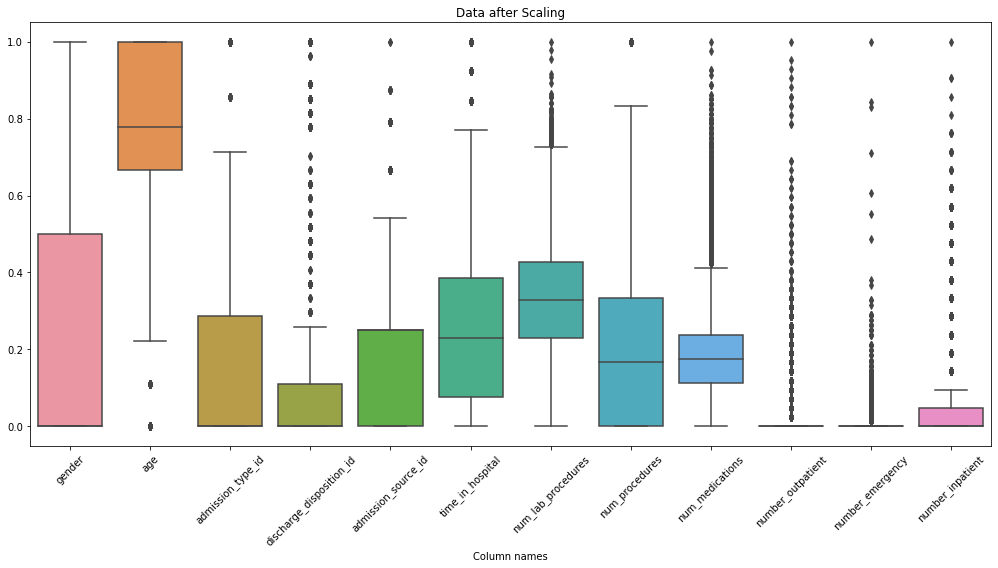

Scaling completed         gender       age  admission_type_id  discharge_disposition_id  \
0          0.0  0.000000           0.714286                  0.888889   
1          0.0  0.111111           0.000000                  0.000000   
2          0.0  0.222222           0.000000                  0.000000   
3          0.5  0.444444           0.000000                  0.000000   
4          0.5  0.555556           0.000000                  0.000000   
...        ...       ...                ...                       ...   
101761     0.5  1.000000           0.000000                  0.074074   
101762     0.0  0.666667           0.000000                  0.111111   
101763     0.5  1.000000           0.000000                  0.000000   
101764     0.0  0.666667           0.142857                  0.074074   
101765     0.5  1.000000           0.000000                  0.000000   

        admission_source_id  time_in_hospital  num_lab_procedures  \
0                  0.000000         

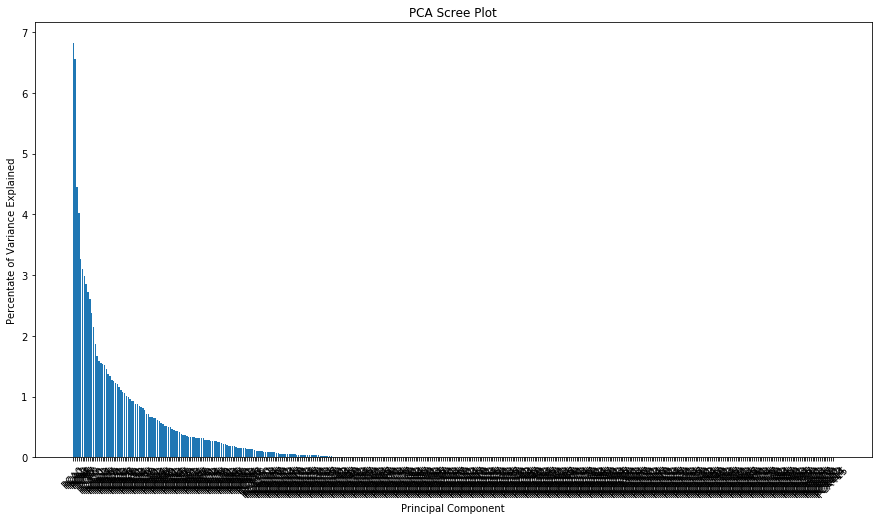

[6.81590076e-02 6.55205816e-02 4.45105112e-02 4.02393083e-02
 3.27386492e-02 3.09726097e-02 2.99173524e-02 2.86350741e-02
 2.71835083e-02 2.60091144e-02 2.37994487e-02 2.15455507e-02
 1.85619671e-02 1.66784621e-02 1.58806976e-02 1.54888623e-02
 1.53062065e-02 1.52333631e-02 1.44825294e-02 1.36591717e-02
 1.32622837e-02 1.26671803e-02 1.24623632e-02 1.22261653e-02
 1.19668385e-02 1.15486242e-02 1.09842619e-02 1.07630627e-02
 1.04697824e-02 1.00502741e-02 9.94864767e-03 9.55376135e-03
 9.27270292e-03 9.19271717e-03 8.76706596e-03 8.74990937e-03
 8.47382881e-03 8.24671730e-03 8.13093558e-03 7.77095330e-03
 7.18799695e-03 7.16713234e-03 6.73383449e-03 6.56346793e-03
 6.45788541e-03 6.40105980e-03 6.24331722e-03 6.01562469e-03
 5.56550544e-03 5.49319086e-03 5.14585993e-03 5.09672758e-03
 4.97555868e-03 4.86086866e-03 4.59831065e-03 4.48048175e-03
 4.39843959e-03 4.28161182e-03 4.09231466e-03 3.79339398e-03
 3.67868576e-03 3.61867876e-03 3.51711542e-03 3.42557212e-03
 3.34951349e-03 3.307875

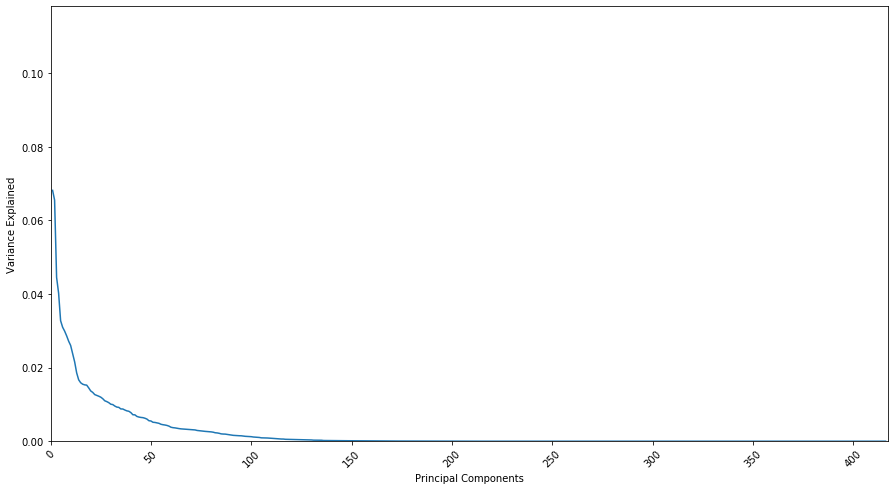

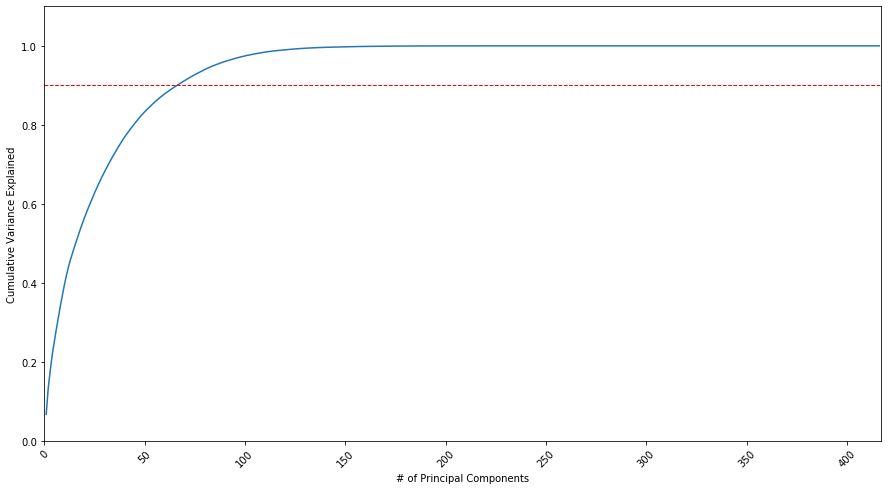

Rerun PCA with reduced number of components
Graph 2,3,4


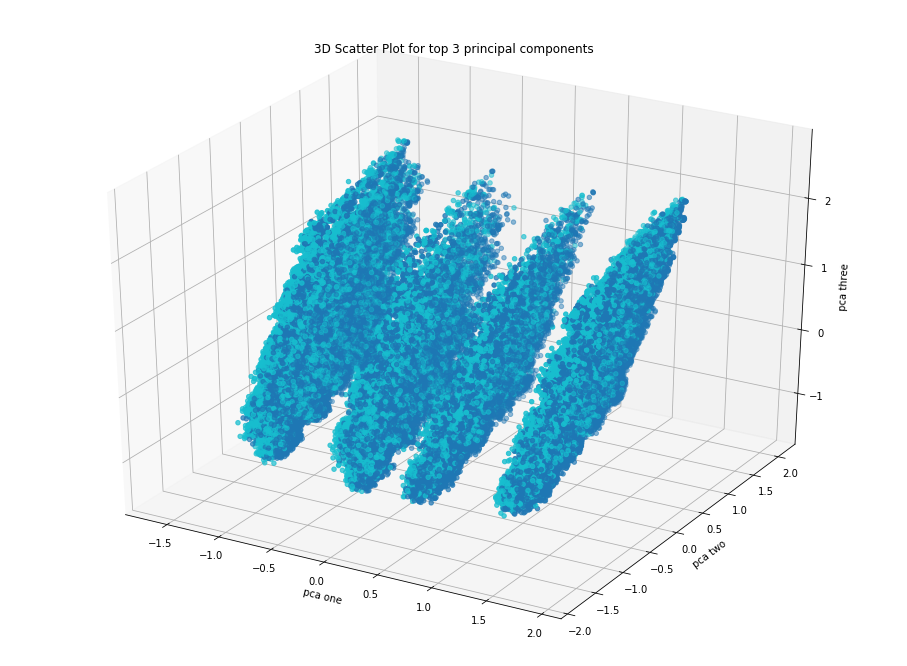

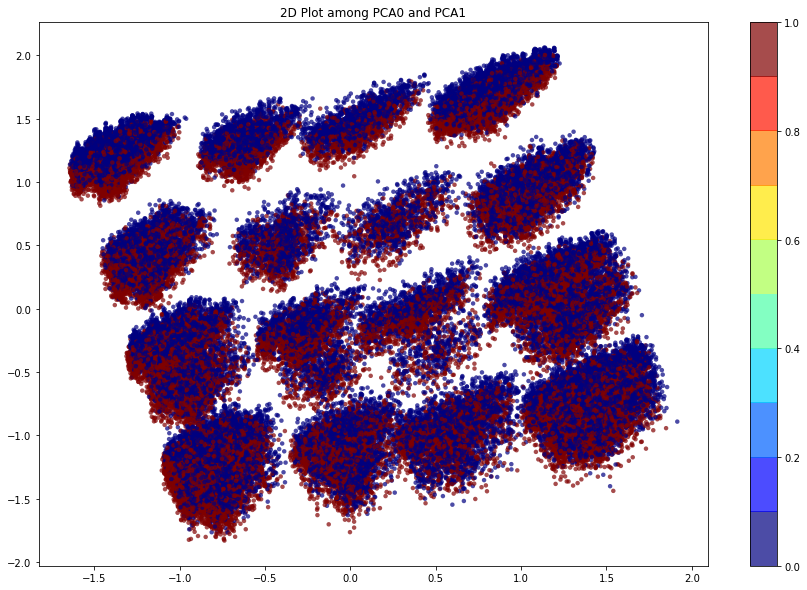

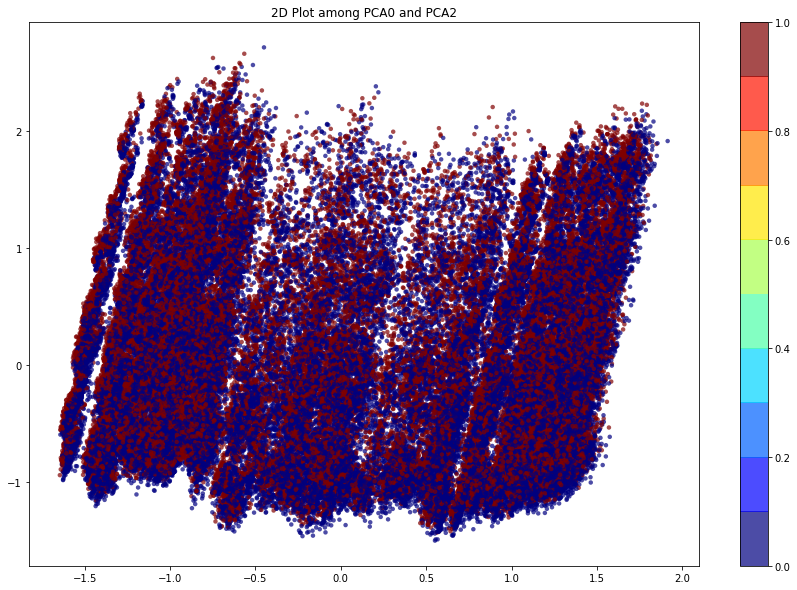

In [6]:
main(False)